# Analysis of Relation between Distribution Shift and Results of CNN without Adaptation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
scenarios = ["cardiac_surgery_vs_no_cardiac_surgery",
                 "no_cardiac_surgery_vs_cardiac_surgery",
                 "respiratory_surgery_vs_no_respiratory_surgery",
                 "no_respiratory_surgery_vs_respiratory_surgery",
                 "vasopressors_vs_no_vasopressors",
                 "no_vasopressors_vs_vasopressors",
                 "ventilation_vs_no_ventilation",
                 "no_ventilation_vs_ventilation"
                 ]

### Functions load distance measures

In [3]:
distance_index_map = {
    "feature_CVP": 2-2,
    "feature_HR": 3-2,
    "feature_NBPSys": 4-2,
    "feature_NBPDias": 5-2,
    "feature_NBPMean": 6-2,
    "feature_SpO2": 7-2,
    "features_sum": 8-2,
    "features_mean": 9-2,
    "features_max": 10-2,
    "label_SpO2": 12-2,
    "features_max_SpO2_label_sum": 15-2,
    "label_NBPMean": 11-2,
    "features_max_NBPMean_label_sum": 18-2,

}

In [4]:
def load_distribution_shifts_overall(distance_measure):
    base_path = "./results/distances/" + distance_measure + "/"

    distance_pair_keys = ["source_train_vs_source_test", "source_train_vs_target_test", "source_test_vs_target_test"]
    distance_measure_keys = ["feature_SpO2","feature_NBPMean", "features_max", "features_mean", "label_SpO2", "features_max_SpO2_label_sum", "label_NBPMean", "features_max_NBPMean_label_sum"]
    
    all_distances_by_scenario = []
    for scenario in scenarios:
        df = pd.read_csv(base_path + scenario + "_distance_measures.csv")
        entry = {
            "scenario": scenario
        }

        for pair_key in distance_pair_keys:
            for measure_key in distance_measure_keys:
                column = f"{pair_key}_{measure_key}".replace("target_test", "target_all")
                entry.update({column: df.loc[distance_index_map[measure_key], pair_key]})
                
        all_distances_by_scenario.append(entry)

    all_distances_by_scenario = pd.DataFrame(all_distances_by_scenario)
    return all_distances_by_scenario


In [5]:
classwise_distance_index_map = {
    "feature_SpO2": 7 - 2,
    "feature_NBPMean": 6 - 2,
    "features_max": 10 - 2,
    "label_NBPMean": 11 -2,
    "label_SpO2": 12 -2,
    "features_max_SpO2_label_sum": 15 -2,
    "features_max_NBPMean_label_sum": 18 -2
}

In [6]:
def load_distribution_shifts_classwise(distance_measure, class_label):
    if class_label not in ["Hypotension", "Hypoxemia"]:
        raise ValueError("class_label must be either 'Hypotension' or 'Hypoxemia'")
    
    base_path = "./results/distances/classwise/" + class_label + "/" + distance_measure + "/" 
    
    distance_pair_keys = ["source_train_vs_source_test", "source_train_vs_target_test", "source_test_vs_target_test"]
    class_keys = ["class1", "class2"]
    distance_measure_keys = ["feature_SpO2", "feature_NBPMean", "features_max", "features_mean", "label_SpO2", "features_max_SpO2_label_sum", "label_NBPMean", "features_max_NBPMean_label_sum"]

    all_distances_by_scenario = []
    for scenario in scenarios:
        df = pd.read_csv(base_path + scenario + "_distance_measures.csv")
        entry = {
            "scenario": scenario + "_" + ("nbp_mean" if class_label=="Hypotension" else "spo2")
        }
        for pair_key in distance_pair_keys:
            for class_key in class_keys:
                for measure_key in distance_measure_keys:
                    column = f"{pair_key}_{class_key}_{measure_key}".replace("target_test", "target_all")
                    entry[column] = df.loc[distance_index_map[measure_key], f"{pair_key}_{class_key}"]

        all_distances_by_scenario.append(entry)

    all_distances_by_scenario = pd.DataFrame(all_distances_by_scenario)
    return all_distances_by_scenario

### Functions load and merge results of CNN NO_ADAPT experiments

In [7]:
def load_ml_results_overall():
    base_path = "./results/CNN_NO_ADAPT/"
    prediction_scenarios = ["spo2", "nbp_mean"]

    all_results_by_scenario = []
    for scenario in scenarios:
        for prediction_scenario in prediction_scenarios:

            #"ventilation_vs_no_ventilation" -> ventilation_cleaned_nbp_mean_to_no_ventilation_cleaned_nbp_mean
            experiment_name = scenario.replace("vs", f"cleaned_{prediction_scenario}_to") + f"_cleaned_{prediction_scenario}"
            experiment_path = base_path + experiment_name + "/best_results_all_target.csv"
            df = pd.read_csv(experiment_path)
            entry = {
                "scenario": scenario,
                "prediction_scenario": prediction_scenario,
                "source_f1_score": df.loc[0, "source_f1_score"],
                "target_f1_score": df.loc[0, "target_f1_score"],
                "delta_f1_score": df.loc[0, "target_f1_score"] - df.loc[0, "source_f1_score"],
                "source_auroc": df.loc[0, "source_auroc"],
                "target_auroc": df.loc[0, "target_auroc"],
                "delta_auroc": df.loc[0, "target_auroc"] - df.loc[0, "source_auroc"],
                "source_mse": df.loc[0, "source_mse_0"],
                "target_mse": df.loc[0, "target_mse_0"],
                "delta_mse": df.loc[0, "target_mse_0"] - df.loc[0, "source_mse_0"],
                "source_rmse": df.loc[0, "source_rmse_0"],
                "target_rmse": df.loc[0, "target_rmse_0"],
                "delta_rmse": df.loc[0, "target_rmse_0"] - df.loc[0, "source_rmse_0"],
            }

            all_results_by_scenario.append(entry)

    all_results_by_scenario = pd.DataFrame(all_results_by_scenario)
    return all_results_by_scenario

In [8]:
def load_ml_results_classwise():
    base_path = "./results/CNN_NO_ADAPT/"
    prediction_scenarios = ["spo2", "nbp_mean"]

    all_results_by_scenario = []
    for scenario in scenarios:
        for prediction_scenario in prediction_scenarios:

            #"ventilation_vs_no_ventilation" -> ventilation_cleaned_nbp_mean_to_no_ventilation_cleaned_nbp_mean
            experiment_name = scenario.replace("vs", f"cleaned_{prediction_scenario}_to") + f"_cleaned_{prediction_scenario}"
            experiment_path = base_path + experiment_name + "/best_results_all_target.csv"
            df = pd.read_csv(experiment_path)
            entry = {
                "scenario": scenario + "_" + prediction_scenario,
                "source_f1_score": df.loc[0, "source_f1_score"],
                "target_f1_score": df.loc[0, "target_f1_score"],
                "delta_f1_score": df.loc[0, "target_f1_score"] - df.loc[0, "source_f1_score"],
                "source_sensitivity": df.loc[0, "source_sensitvity"],
                "target_sensitivity": df.loc[0, "target_sensitvity"],
                "delta_sensitivity": df.loc[0, "target_sensitvity"] - df.loc[0, "source_sensitvity"],
                "source_specificity": df.loc[0, "source_specificity"],
                "target_specificity": df.loc[0, "target_specificity"],
                "delta_specificity": df.loc[0, "target_specificity"] - df.loc[0, "source_specificity"],
                "source_mse": df.loc[0, "source_mse_0"],
                "target_mse": df.loc[0, "target_mse_0"],
                "delta_mse": df.loc[0, "target_mse_0"] - df.loc[0, "source_mse_0"],
                "source_rmse": df.loc[0, "source_rmse_0"],
                "target_rmse": df.loc[0, "target_rmse_0"],
                "delta_rmse": df.loc[0, "target_rmse_0"] - df.loc[0, "source_rmse_0"],
            }

            all_results_by_scenario.append(entry)

    all_results_by_scenario = pd.DataFrame(all_results_by_scenario)
    return all_results_by_scenario

In [9]:
def load_distribution_shift_performance_classwise(distance_measure):
    results_by_scenario = load_ml_results_classwise()
    
    hypotension_distances_by_scenario_df = load_distribution_shifts_classwise(distance_measure, "Hypotension")
    hypoxemia_distances_by_scenario_df = load_distribution_shifts_classwise(distance_measure, "Hypoxemia")
    merged_results_and_distances_hypotension = pd.merge(results_by_scenario, hypotension_distances_by_scenario_df, on="scenario")
    merged_results_and_distances_hypotension["prediction_scenario"] = "nbp_mean"
    merged_results_and_distances_hypoxemia = pd.merge(results_by_scenario, hypoxemia_distances_by_scenario_df, on="scenario")
    merged_results_and_distances_hypoxemia["prediction_scenario"] = "spo2"

    # append merged_results_and_distances_hypoxemia to merged_results_and_distances_hypotension
    merged_results_and_distances_hypotension = pd.concat([merged_results_and_distances_hypotension, merged_results_and_distances_hypoxemia], ignore_index=True)
    label_based_differences = ["source_train_vs_source_test_class1_label", "source_train_vs_source_test_class2_label", "source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label"]
    for label in label_based_differences:
        merged_results_and_distances_hypotension[f"{label}"] = np.where(
            merged_results_and_distances_hypotension["prediction_scenario"] == "nbp_mean",
            merged_results_and_distances_hypotension[f"{label}_NBPMean"],
            merged_results_and_distances_hypotension[f"{label}_SpO2"]
        )

    max_features = ["source_train_vs_source_test_class1_label","source_train_vs_source_test_class2_label"]
    for label in max_features:
        merged_results_and_distances_hypotension[f"delta_{label.replace('source_train_vs_source_test', '')}"] = merged_results_and_distances_hypotension[label.replace("source_train_vs_source_test", "source_train_vs_target_all")] - merged_results_and_distances_hypotension[label]


    max_features = ["source_train_vs_source_test_class1_features_nbpmean_or_spo2","source_train_vs_source_test_class2_features_nbpmean_or_spo2","source_train_vs_target_all_class1_features_nbpmean_or_spo2", "source_train_vs_target_all_class2_features_nbpmean_or_spo2",
                    "source_test_vs_target_all_class1_features_nbpmean_or_spo2", "source_test_vs_target_all_class2_features_nbpmean_or_spo2"]
    for label in max_features:
        merged_results_and_distances_hypotension[f"{label}"] = np.where(
            merged_results_and_distances_hypotension["prediction_scenario"] == "nbp_mean",
            merged_results_and_distances_hypotension[f"{label.replace("_features_nbpmean_or_spo2", "")}_feature_NBPMean"],
            merged_results_and_distances_hypotension[f"{label.replace("_features_nbpmean_or_spo2", "")}_feature_SpO2"]
        )

    max_features = ["source_train_vs_source_test_class1_features_nbpmean_or_spo2","source_train_vs_source_test_class2_features_nbpmean_or_spo2"]
    for label in max_features:
        merged_results_and_distances_hypotension[f"delta_{label.replace('source_train_vs_source_test', '')}"] = merged_results_and_distances_hypotension[label.replace("source_train_vs_source_test", "source_train_vs_target_all")] - merged_results_and_distances_hypotension[label]

    label_based_differences = ["source_train_vs_source_test_class1_features_max_label_sum", "source_train_vs_source_test_class2_features_max_label_sum", "source_train_vs_target_all_class1_features_max_label_sum", "source_train_vs_target_all_class2_features_max_label_sum"]
    for label in label_based_differences:
        merged_results_and_distances_hypotension[f"{label}"] = np.where(
            merged_results_and_distances_hypotension["prediction_scenario"] == "nbp_mean",
            merged_results_and_distances_hypotension[f"{label}".replace("_label_sum", "_NBPMean_label_sum")],
            merged_results_and_distances_hypotension[f"{label}".replace("_label_sum", "_SpO2_label_sum")]
        )
        
    merged_results_and_distances_hypotension["scenario"] = merged_results_and_distances_hypotension["scenario"].str.replace("_nbp_mean", "").str.replace("_spo2", "")
    return merged_results_and_distances_hypotension

In [10]:
def load_distribution_shift_performance_overall(distance_measure):
    results_by_scenario = load_ml_results_overall()
    distances_by_scenario_df = load_distribution_shifts_overall(distance_measure)
    merged_results_and_distances = pd.merge(results_by_scenario, distances_by_scenario_df, on="scenario")

    label_based_differences = ["source_train_vs_source_test_label", "source_train_vs_target_all_label", "source_test_vs_target_all_label"]
    for label in label_based_differences:
        merged_results_and_distances[f"{label}"] = np.where(
            merged_results_and_distances["prediction_scenario"] == "nbp_mean",
            merged_results_and_distances[f"{label}_NBPMean"],
            merged_results_and_distances[f"{label}_SpO2"]
        )

    max_features = ["source_train_vs_source_test_label"]
    for label in max_features:
        merged_results_and_distances[f"delta_{label.replace('source_train_vs_source_test', '')}"] = merged_results_and_distances[label.replace("source_train_vs_source_test", "source_train_vs_target_all")] - merged_results_and_distances[label]


    max_features = ["source_train_vs_source_test_features_nbpmean_or_spo2", "source_train_vs_target_all_features_nbpmean_or_spo2", "source_test_vs_target_all_features_nbpmean_or_spo2"]
    for label in max_features:
        merged_results_and_distances[f"{label}"] = np.where(
            merged_results_and_distances["prediction_scenario"] == "nbp_mean",
            merged_results_and_distances[f"{label.replace("_features_nbpmean_or_spo2", "")}_feature_NBPMean"],
            merged_results_and_distances[f"{label.replace("_features_nbpmean_or_spo2", "")}_feature_SpO2"]
        )

    max_features = ["source_train_vs_source_test_features_nbpmean_or_spo2"]
    for label in max_features:
        merged_results_and_distances[f"delta_{label.replace('source_train_vs_source_test', '')}"] = merged_results_and_distances[label.replace("source_train_vs_source_test", "source_train_vs_target_all")] - merged_results_and_distances[label]


    label_based_differences = ["source_train_vs_source_test_features_max_label_sum", "source_train_vs_target_all_features_max_label_sum"]
    for label in label_based_differences:
        merged_results_and_distances[f"{label}"] = np.where(
            merged_results_and_distances["prediction_scenario"] == "nbp_mean",
            merged_results_and_distances["source_train_vs_target_all_features_max_NBPMean_label_sum"],
            merged_results_and_distances["source_train_vs_target_all_features_max_SpO2_label_sum"]
        )

    return merged_results_and_distances

### Functions Visualizations

In [11]:
scenario_number_dict = {
    "cardiac_surgery_vs_no_cardiac_surgery": '0',
    "no_cardiac_surgery_vs_cardiac_surgery": '1',
    "respiratory_surgery_vs_no_respiratory_surgery": '2',
    "no_respiratory_surgery_vs_respiratory_surgery": '3',
    "vasopressors_vs_no_vasopressors": '4',
    "no_vasopressors_vs_vasopressors": '5',
    "ventilation_vs_no_ventilation": '6',
    "no_ventilation_vs_ventilation": '7'
}

In [12]:
def visualize_performance_drop_with_arrows(axes, relations_to_investigate, shift_combination, merged_results_and_distances, colors):
    titles = ["KS(Source Train, Target All) \n- KS (Source Train, Source Test)\nFeature", "KS(Source Train, Target All) \n- KS (Source Train, Source Test)\nTarget Value", "KS (Source Test, Target All)\nFeature"]
    performance_metrics = ["f1_score", "rmse_nbp_mean", "rmse_spo2"]

    
    i = 0
    for ax, relation in zip(axes, shift_combination):
        #ax.set_title(f"{titles[relations_to_investigate.index(shift_combination)].replace('Feature', 'Features')}")
        performance_metric = performance_metrics[i]
        i += 1
        if "rmse" in performance_metric:
            if "nbp_mean" in performance_metric:
                scenario = "nbp_mean"
            else:
                scenario = "spo2"
            

            df_scenario = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]
            df_scenario.reset_index(drop=True, inplace=True)

            marker = "s" if scenario == "nbp_mean" else "o"

            buffer = 0.01 if scenario == "nbp_mean" else 0.005
            # Plot source and target points
            for idx, (x, y) in enumerate(zip(df_scenario.loc[:, relation[0]], df_scenario.loc[:, f"source_{relation[1]}"])):
                ax.scatter(
                    x,
                    y,
                    s=100,
                    label=f"{scenario} source" if idx == 0 else "",
                    marker=marker,
                    color=colors[scenario],
                    edgecolor='k'
                )


                ax.scatter(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"target_{relation[1]}"],
                    s=100,
                    label=f"{scenario} target",
                    marker=marker,
                    color=colors[scenario],
                    edgecolor='k'
                )

                for j in range(len(df_scenario)):
                    ax.text(
                        df_scenario[relation[0]][j] + buffer,  # Move right by 0.01
                        df_scenario[f"source_{relation[1]}"][j],
                        scenario_number_dict[df_scenario['scenario'][j]],  # Position and label
                        fontsize=16, color='black', va='top', ha='left',
                    )

                            # Draw arrows from source to target
                for x, y_source, y_target in zip(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"source_{relation[1]}"],
                    df_scenario.loc[:, f"target_{relation[1]}"]
                ):
                    ax.annotate(
                        '',
                        xy=(x, y_target),
                        xytext=(x, y_source),
                        arrowprops=dict(arrowstyle="->", color=colors[scenario], lw=2)
                    )
        else:

            for scenario in merged_results_and_distances["prediction_scenario"].unique():
                        scenario_results_and_distances = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]
                        scenario_results_and_distances.reset_index(drop=True, inplace=True)
                            
                        marker = "s" if scenario == "nbp_mean" else "o"
                        # Plot source and target points
                        ax.scatter(
                            scenario_results_and_distances.loc[:, relation[0]],
                            scenario_results_and_distances.loc[:, f"source_{relation[1]}"],
                            s=100,
                            label=f"{scenario} source",
                            marker=marker,
                            color=colors[scenario],
                            edgecolor='k'
                        )

                        for j in range(len(scenario_results_and_distances)):
                            ax.text(
                                scenario_results_and_distances[relation[0]][j] + 0.01,  # Move right by 0.01
                                scenario_results_and_distances[f"source_{relation[1]}"][j],
                                scenario_number_dict[scenario_results_and_distances['scenario'][j]],  # Position and label
                                fontsize=16, color='black', va='top', ha='left',
                            )

                        ax.scatter(
                            scenario_results_and_distances.loc[:, relation[0]],
                            scenario_results_and_distances.loc[:, f"target_{relation[1]}"],
                            s=100,
                            label=f"{scenario} target",
                            marker=marker,
                            color=colors[scenario],
                            edgecolor='k'
                        )

                        # Draw arrows from source to target
                        for x, y_source, y_target in zip(
                            scenario_results_and_distances.loc[:, relation[0]],
                            scenario_results_and_distances.loc[:, f"source_{relation[1]}"],
                            scenario_results_and_distances.loc[:, f"target_{relation[1]}"]
                        ):
                            ax.annotate(
                                '',
                                xy=(x, y_target),
                                xytext=(x, y_source),
                                arrowprops=dict(arrowstyle="->", color=colors[scenario], lw=2)
                            )
                
        ax.set_xlim(None, None)
        # add hline at 0
        #ax.axhline(0, color='gray', linestyle='--')
        #ax.axvline(0, color='gray', linestyle='--')
                
        ax.set_xlabel(f"{titles[relations_to_investigate.index(shift_combination)].replace('Feature', 'Features')}")
        ax.set_ylabel(relation[1].replace('_', ' ').title())


In [13]:
def visualize_source_train_vs_target_all_relationships_absolute_performance(merged_results_and_distances):

    relations_to_investigate = [
         [("delta__features_nbpmean_or_spo2", "f1_score"),
         ("delta__features_nbpmean_or_spo2", "rmse"),
         ("delta__features_nbpmean_or_spo2", "rmse")],
         [("delta__label", "f1_score"),
         ("delta__label", "rmse"),
         ("delta__label", "rmse")],
         [("source_test_vs_target_all_features_nbpmean_or_spo2", "f1_score"),
         ("source_test_vs_target_all_features_nbpmean_or_spo2", "rmse"),
         ("source_test_vs_target_all_features_nbpmean_or_spo2", "rmse")]
    ]
    colors = {
        "nbp_mean": "#1f77b4",
        "spo2": "#ff7f0e"
    }

    for shift_combination in relations_to_investigate:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))
        
        visualize_performance_drop_with_arrows(axes, relations_to_investigate, shift_combination, merged_results_and_distances, colors)
            
        handles = [
            plt.Line2D([0], [0], marker='s', color='w', label='NBP Mean', markerfacecolor=colors['nbp_mean'], markersize=10, markeredgecolor='k'),
            plt.Line2D([0], [0], marker='o', color='w', label='SpO2', markerfacecolor=colors['spo2'], markersize=10, markeredgecolor='k')
        ]
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)
        plt.tight_layout()
        plt.show()

In [14]:
def visualize_source_train_vs_target_all_relationships_classwise_absolute_performance(merged_results_and_distances):

    # fist relationship needs to be 3d for f1 score since it relies on class1 and class2
    relationships_3d = [
        [("delta__class1_features_nbpmean_or_spo2", "delta__class2_features_nbpmean_or_spo2", "f1_score"),
         ("delta__class1_features_nbpmean_or_spo2", "delta__class2_features_nbpmean_or_spo2", "rmse"),
         ("delta__class1_features_nbpmean_or_spo2", "delta__class2_features_nbpmean_or_spo2", "rmse"),
         ],
         [("delta__class1_label", "delta__class2_label", "f1_score"),
         ("delta__class1_label", "delta__class2_label", "rmse"),
         ("delta__class1_label", "delta__class2_label", "rmse"),
         ],
         [("source_test_vs_target_all_class1_features_nbpmean_or_spo2", "source_test_vs_target_all_class2_features_nbpmean_or_spo2", "f1_score"),
         ("source_test_vs_target_all_class1_features_nbpmean_or_spo2", "source_test_vs_target_all_class2_features_nbpmean_or_spo2","rmse"),
         ("source_test_vs_target_all_class1_features_nbpmean_or_spo2", "source_test_vs_target_all_class2_features_nbpmean_or_spo2","rmse")]
    ]

    titles = ["KS(Source Train, Target All) \n- KS (Source Train, Source Test)\nFeature", "KS(Source Train, Target All) \n- KS (Source Train, Source Test)\nTarget Value", "KS (Source Test, Target All)\nFeature"]
    performance_metrics = ["f1_score", "rmse_nbp_mean", "rmse_spo2"]

    # Define markers and colors
    markers = {
        ("nbp_mean", "class1"): "s",
        ("nbp_mean", "class2"): "^",
        ("spo2", "class1"): "o",
        ("spo2", "class2"): "X"
    }
    colors = {
        "nbp_mean": "#1f77b4",
        "spo2": "#ff7f0e"
    }
    
    for shift_combination in relationships_3d:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))
        i = 0
        title_index = 0
        for ax, relation in zip(axes, shift_combination):
            #if "delta" in relation[0]:
            #    if "label" in relation[0]:
                    #ax.set_title(f"Delta Target Value SpO2/NBPMean")
            #    else:
                    #ax.set_title(f"Delta Feature SpO2/NBPMean")
            #else:
                #ax.set_title(" ".join(relation[0].split('_')[6:]).replace(" or ", "/").capitalize().replace("nbpmean", "NBP Mean").replace("spo2", "SpO2"))

            performance_metric = performance_metrics[i]

            if "rmse" in performance_metric:
                if "nbp_mean" in performance_metric:
                    scenario = "nbp_mean"
                else:
                    scenario = "spo2"
                
                df_scenario = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]
                df_scenario.reset_index(drop=True, inplace=True)
                
                buffer = 0.01 if scenario == "nbp_mean" else 0.005

                # class1 - source
                ax.scatter(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"source_{relation[2]}"],
                    marker=markers[(scenario, "class1")],
                    color=colors[scenario],
                    edgecolor='k',
                    s=100
                )
                ax.scatter(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"target_{relation[2]}"],
                    marker=markers[(scenario, "class1")],
                    color=colors[scenario],
                    edgecolor='k',
                    s=100
                )

                # class2 - source
                ax.scatter(
                    df_scenario.loc[:, relation[1]],
                    df_scenario.loc[:, f"source_{relation[2]}"],
                    marker=markers[(scenario, "class2")],
                    color=colors[scenario],
                    edgecolor='k',
                    s=100
                )
                ax.scatter(
                    df_scenario.loc[:, relation[1]],
                    df_scenario.loc[:, f"target_{relation[2]}"],
                    marker=markers[(scenario, "class2")],
                    color=colors[scenario],
                    edgecolor='k',
                    s=100
                )

                
                for j in range(len(df_scenario)):
                    # class2
                    ax.text(
                        df_scenario[relation[1]][j] + buffer,  # Move right by 0.01
                        df_scenario[f"source_{relation[2]}"][j],
                        scenario_number_dict[df_scenario['scenario'][j]],  # Position and label
                        fontsize=16, color='black', va='center', ha='left',
                    )


                # Draw arrows from source to target
                for x, y_source, y_target in zip(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"source_{relation[2]}"],
                    df_scenario.loc[:, f"target_{relation[2]}"]
                ):
                    ax.annotate(
                        '',
                        xy=(x, y_target),
                        xytext=(x, y_source),
                        arrowprops=dict(arrowstyle="->", color=colors[scenario], lw=2, alpha=0.7)
                    )
                for x, y_source, y_target in zip(
                    df_scenario.loc[:, relation[1]],
                    df_scenario.loc[:, f"source_{relation[2]}"],
                    df_scenario.loc[:, f"target_{relation[2]}"]
                ):
                    ax.annotate(
                        '',
                        xy=(x, y_target),
                        xytext=(x, y_source),
                        arrowprops=dict(arrowstyle="->", color=colors[scenario], lw=2, alpha=0.7)
                    )

                # connect class1 and class2 source points with dashed line
                for x1, y1, x2, y2 in zip(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"source_{relation[2]}"],
                    df_scenario.loc[:, relation[1]],
                    df_scenario.loc[:, f"source_{relation[2]}"]
                ):
                    ax.plot([x1, x2], [y1, y2], color=colors[scenario], linestyle='--', alpha=0.5)

                for x1, y1, x2, y2 in zip(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, f"target_{relation[2]}"],
                    df_scenario.loc[:, relation[1]],
                    df_scenario.loc[:, f"target_{relation[2]}"]
                ):
                    ax.plot([x1, x2], [y1, y2], color=colors[scenario], linestyle='--', alpha=0.5)

            else:
                for scenario in merged_results_and_distances["prediction_scenario"].unique():
                    df_scenario = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]
                    df_scenario.reset_index(drop=True, inplace=True)

                    # class1
                    ax.scatter(
                        df_scenario[relation[0]],
                        df_scenario[f"source_{relation[2]}"],
                        marker=markers[(scenario, "class1")],
                        color=colors[scenario],
                        edgecolor='k',
                        s=100
                    )
                    ax.scatter(
                        df_scenario[relation[0]],
                        df_scenario[f"target_{relation[2]}"],
                        marker=markers[(scenario, "class1")],
                        color=colors[scenario],
                        edgecolor='k',
                        s=100
                    )
                    # class2
                    ax.scatter(
                        df_scenario[relation[1]],
                        df_scenario[f"source_{relation[2]}"],
                        marker=markers[(scenario, "class2")],
                        color=colors[scenario],
                        edgecolor='k',
                        s=100
                    )
                    ax.scatter(
                        df_scenario[relation[1]],
                        df_scenario[f"target_{relation[2]}"],
                        marker=markers[(scenario, "class2")],
                        color=colors[scenario],
                        edgecolor='k',
                        s=100
                    )

                    # Draw arrows from source to target
                    for x, y_source, y_target in zip(
                        df_scenario.loc[:, relation[0]],
                        df_scenario.loc[:, f"source_{relation[2]}"],
                        df_scenario.loc[:, f"target_{relation[2]}"]
                    ):
                        ax.annotate(
                            '',
                            xy=(x, y_target),
                            xytext=(x, y_source),
                            arrowprops=dict(arrowstyle="->", color=colors[scenario], lw=2, alpha=0.7)
                        )
                    # Draw arrows from source to target
                    for x, y_source, y_target in zip(
                        df_scenario.loc[:, relation[1]],
                        df_scenario.loc[:, f"source_{relation[2]}"],
                        df_scenario.loc[:, f"target_{relation[2]}"]
                    ):
                        ax.annotate(
                            '',
                            xy=(x, y_target),
                            xytext=(x, y_source),
                            arrowprops=dict(arrowstyle="->", color=colors[scenario], lw=2, alpha=0.7)
                        )

                    for j in range(len(df_scenario)):
                        # class2
                        ax.text(
                            df_scenario[relation[1]][j] + 0.01,  # Move right by 0.01
                            df_scenario[f"source_{relation[2]}"][j],
                            scenario_number_dict[df_scenario['scenario'][j]],  # Position and label
                            fontsize=16, color='black', va='center', ha='left',
                        )

                    # connect class1 and class2 source points with dashed line
                    for x1, y1, x2, y2 in zip(
                        df_scenario.loc[:, relation[0]],
                        df_scenario.loc[:, f"source_{relation[2]}"],
                        df_scenario.loc[:, relation[1]],
                        df_scenario.loc[:, f"source_{relation[2]}"]
                    ):
                        ax.plot([x1, x2], [y1, y2], color=colors[scenario], linestyle='--', alpha=0.5)

                    for x1, y1, x2, y2 in zip(
                        df_scenario.loc[:, relation[0]],
                        df_scenario.loc[:, f"target_{relation[2]}"],
                        df_scenario.loc[:, relation[1]],
                        df_scenario.loc[:, f"target_{relation[2]}"]
                    ):
                        ax.plot([x1, x2], [y1, y2], color=colors[scenario], linestyle='--', alpha=0.5)
                    
            ax.set_xlim(None, None)
            ax.axhline(0, color='gray', linestyle='--')
            ax.axvline(0, color='gray', linestyle='--')
            ax.set_xlabel("KS (Source Test, Target All)\nFeature")
            ax.set_ylabel(relation[2].replace("class1","").replace('_', ' ').title())
            title_index += 1
            i += 1

        # Create one legend for all subplots
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label='spo2 class1', 
                      markerfacecolor=colors["spo2"], markersize=10, markeredgecolor='k'),
            plt.Line2D([0], [0], marker='X', color='w', label='spo2 class2', 
                      markerfacecolor=colors["spo2"], markersize=10, markeredgecolor='k'),    
            plt.Line2D([0], [0], marker='s', color='w', label='nbp_mean class1', 
                      markerfacecolor=colors["nbp_mean"], markersize=10, markeredgecolor='k'),
            plt.Line2D([0], [0], marker='^', color='w', label='nbp_mean class2', 
                      markerfacecolor=colors["nbp_mean"], markersize=10, markeredgecolor='k')
        ]
        
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)
        plt.tight_layout()
        plt.show()

In [15]:
def visualize_source_train_vs_target_all_relationships(merged_results_and_distances):

    relations_to_investigate = [
         [("delta__features_nbpmean_or_spo2", "delta_f1_score"),
        #("source_train_vs_target_all_features_max", "delta_auroc"),
         ("delta__features_nbpmean_or_spo2", "delta_rmse"),
         ("delta__features_nbpmean_or_spo2", "delta_rmse")],
         [("delta__label", "delta_f1_score"),
        #("source_train_vs_target_all_features_max", "delta_auroc"),
         ("delta__label", "delta_rmse"),
         ("delta__label", "delta_rmse")],
         [("source_train_vs_target_all_features_max", "delta_f1_score"),
        #("source_train_vs_target_all_features_max", "delta_auroc"),
         ("source_train_vs_target_all_features_max", "delta_rmse"),
         ("source_train_vs_target_all_features_max", "delta_rmse")],
         [("source_train_vs_target_all_features_nbpmean_or_spo2", "delta_f1_score"),
        #("source_train_vs_target_all_features_max", "delta_auroc"),
         ("source_train_vs_target_all_features_nbpmean_or_spo2", "delta_rmse"),
         ("source_train_vs_target_all_features_nbpmean_or_spo2", "delta_rmse")],
        [("source_train_vs_target_all_feature_SpO2", "delta_f1_score"),
        #("source_train_vs_target_all_features_max", "delta_auroc"),
        ("source_train_vs_target_all_feature_SpO2", "delta_rmse"),
        ("source_train_vs_target_all_feature_SpO2", "delta_rmse")],
        [("source_train_vs_target_all_feature_NBPMean", "delta_f1_score"),
        #("source_train_vs_target_all_features_max", "delta_auroc"),
        ("source_train_vs_target_all_feature_NBPMean", "delta_rmse"),
        ("source_train_vs_target_all_feature_NBPMean", "delta_rmse")],
        # mean
        [("source_train_vs_target_all_features_mean", "delta_f1_score"),
        #("source_train_vs_target_all_features_mean", "delta_auroc"),
        ("source_train_vs_target_all_features_mean", "delta_rmse"),
        ("source_train_vs_target_all_features_mean", "delta_rmse")],
        # label
        [("source_train_vs_target_all_label", "delta_f1_score"),
        #("source_train_vs_target_all_label", "delta_auroc"),
        ("source_train_vs_target_all_label", "delta_rmse"),
        ("source_train_vs_target_all_label", "delta_rmse")],
        [("source_train_vs_target_all_features_max_label_sum", "delta_f1_score"),
        #("source_train_vs_target_all_features_max_label_sum", "delta_auroc"),
        ("source_train_vs_target_all_features_max_label_sum", "delta_rmse"),
        ("source_train_vs_target_all_features_max_label_sum", "delta_rmse")]]

    titles = ["Delta Feature SpO2/NBPMean", "Delta Target Value SpO2/NBPMean", "Feature Max", "Feature SpO2/NBP Mean", "Feature SpO2", "Feature NBP Mean", "Features Mean", "Target Value SpO2/NBPMean", "Features Max + Label"]
    performance_metrics = ["delta_f1_score", "delta_rmse_nbp_mean", "delta_rmse_spo2"]

    for shift_combination in relations_to_investigate:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))
        i = 0
        for ax, relation in zip(axes, shift_combination):
            ax.set_title(f"{titles[relations_to_investigate.index(shift_combination)].replace("Feature", "Features")}")
            # Normalize source_f1_score for saturation (0.2 to 1.0 for visibility) # the lower the f1_score the lower the saturation
            performance_metric = performance_metrics[i]


            colors = {
                "nbp_mean": "#1f77b4",
                "spo2": "#ff7f0e"
            }


            if "delta_rmse" in performance_metric:
                    if "nbp_mean" in performance_metric:
                        scenario = "nbp_mean"
                    else:
                        scenario = "spo2"
                    
                    metric = "delta_rmse"
                    scenario_results_and_distances = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]

                    # invert the delta_rmse so that lower values (better performance) have higher saturation
                    # relative norm
                    norm = (scenario_results_and_distances["source_rmse"] - scenario_results_and_distances["source_rmse"].min()) / (scenario_results_and_distances["source_rmse"].max() - scenario_results_and_distances["source_rmse"].min())
                    saturations = 0.2 + 0.8 * (1 - norm)

                    marker = "s" if scenario == "nbp_mean" else "o"
                    ax.scatter(
                        scenario_results_and_distances.loc[:, relation[0]],
                        scenario_results_and_distances.loc[:, relation[1]],
                        s=100,
                        label=scenario,
                        marker=marker,
                        color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations],
                        edgecolor='k'
                    )

                    # add linear regression line
                    #sns.regplot(
                    #    x=abs(scenario_results_and_distances.loc[:, relation[0]]),
                    #    y=scenario_results_and_distances.loc[:, relation[1]],
                    #    ax=ax,
                    #    scatter=False,
                    #    color='k'
                    #)

            else:
                for scenario in merged_results_and_distances["prediction_scenario"].unique():
                    scenario_results_and_distances = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]
                    norm = (scenario_results_and_distances["source_f1_score"] - scenario_results_and_distances["source_f1_score"].min()) / (scenario_results_and_distances["source_f1_score"].max() - scenario_results_and_distances["source_f1_score"].min())
                    saturations = 0.2 + 0.8 * norm

                    marker = "s" if scenario == "nbp_mean" else "o"
                    ax.scatter(
                        scenario_results_and_distances.loc[:, relation[0]],
                        scenario_results_and_distances.loc[:, relation[1]],
                        s=100,
                        label=scenario,
                        marker=marker,
                        color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations],
                        edgecolor='k'
                    )

                    #sns.regplot(
                    #    x=abs(scenario_results_and_distances.loc[:, relation[0]]),
                    #    y=scenario_results_and_distances.loc[:, relation[1]],
                    #    ax=ax,
                    #    scatter=False,
                    #    color='k'
                    #)
                
            ax.set_xlim(None, None)
            # add hline at 0
            ax.axhline(0, color='gray', linestyle='--')
            ax.axvline(0, color='gray', linestyle='--')
            
            ax.set_xlabel("KS Stat - (Source Train vs Target All \n- Source Train vs Source Test)")
            ax.set_ylabel(relation[1].replace('_', ' ').title())
            i+= 1

        handles = [
            plt.Line2D([0], [0], marker='s', color='w', label='NBP Mean', markerfacecolor=colors['nbp_mean'], markersize=10, markeredgecolor='k'),
            plt.Line2D([0], [0], marker='o', color='w', label='SpO2', markerfacecolor=colors['spo2'], markersize=10, markeredgecolor='k')
        ]
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)
        plt.tight_layout()
        plt.show()

In [16]:
def visualize_source_train_vs_target_all_relationships_classwise(merged_results_and_distances):

    # fist relationship needs to be 3d for f1 score since it relies on class1 and class2
    relationships_3d = [
        [("delta__class1_features_nbpmean_or_spo2", "delta__class2_features_nbpmean_or_spo2", "delta_f1_score"),
         ("delta__class1_features_nbpmean_or_spo2", "delta__class2_features_nbpmean_or_spo2", "delta_rmse"),
         ("delta__class1_features_nbpmean_or_spo2", "delta__class2_features_nbpmean_or_spo2", "delta_rmse"),
         ],
         [("delta__class1_label", "delta__class2_label", "delta_f1_score"),
         ("delta__class1_label", "delta__class2_label", "delta_rmse"),
         ("delta__class1_label", "delta__class2_label", "delta_rmse"),
         ],
        # features_max
        [("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_f1_score"),
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         ],
         [("source_train_vs_target_all_class1_features_nbpmean_or_spo2", "source_train_vs_target_all_class2_features_nbpmean_or_spo2", "delta_f1_score"),
         ("source_train_vs_target_all_class1_features_nbpmean_or_spo2", "source_train_vs_target_all_class2_features_nbpmean_or_spo2", "delta_rmse"),
         ("source_train_vs_target_all_class1_features_nbpmean_or_spo2", "source_train_vs_target_all_class2_features_nbpmean_or_spo2", "delta_rmse"),
         ],
         [("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_f1_score"),
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         ],
        # label
        [("source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label", "delta_f1_score"),
         ("source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label", "delta_rmse"),
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         ],
    ]

    titles = ["Delta Feature SpO2/NBPMean", "Delta Target Value SpO2/NBPMean","Features Max", "Features\nSpO2/NBP Mean", "Features Mean", "Label SpO2/NBPMean", "Features Max + Label"]
    performance_metrics = ["delta_f1_score", "delta_rmse_nbp_mean", "delta_rmse_spo2"]

    # Define markers and colors
    markers = {
        ("nbp_mean", "class1"): "s",
        ("nbp_mean", "class2"): "^",
        ("spo2", "class1"): "o",
        ("spo2", "class2"): "X"
    }
    colors = {
        "nbp_mean": "#1f77b4",
        "spo2": "#ff7f0e"
    }
    
    for shift_combination in relationships_3d:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))
        i = 0
        for ax, relation in zip(axes, shift_combination):
            if "delta" in relation[0]:
                if "label" in relation[0]:
                    ax.set_title(f"Delta Target Value SpO2/NBPMean")
                else:
                    ax.set_title(f"Delta Feature SpO2/NBPMean")
            else:
                ax.set_title(" ".join(relation[0].split('_')[6:]).replace(" or ", "/").capitalize().replace("nbpmean", "NBP Mean").replace("spo2", "SpO2"))

            performance_metric = performance_metrics[i]

            if "delta_rmse" in performance_metric:
                if "nbp_mean" in performance_metric:
                    scenario = "nbp_mean"
                else:
                    scenario = "spo2"
                
                df_scenario = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]

                norm = (df_scenario["source_rmse"] - df_scenario["source_rmse"].min()) / (df_scenario["source_rmse"].max() - df_scenario["source_rmse"].min())
                saturations = 0.2 + 0.8 * (1 - norm)
                
                # class1
                ax.scatter(
                    df_scenario.loc[:, relation[0]],
                    df_scenario.loc[:, relation[2]],
                    marker=markers[(scenario, "class1")],
                    color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations],
                    edgecolor='k',
                    s=100
                )
                # class2
                ax.scatter(
                    df_scenario.loc[:, relation[1]],
                    df_scenario.loc[:, relation[2]],
                    marker=markers[(scenario, "class2")],
                    color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations],
                    edgecolor='k',
                    s=100
                )

            else:
                for scenario in merged_results_and_distances["prediction_scenario"].unique():
                    df_scenario = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]

                    norm = (df_scenario["source_f1_score"] - df_scenario["source_f1_score"].min()) / (df_scenario["source_f1_score"].max() - df_scenario["source_f1_score"].min())
                    saturations = 0.2 + 0.8 * norm

                    # class1
                    ax.scatter(
                        df_scenario[relation[0]],
                        df_scenario[relation[2]],
                        marker=markers[(scenario, "class1")],
                        color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations],
                        edgecolor='k',
                        s=100
                    )
                    # class2
                    ax.scatter(
                        df_scenario[relation[1]],
                        df_scenario[relation[2]],
                        marker=markers[(scenario, "class2")],
                        color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations],
                        edgecolor='k',
                        s=100
                    )
                    
            ax.set_xlim(None, None)
            ax.axhline(0, color='gray', linestyle='--')
            ax.axvline(0, color='gray', linestyle='--')
            ax.set_xlabel("KS Stat - (Source Train vs Target All \n- Source Train vs Source Test)")
            ax.set_ylabel(relation[2].replace("class1","").replace('_', ' ').title())
            i += 1

        # Create one legend for all subplots
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label='spo2 class1', 
                      markerfacecolor=colors["spo2"], markersize=10, markeredgecolor='k'),
            plt.Line2D([0], [0], marker='X', color='w', label='spo2 class2', 
                      markerfacecolor=colors["spo2"], markersize=10, markeredgecolor='k'),    
            plt.Line2D([0], [0], marker='s', color='w', label='nbp_mean class1', 
                      markerfacecolor=colors["nbp_mean"], markersize=10, markeredgecolor='k'),
            plt.Line2D([0], [0], marker='^', color='w', label='nbp_mean class2', 
                      markerfacecolor=colors["nbp_mean"], markersize=10, markeredgecolor='k')
        ]
        
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)
        plt.tight_layout()
        plt.show()

In [17]:
def visualize_source_train_vs_target_all_relationships_classwise_sensitivity_specificity(merged_results_and_distances):

    # fist relationship needs to be 3d for f1 score since it relies on class1 and class2
    relationships_3d = [
        # features_max
        [
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_sensitivity"),
         ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_specificity")
         ],
         # mean
         #   [("source_train_vs_target_all_class1_features_mean", "source_train_vs_target_all_class2_features_mean", "delta_f1_score"),
         #   ("source_train_vs_target_all_class1_features_mean", "source_train_vs_target_all_class2_features_mean", "delta_rmse"),
         #   ("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
            #("source_train_vs_target_all_class1_features_mean", "source_train_vs_target_all_class2_features_mean", "delta_sensitivity"),
            #("source_train_vs_target_all_class1_features_mean", "source_train_vs_target_all_class2_features_mean", "delta_specificity")
          #  ],
        # label
        [#("source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label", "delta_f1_score"),
         #("source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label", "delta_rmse"),
         #("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         ("source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label", "delta_sensitivity"),
         ("source_train_vs_target_all_class1_label", "source_train_vs_target_all_class2_label", "delta_specificity")
         ],
        # sum features max and label
        #[("source_train_vs_target_all_class1_features_max_label_sum", "source_train_vs_target_all_class2_features_max_label_sum", "delta_f1_score"),
         #("source_train_vs_target_all_class1_features_max_label_sum", "source_train_vs_target_all_class2_features_max_label_sum", "delta_rmse"),
         #("source_train_vs_target_all_class1_features_max", "source_train_vs_target_all_class2_features_max", "delta_rmse"),
         #("source_train_vs_target_all_class1_features_max_label_sum", "source_train_vs_target_all_class2_features_max_label_sum", "delta_sensitivity"),
         #("source_train_vs_target_all_class1_features_max_label_sum", "source_train_vs_target_all_class2_features_max_label_sum", "delta_specificity")
         #]
    ]


    titles = ["Features Max", "Features Mean", "Label SpO2/NBPMean", "Features Max + Label"]
    performance_metrics = ["delta_sensitivity", "delta_specificity"]

    
    for shift_combination in relationships_3d:
        fig, axes = plt.subplots(1, 2, figsize=(24, 6))
        i = 0
        for ax, relation in zip(axes, shift_combination):
            ax.set_title(f"{relation[2].replace('_', ' ').title()} vs {" ".join(relation[0].split('_')[6:])}")

            # Normalize source_f1_score for saturation (0.2 to 1.0 for visibility) # the lower the f1_score the lower the saturation
            performance_metric = performance_metrics[i]


            # Plot both class1 and class2 on the x-axis, with different markers
            # Plot class1 and class2 for each prediction_scenario with different markers
            markers = {
                ("nbp_mean", "class1"): "s",
                ("nbp_mean", "class2"): "^",
                ("spo2", "class1"): "o",
                ("spo2", "class2"): "X"
            }
            colors = {
                "nbp_mean": "#1f77b4",
                "spo2": "#ff7f0e"
            }

           

            for scenario in merged_results_and_distances["prediction_scenario"].unique():
                    df_scenario = merged_results_and_distances[merged_results_and_distances["prediction_scenario"] == scenario]

                    norm = (df_scenario["source_f1_score"] - df_scenario["source_f1_score"].min()) / (df_scenario["source_f1_score"].max() - df_scenario["source_f1_score"].min())
                    saturations = 0.2 + 0.8 * norm

                    scenario_mask = merged_results_and_distances["prediction_scenario"] == scenario
                    # class1
                    ax.scatter(
                        df_scenario[relation[0]],
                        df_scenario[relation[2]],
                        marker=markers[(scenario, "class1")],
                        color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations[scenario_mask]],
                        edgecolor='k',
                        s=100,
                        label=f"{scenario} class1"
                    )
                    # class2
                    ax.scatter(
                        df_scenario[relation[1]],
                        df_scenario[relation[2]],
                        marker=markers[(scenario, "class2")],
                        color=[sns.set_hls_values(colors[scenario], l=sat) for sat in saturations[scenario_mask]],
                        edgecolor='k',
                        s=100,
                        label=f"{scenario} class2"
                    )
                    handles = [
                        plt.Line2D([0], [0], marker='o', color='w', label='spo2 class1', markerfacecolor=colors["spo2"], markersize=10, markeredgecolor='k'),
                        plt.Line2D([0], [0], marker='X', color='w', label='spo2 class2', markerfacecolor=colors["spo2"], markersize=10, markeredgecolor='k'),    
                        plt.Line2D([0], [0], marker='s', color='w', label='nbp_mean class1', markerfacecolor=colors["nbp_mean"], markersize=10, markeredgecolor='k'),
                        plt.Line2D([0], [0], marker='^', color='w', label='nbp_mean class2', markerfacecolor=colors["nbp_mean"], markersize=10, markeredgecolor='k')
                    ]
            ax.set_xlim(0, None)
            # add hline at 0
            ax.axhline(0, color='gray', linestyle='--')
            # Custom legend
            
            ax.legend(handles=handles, loc='best')
            ax.set_xlabel(relation[0].replace("class1","").replace('_', ' ').title())
            ax.set_ylabel(relation[2].replace("class1","").replace('_', ' ').title())
            i += 1
        plt.tight_layout()
        plt.show()

In [18]:
def visualize_distribution_shifts_overall(distance_measure):
    base_path = "./results/distances/" + distance_measure + "/"

    distance_pair_keys = ["source_train_vs_source_test", "source_train_vs_target_test"]
    distance_measure_keys = ["feature_CVP", "feature_HR", "feature_NBPSys", "feature_NBPDias", "feature_NBPMean", "feature_SpO2", 
                             "label_NBPMean", "label_SpO2"]#, "features_sum", "features_max"]
    
    all_distances_by_scenario = []
    for scenario in scenarios:
        df = pd.read_csv(base_path + scenario + "_distance_measures.csv")
        entry = {"scenario": scenario}

        for pair_key in distance_pair_keys:
            for measure_key in distance_measure_keys:
                column = f"{pair_key}_{measure_key}".replace("target_test", "target_all").replace("feature_", "")
                entry[column] = df.loc[distance_index_map[measure_key], pair_key]
                
        all_distances_by_scenario.append(entry)

    all_distances_by_scenario = pd.DataFrame(all_distances_by_scenario)

    # Find the absolute maximum value among all relevant columns for y-axis scaling
    max_val = 0
    for relation in distance_measure_keys:
        for prefix in ["source_train_vs_source_test_", "source_train_vs_target_all_"]:
            col = f"{prefix}{relation.replace('feature_', '')}"
            if col in all_distances_by_scenario.columns:
                max_val = max(max_val, all_distances_by_scenario[col].abs().max())

    fig, axes = plt.subplots(2, 6, figsize=(32,8))
    plt.rcParams.update({'font.size': 24})
    axes = axes.flatten()
    
    # Skip first 4 positions in second row (indices 6, 7, 8, 9)
    skip_indices = {6, 7, 8, 9}
    plot_index = 0
    
    for i, relation in enumerate(distance_measure_keys):
        # Skip the specified indices
        while plot_index in skip_indices:
            axes[plot_index].set_visible(False)  # Hide the skipped subplots
            plot_index += 1
            
        ax = axes[plot_index]
        
        values_source_test = []
        values_target_all = []

        for scenario in scenarios:
            col_source = f"source_train_vs_source_test_{relation.replace('feature_', '')}"
            col_target = f"source_train_vs_target_all_{relation.replace('feature_', '')}"
            row = all_distances_by_scenario[all_distances_by_scenario["scenario"] == scenario]
            values_source_test.append(row[col_source].values[0])
            values_target_all.append(row[col_target].values[0])

        x = np.arange(len(scenarios))
        width = 0.35
        ax.bar(x - width/2, values_source_test, width, label="Source Train vs Source Test", color="lightblue")
        ax.bar(x + width/2, values_target_all, width, label="Source Train vs Target All", color="salmon")
        ax.set_xticks(x)
        ax.set_ylabel("KS Stat", fontsize=24)
        ax.set_xlabel("Scenarios", fontsize=24)
        if "feature_" in relation:
            ax.set_title(f"Feature: {relation.replace('feature_', '')}", fontsize=24)
        else:
            ax.set_title(f"Target Value: {relation.replace('label_', '')}", fontsize=24)
        ax.set_ylim(0, max_val * 1.05)
        ax.set_ylim(0, max_val * 1.05)
        
        plot_index += 1
    
    plt.tight_layout()
    plt.figtext(
        0.02, 0.15,
        "0 - cardiac_surgery_vs_no_cardiac_surgery              1 - no_cardiac_surgery_vs_cardiac_surgery \n2 - respiratory_surgery_vs_no_respiratory_surgery  3 - no_respiratory_surgery_vs_respiratory_surgery\n"
        "4 - vasopressors_vs_no_vasopressors                      5 - no_vasopressors_vs_vasopressors \n6 - ventilation_vs_no_ventilation                              7 - no_ventilation_vs_ventilation",
        ha="left", fontsize=24, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5')
    )
    handles = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Source Train vs Source Test'),
        plt.Line2D([0], [0], color='salmon', lw=4, label='Source Train vs Target All')
    ]
    fig.legend(handles=handles, bbox_to_anchor=(0.38, 0.5), ncol=2, fontsize=24)
    plt.show()

    return all_distances_by_scenario

In [19]:
def visualize_distribution_shifts_classwise(distance_measure):
    base_path_hypotension = "./results/distances/classwise/Hypotension/" + distance_measure + "/"
    base_path_hypoxemia = "./results/distances/classwise/Hypoxemia/" + distance_measure + "/"

    distance_pair_keys = ["source_train_vs_source_test", "source_train_vs_target_test"]
    distance_measure_keys = ["feature_CVP", "feature_HR", "feature_NBPSys", "feature_NBPDias", "feature_NBPMean", "feature_SpO2"]
    class_keys = ["class1", "class2"]
    
    all_distances_by_scenario = []
    for scenario in scenarios:
        entry = {"scenario": scenario}
        for target_value in ["hypotension", "hypoxemia"]:
            if target_value == "hypotension":
                base_path = base_path_hypotension
            else:
                base_path = base_path_hypoxemia

            df = pd.read_csv(base_path + scenario + "_distance_measures.csv")

            for pair_key in distance_pair_keys:
                for measure_key in distance_measure_keys:
                    for class_key in class_keys:
                        pair_class_key = f"{pair_key}_{class_key}"
                        column = f"{pair_key}_{target_value}_{class_key}_{measure_key}".replace("target_test", "target_all").replace("feature_", "")
                        entry[column] = df.loc[distance_index_map[measure_key], pair_class_key]
        all_distances_by_scenario.append(entry)

    all_distances_by_scenario = pd.DataFrame(all_distances_by_scenario)

    relevant_keys = []
    for target_value in ["hypotension", "hypoxemia"]:
            for class_key in class_keys:
                    for measure_key in distance_measure_keys:
                        column = f"{target_value}_{class_key}_{measure_key}".replace("target_test", "target_all").replace("feature_", "")
                        relevant_keys.append(column)

    # Find the absolute maximum value among all relevant columns for y-axis scaling
    max_val = 0.45

    fig, axes = plt.subplots(4, 6, figsize=(32,16))
    plt.rcParams.update({'font.size': 24})
    axes = axes.flatten()
    
    # Add row titles
    row_titles = ["NBP Mean\nHypotension", "NBP Mean\n No Hypotension", "SpO2\nHypoxemia", "SpO2\nNo Hypoxemia"]
    for i, title in enumerate(row_titles):
        fig.text(0.02, 0.85 - i * 0.22, title, fontsize=24, fontweight='bold', rotation=90, 
                verticalalignment='center', horizontalalignment='center')
    
    plot_index = 0

    for ax, relation in zip(axes, relevant_keys):
        values_source_test = []
        values_target_all = []
        for scenario in scenarios:
            col_source = f"source_train_vs_source_test_{relation}"
            col_target = f"source_train_vs_target_all_{relation }"
            row = all_distances_by_scenario[all_distances_by_scenario["scenario"] == scenario]
            values_source_test.append(row[col_source].values[0])
            values_target_all.append(row[col_target].values[0])
        x = np.arange(len(scenarios))
        width = 0.35
        ax.bar(x - width/2, values_source_test, width, label="Source Train vs Source Test", color="lightblue")
        ax.bar(x + width/2, values_target_all, width, label="Source Train vs Target All", color="salmon")
        ax.set_xticks(x)
        ax.set_ylabel(f"KS Stat", fontsize=24)
        ax.set_xlabel("Scenarios", fontsize=24)
        ax.set_title(f"Feature: {relation.split('_')[-1]}", fontsize=24)
        ax.set_ylim(0, max_val * 1.05)
        
        plot_index += 1
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)  # Make room for row titles
    plt.figtext(
        0.01, -0.1,
        "0 - cardiac_surgery_vs_no_cardiac_surgery 1 - no_cardiac_surgery_vs_cardiac_surgery 2 - respiratory_surgery_vs_no_respiratory_surgery 3 - no_respiratory_surgery_vs_respiratory_surgery\n"
        "4 - vasopressors_vs_no_vasopressors          5 - no_vasopressors_vs_vasopressors         6 - ventilation_vs_no_ventilation                             7 - no_ventilation_vs_ventilation",
        ha="left", fontsize=24, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5')
    )
    handles = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Source Train vs Source Test'),
        plt.Line2D([0], [0], color='salmon', lw=4, label='Source Train vs Target All')
    ]
    fig.legend(handles=handles, bbox_to_anchor=(0.38, 0.025), ncol=2, fontsize=24)
    plt.show()

    return all_distances_by_scenario

# Analysis

## Kolmogorov-Smirnov

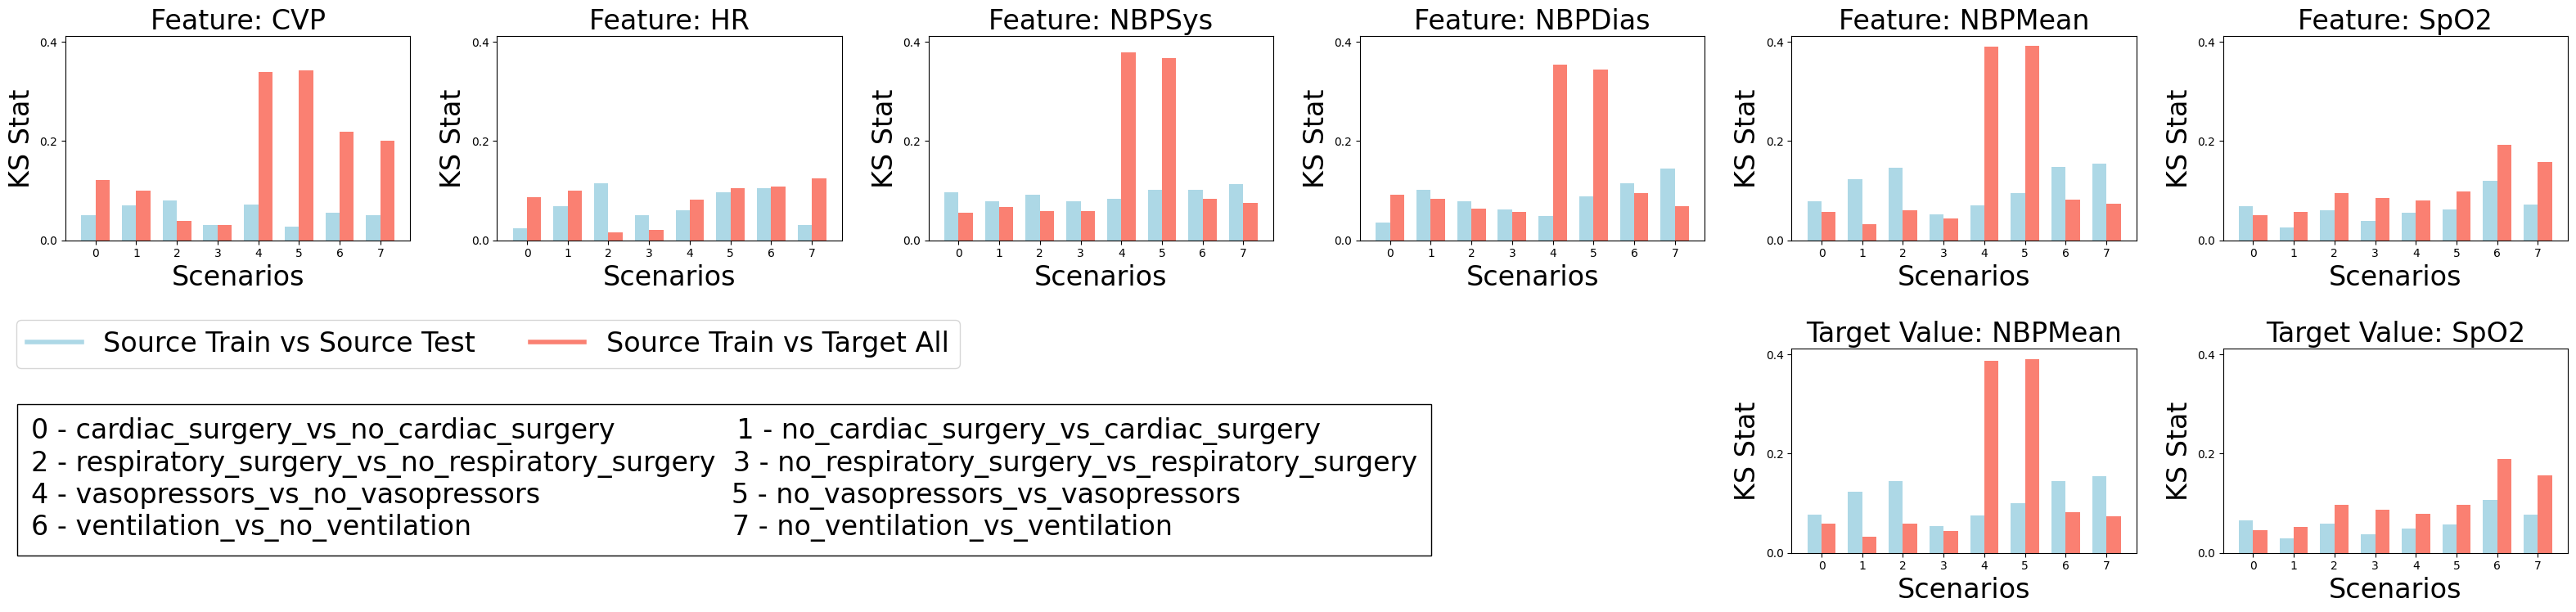

In [20]:
all_distances_by_scenario = visualize_distribution_shifts_overall("ks_2samp")

In [21]:
all_distances_by_scenario["difference_source_train_vs_source_test_feature_vs_label_NBPMean"] = all_distances_by_scenario["source_train_vs_source_test_label_NBPMean"] - all_distances_by_scenario["source_train_vs_source_test_NBPMean"]
print("max difference NBPMean source train vs source test:", all_distances_by_scenario["difference_source_train_vs_source_test_feature_vs_label_NBPMean"].max())
print("min difference NBPMean source train vs source test:", all_distances_by_scenario["difference_source_train_vs_source_test_feature_vs_label_NBPMean"].min())
all_distances_by_scenario["difference_source_train_vs_target_all_feature_vs_label_NBPMean"] = all_distances_by_scenario["source_train_vs_target_all_label_NBPMean"] - all_distances_by_scenario["source_train_vs_target_all_NBPMean"]
print("max difference NBPMean source train vs target all:", all_distances_by_scenario["difference_source_train_vs_target_all_feature_vs_label_NBPMean"].max())
print("min difference NBPMean source train vs target all:", all_distances_by_scenario["difference_source_train_vs_target_all_feature_vs_label_NBPMean"].min())


all_distances_by_scenario["difference_source_train_vs_source_test_vs_source_train_vs_target_SpO2"] = all_distances_by_scenario["source_train_vs_target_all_label_SpO2"] - all_distances_by_scenario["source_train_vs_source_test_SpO2"]
print("max difference SpO2 source train vs source test:", all_distances_by_scenario["difference_source_train_vs_source_test_vs_source_train_vs_target_SpO2"].max())
print("min difference SpO2 source train vs source test:", all_distances_by_scenario["difference_source_train_vs_source_test_vs_source_train_vs_target_SpO2"].min())
all_distances_by_scenario["difference_source_train_vs_target_all_vs_source_train_vs_target_SpO2"] = all_distances_by_scenario["source_train_vs_target_all_label_SpO2"] - all_distances_by_scenario["source_train_vs_target_all_SpO2"]
print("max difference SpO2 source train vs target all:", all_distances_by_scenario["difference_source_train_vs_target_all_vs_source_train_vs_target_SpO2"].max())
print("min difference SpO2 source train vs target all:", all_distances_by_scenario["difference_source_train_vs_target_all_vs_source_train_vs_target_SpO2"].min())

max difference NBPMean source train vs source test: 0.004278111694294498
min difference NBPMean source train vs source test: -0.0032179478890261015
max difference NBPMean source train vs target all: 0.0014524632977922017
min difference NBPMean source train vs target all: -0.00329012961402142
max difference SpO2 source train vs source test: 0.08359303934030089
min difference SpO2 source train vs source test: -0.023242326115086004
max difference SpO2 source train vs target all: 0.0017064812798218004
min difference SpO2 source train vs target all: -0.0043217258712984


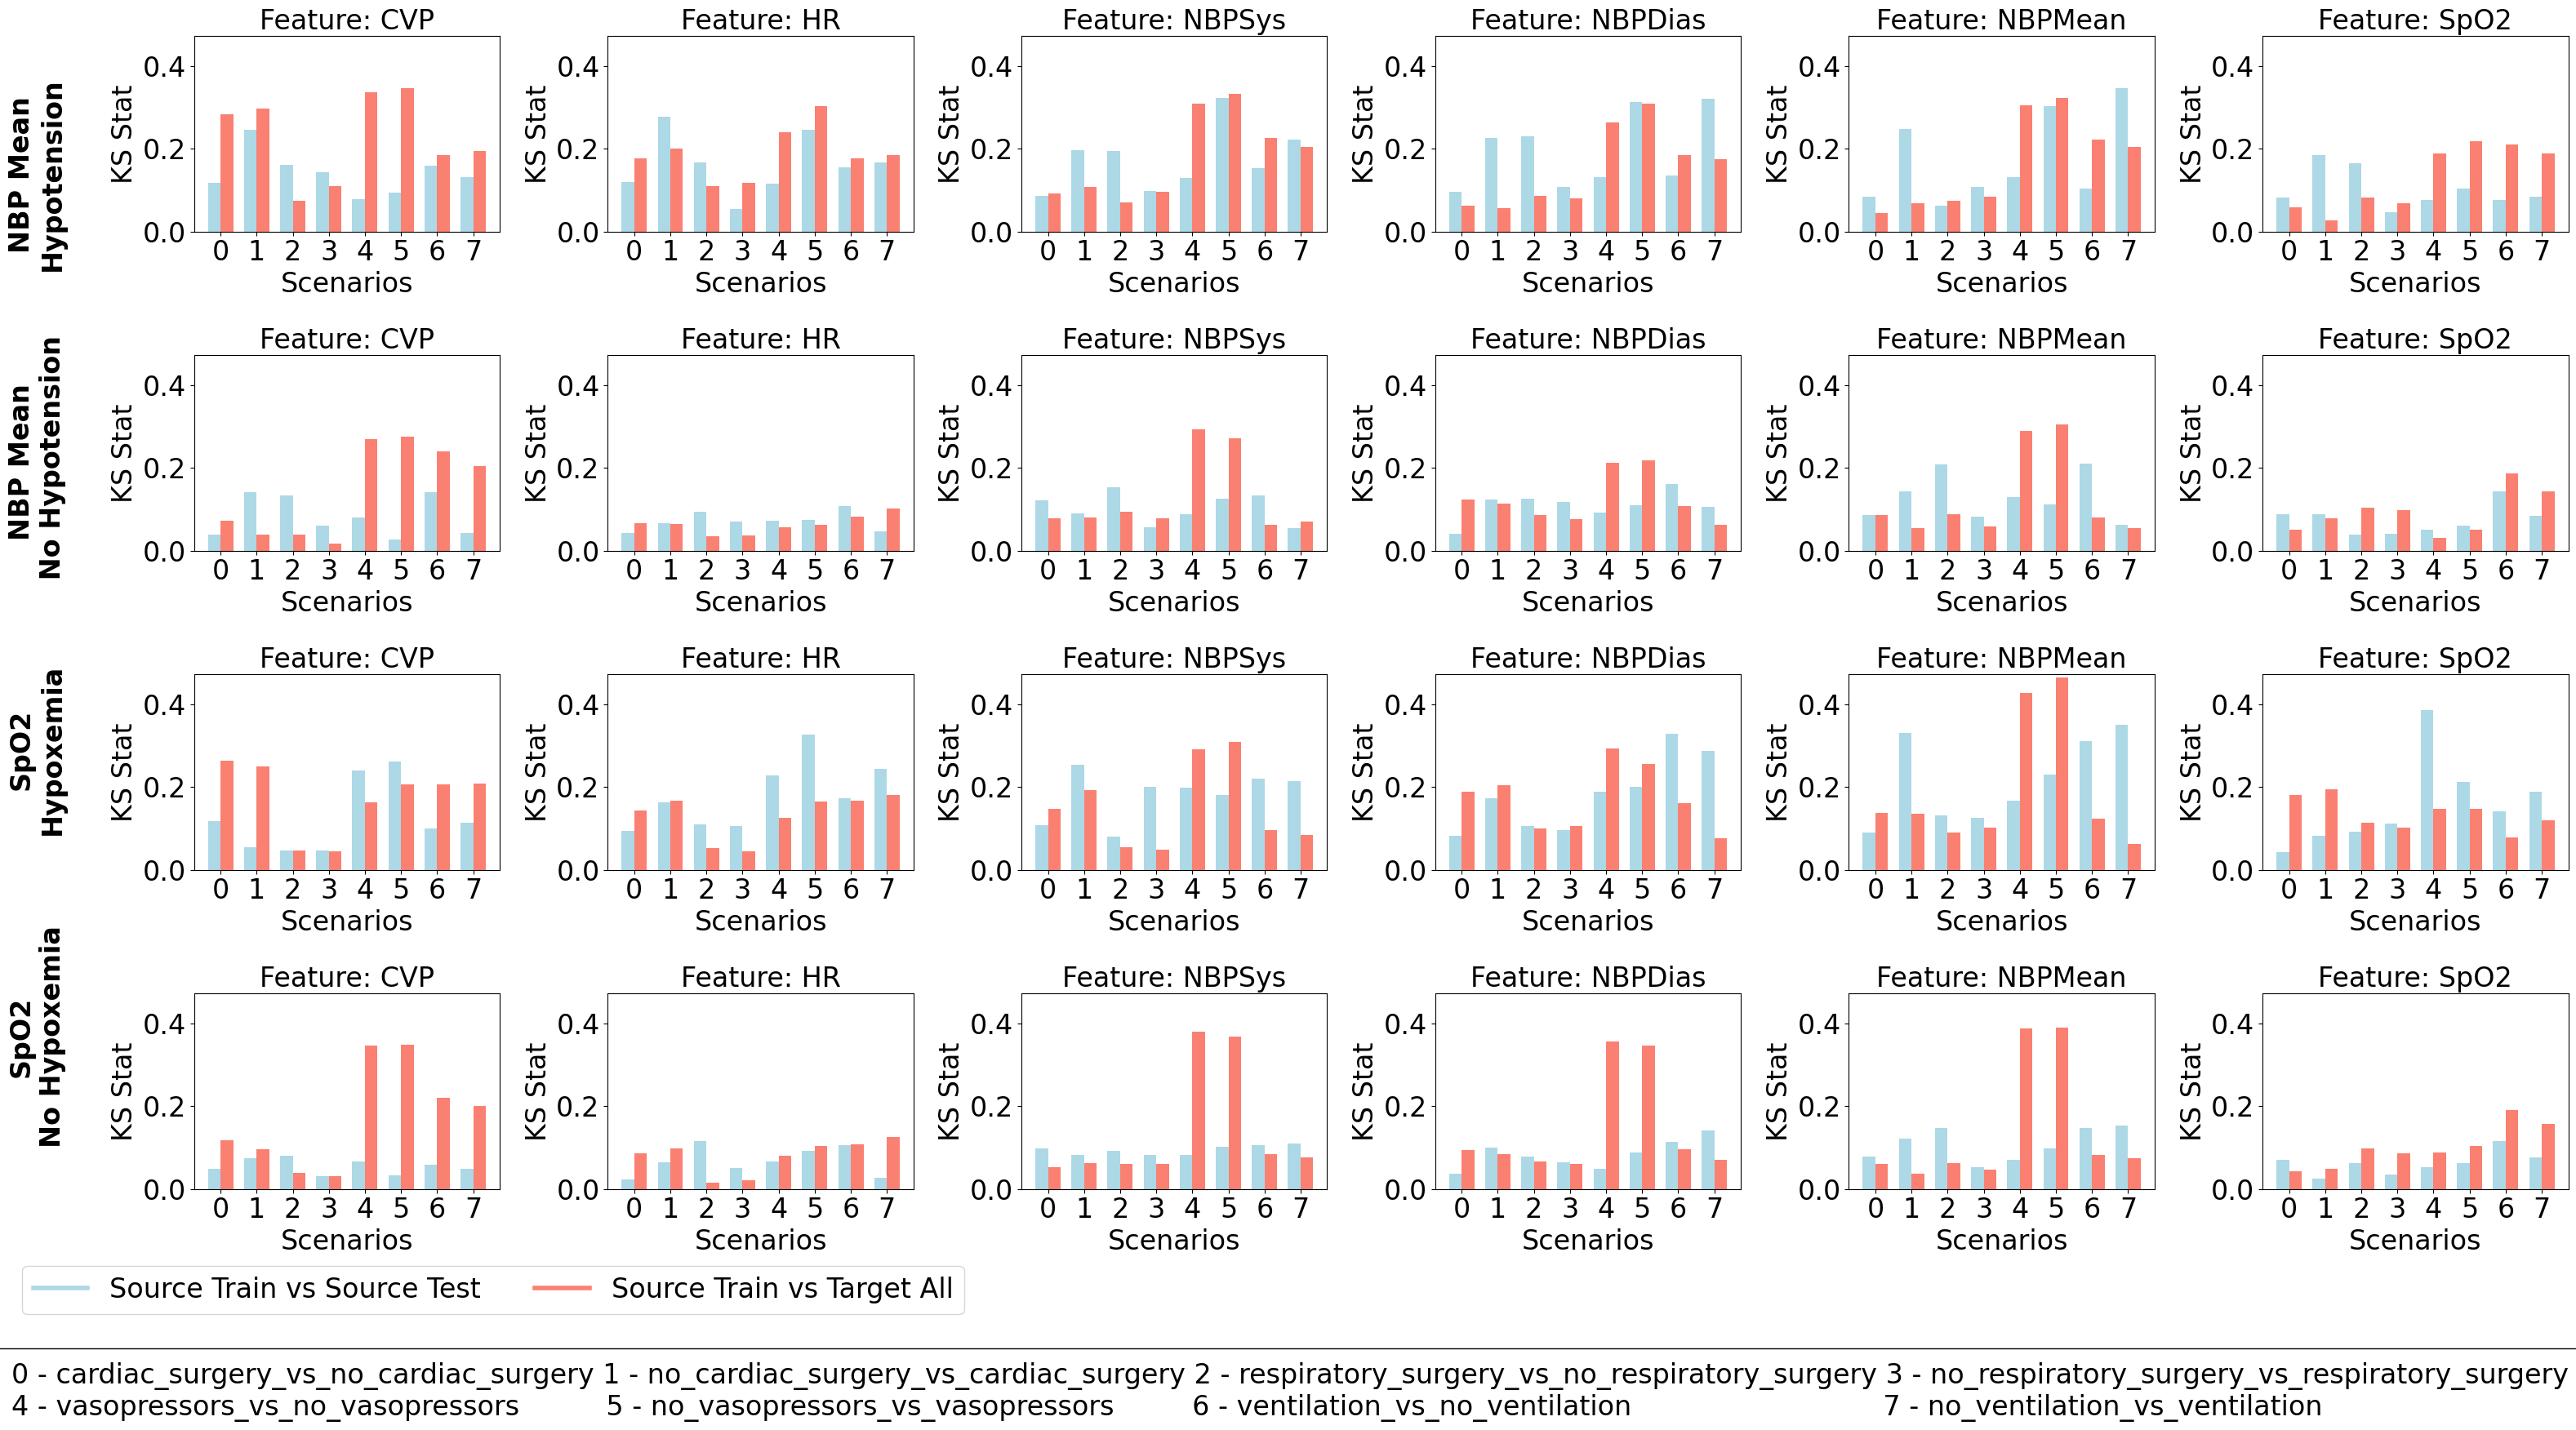

In [22]:
all_distances_by_scenario_classwise = visualize_distribution_shifts_classwise("ks_2samp")

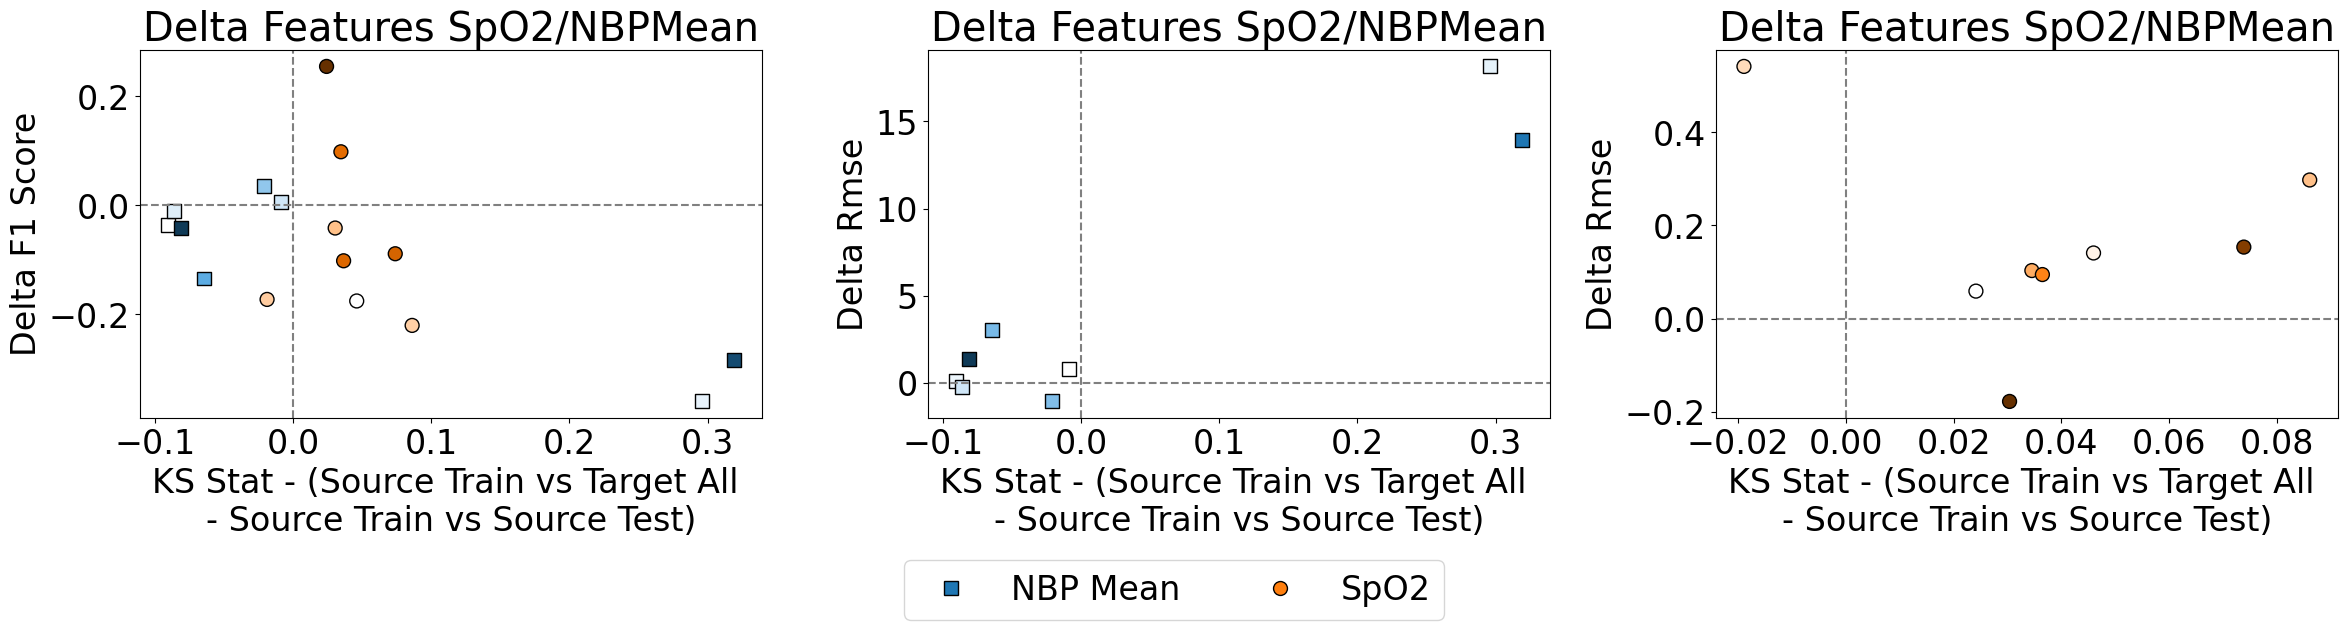

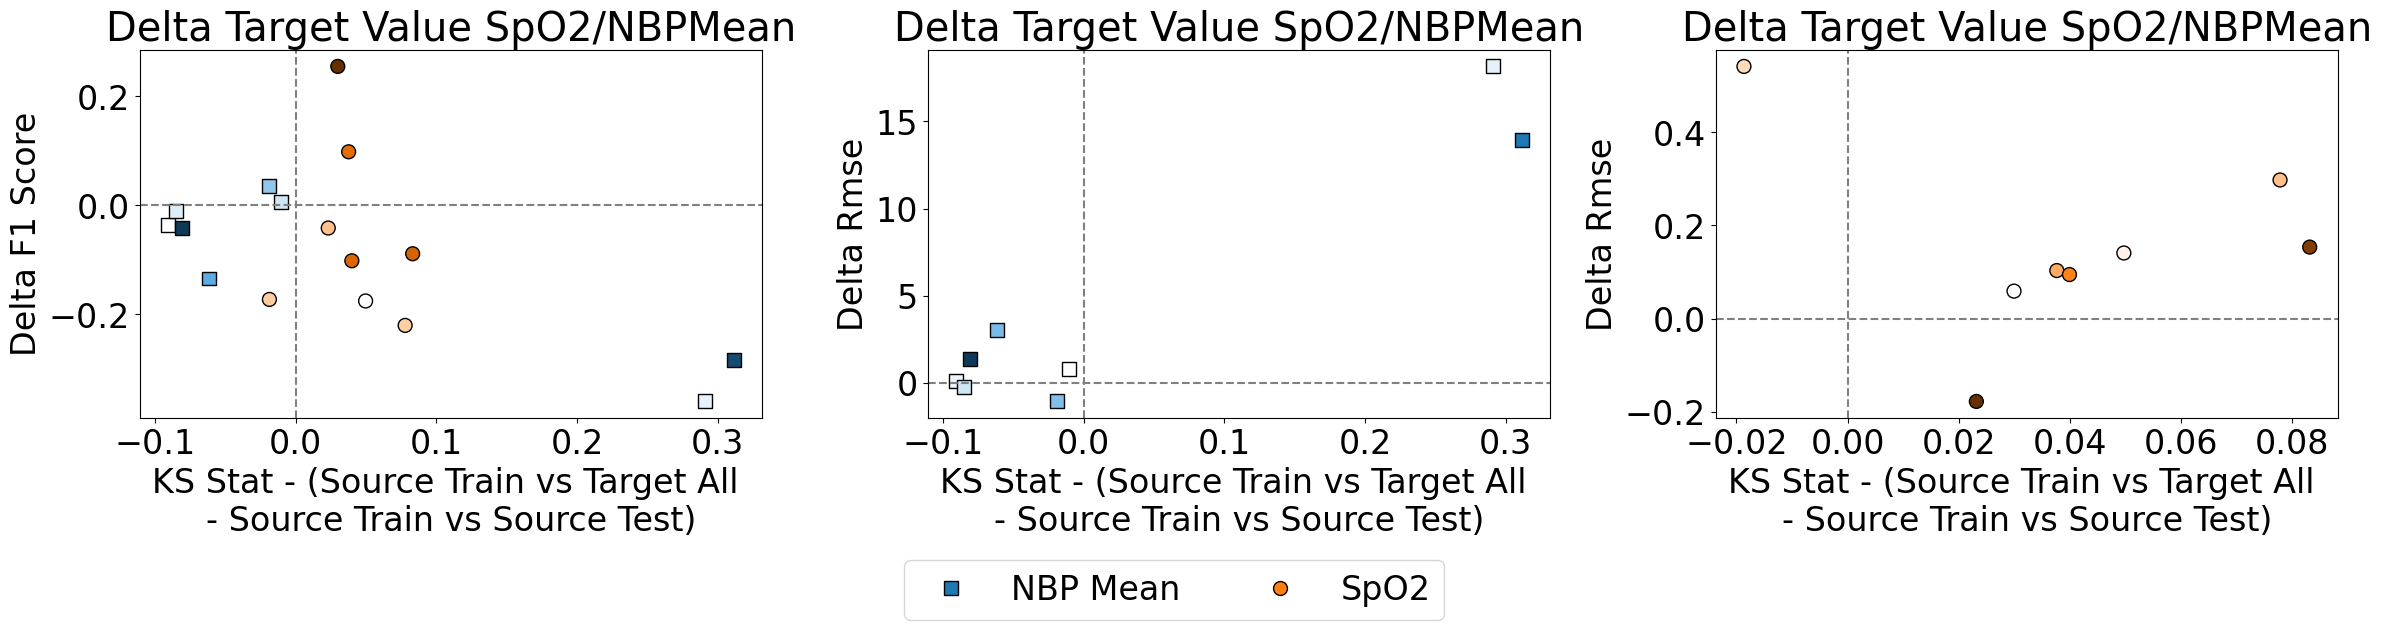

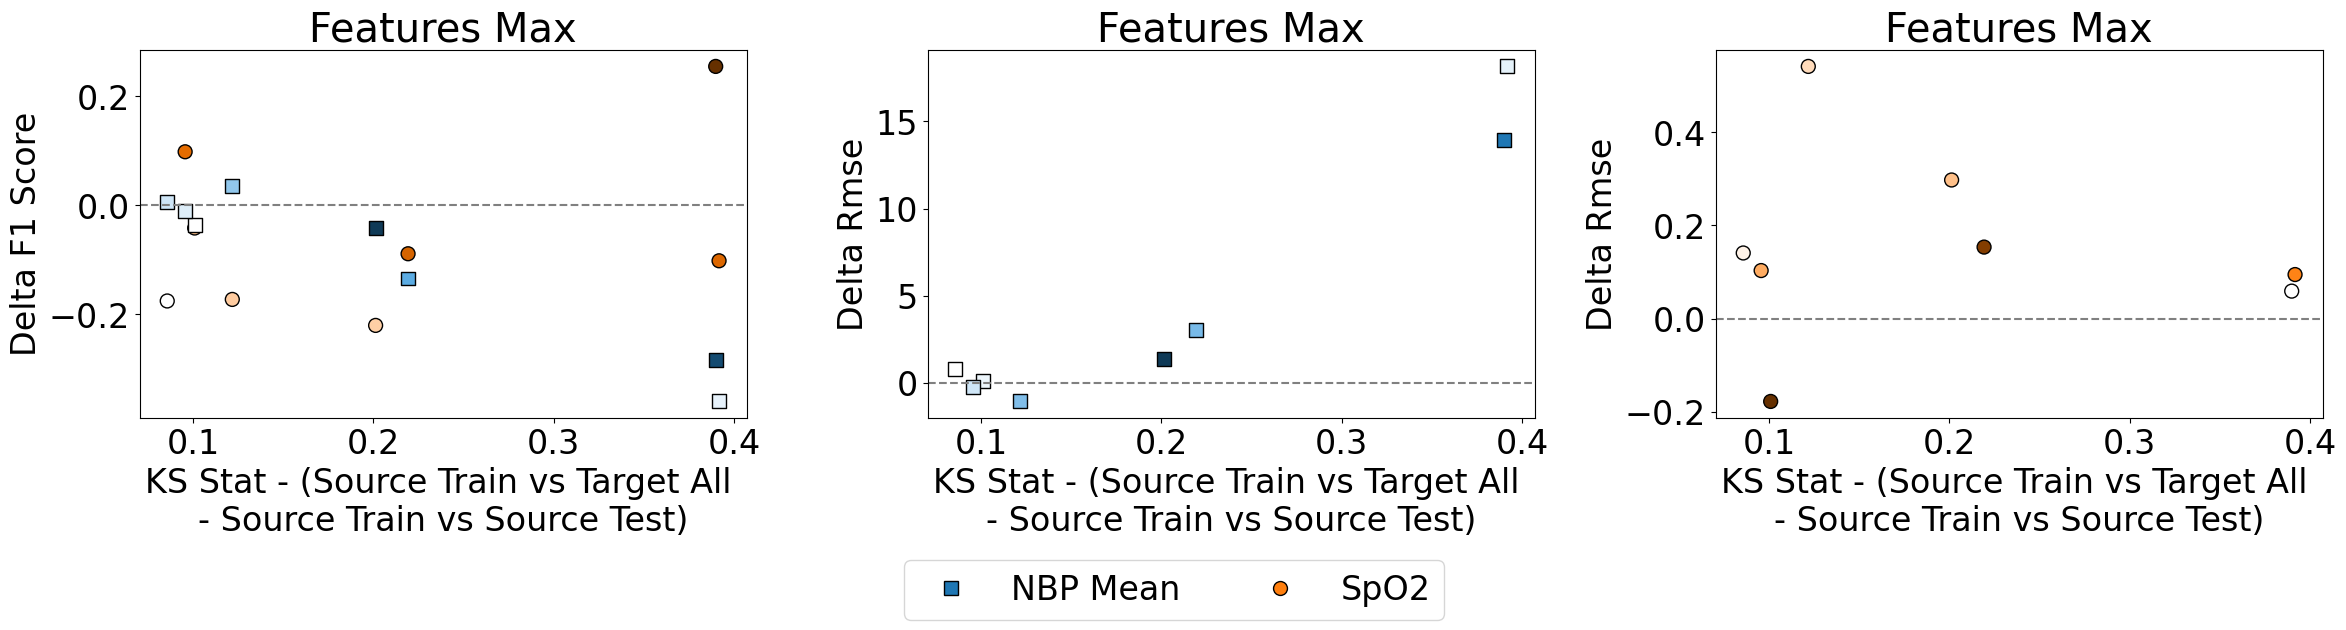

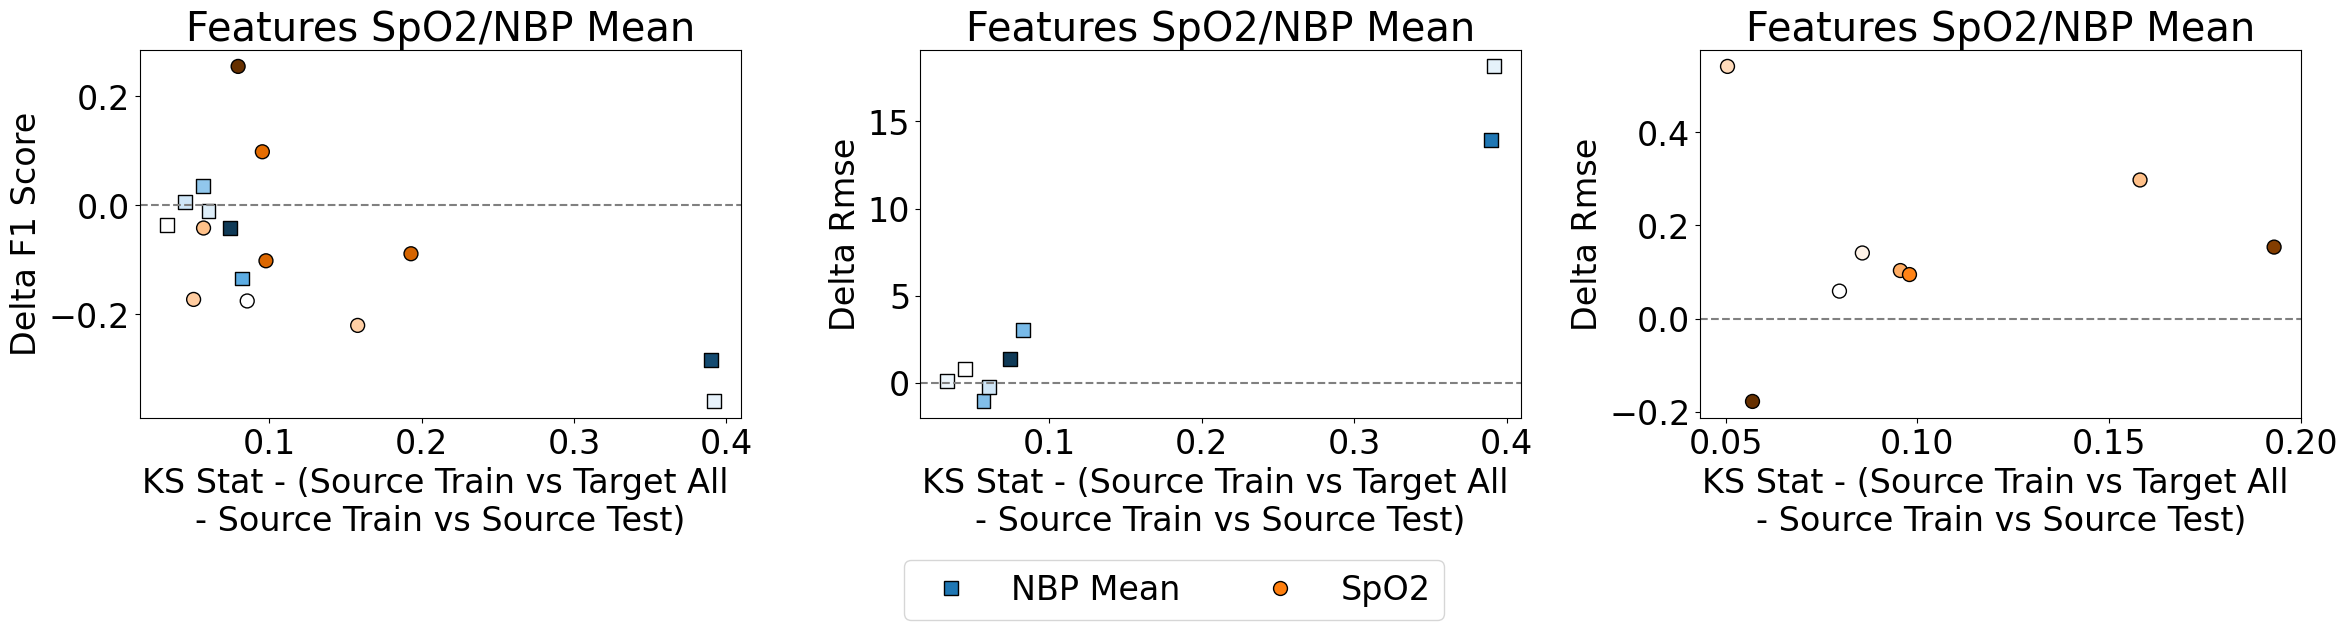

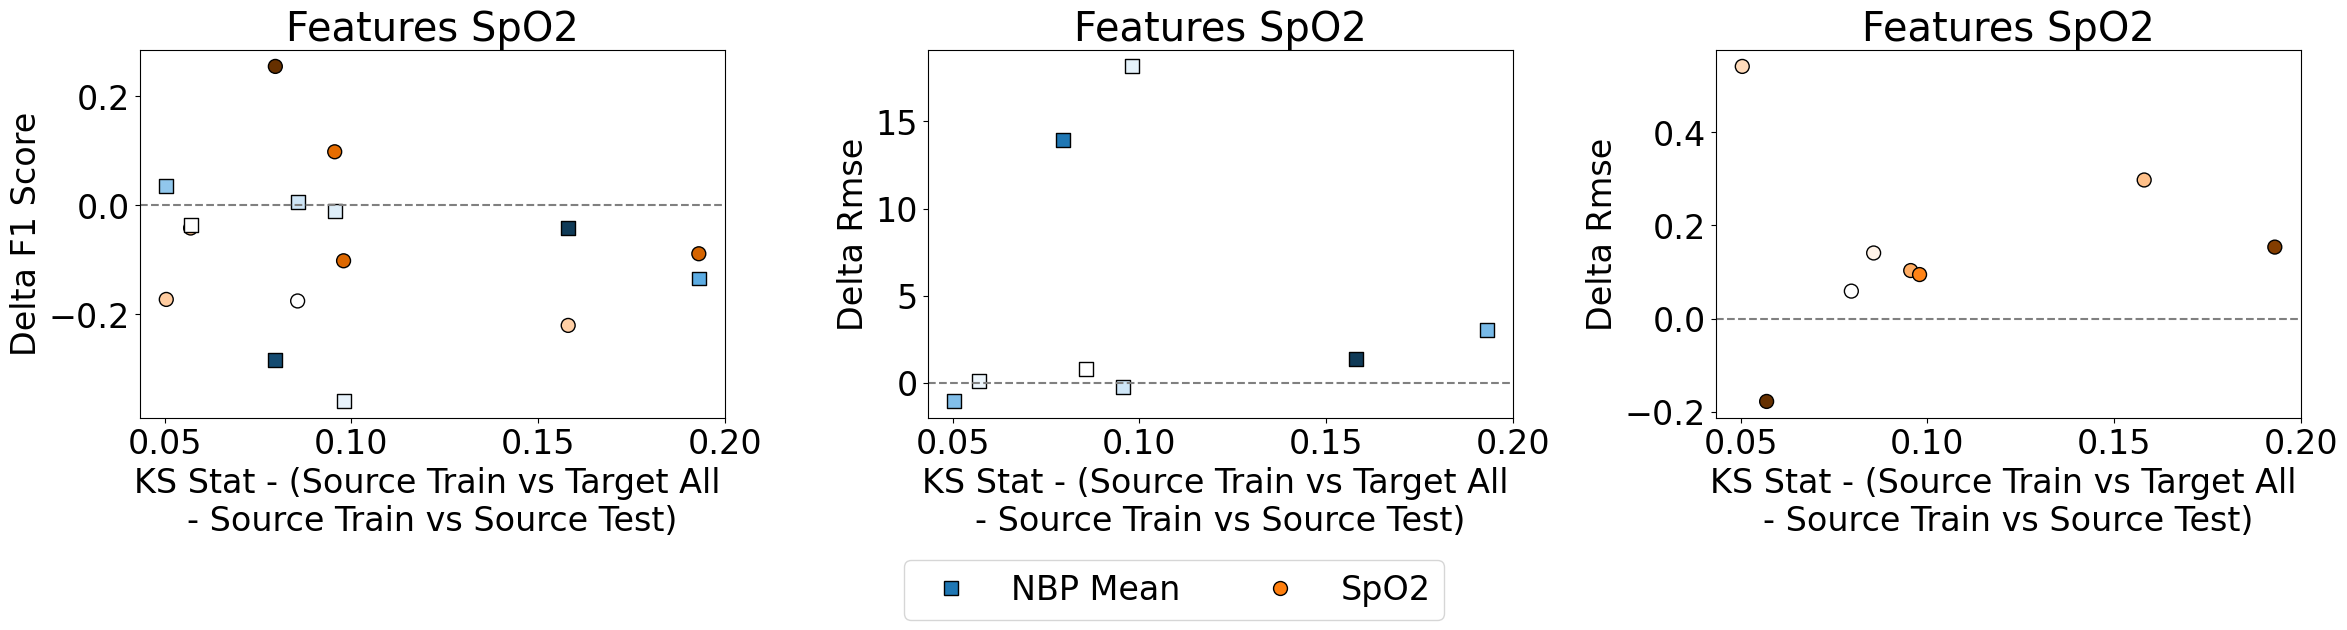

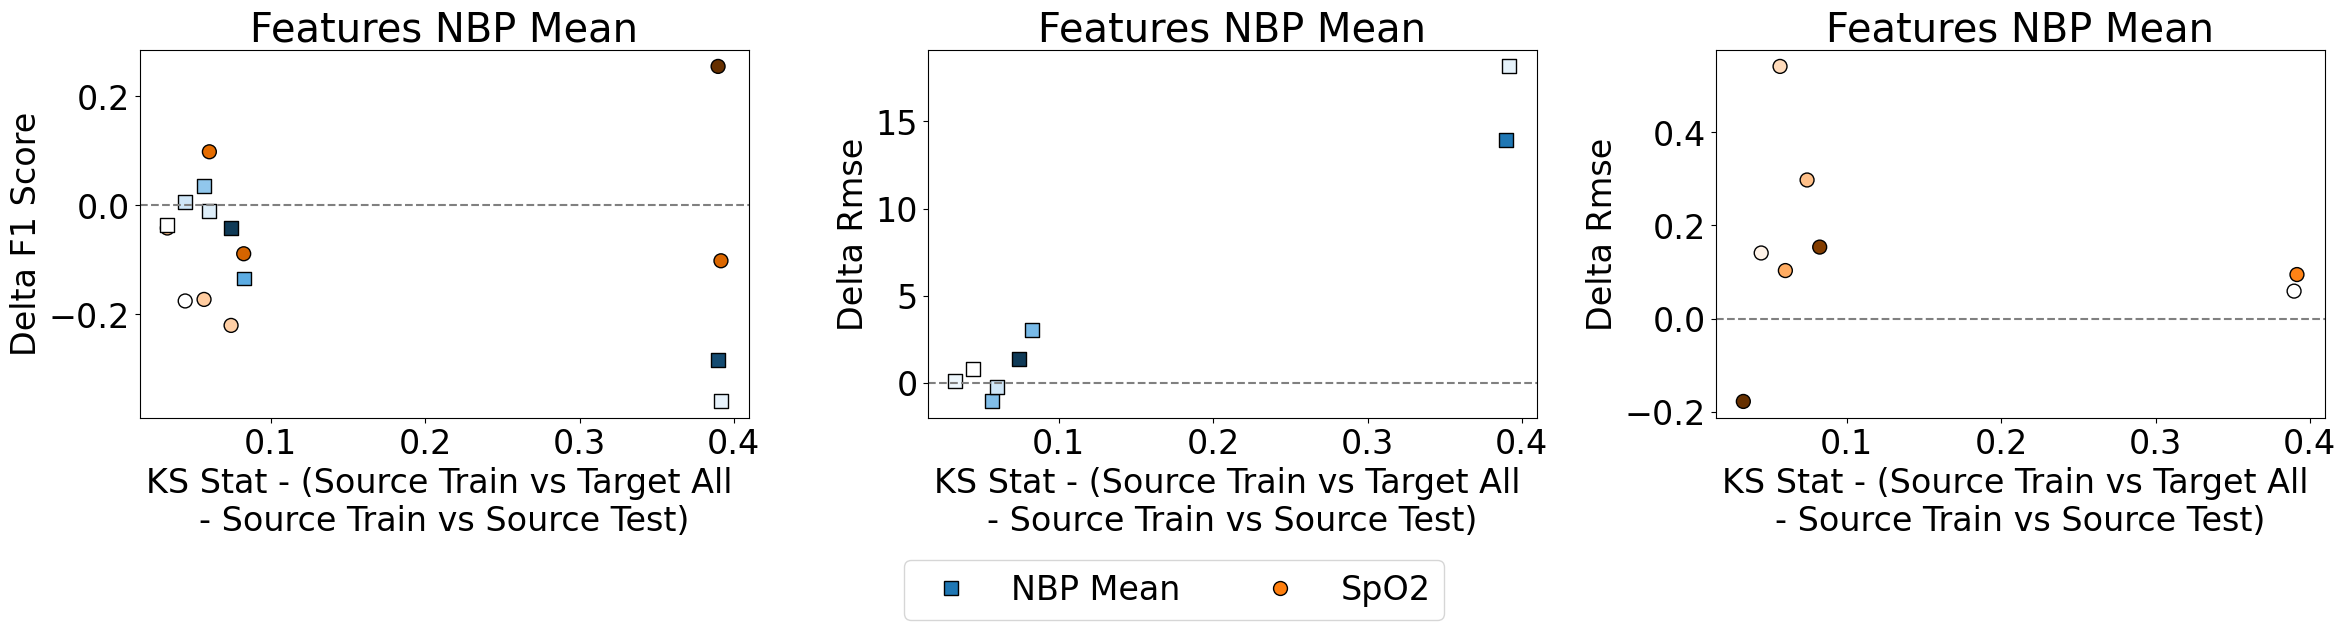

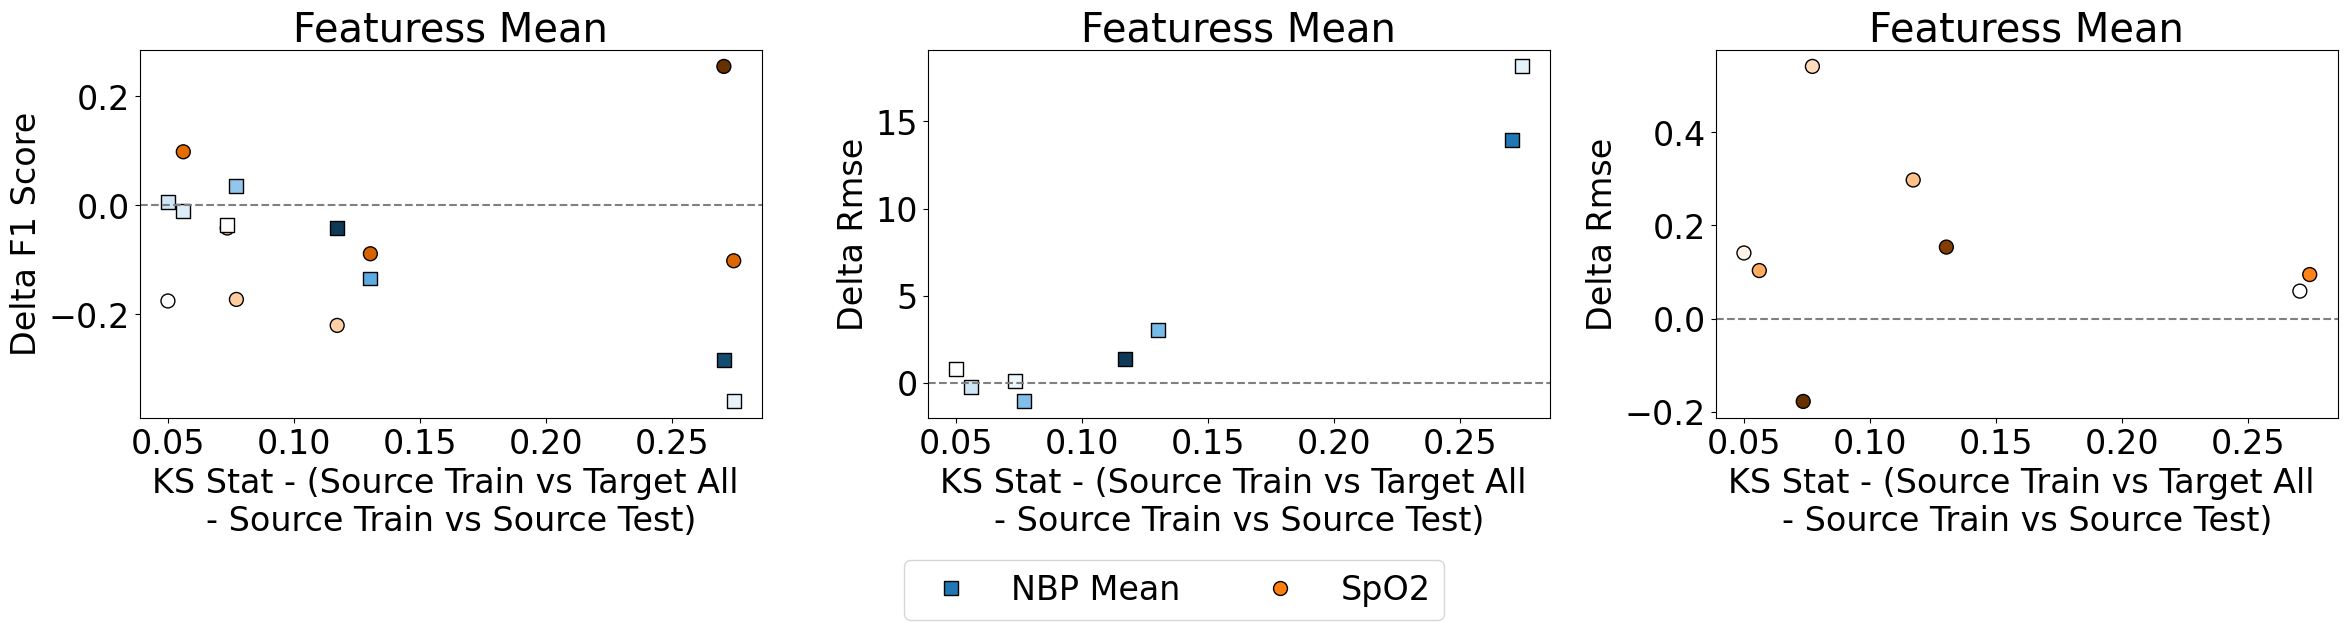

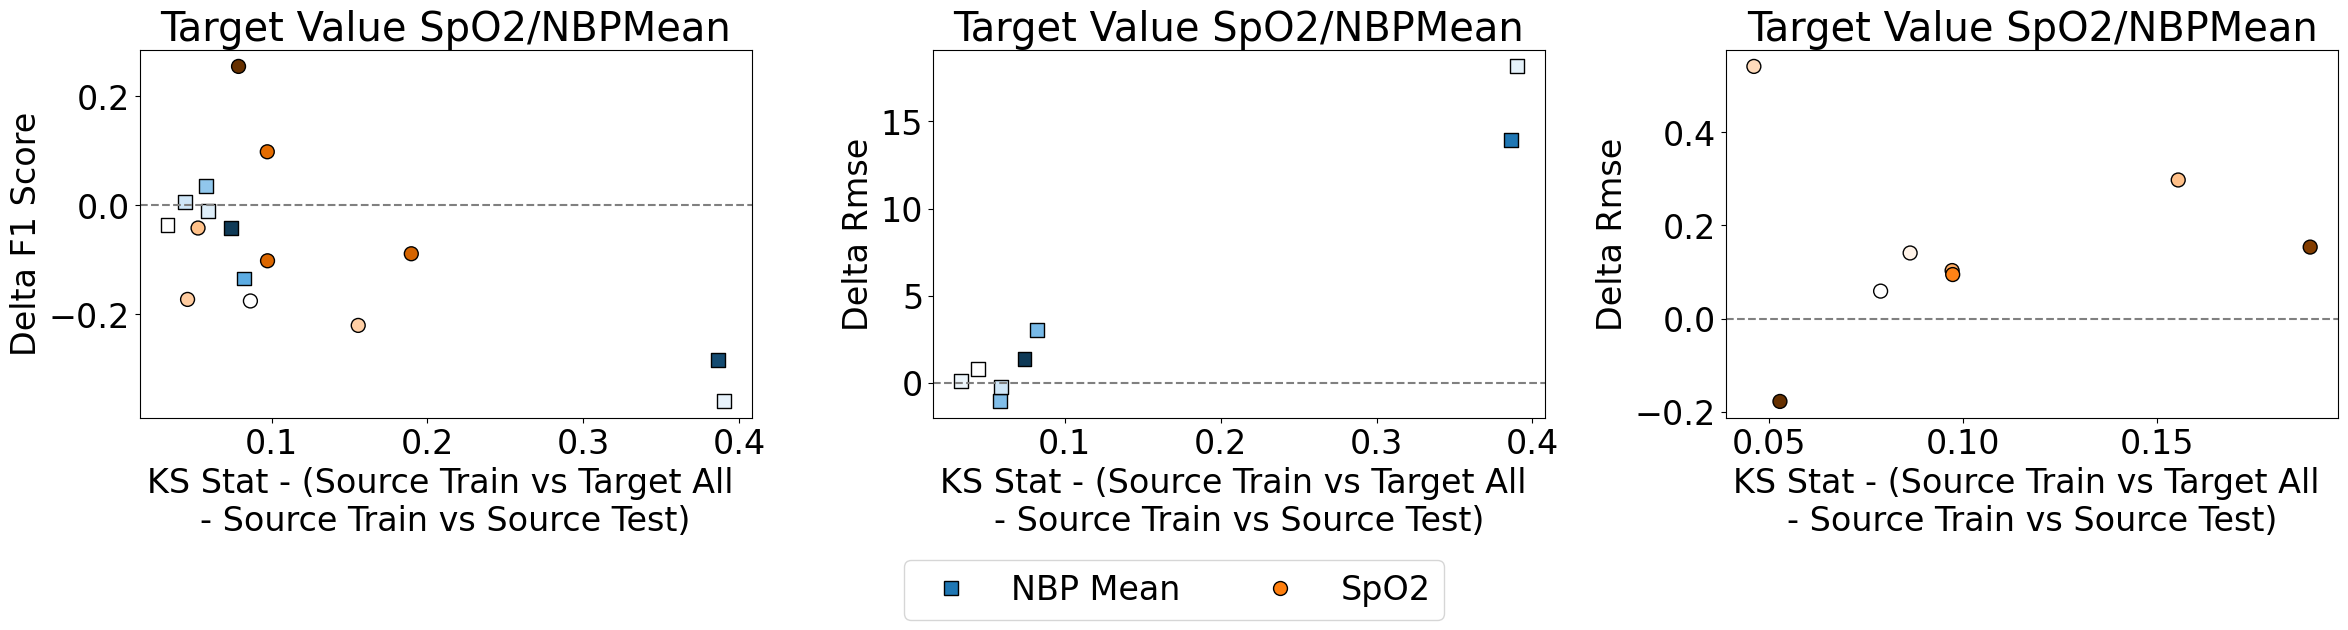

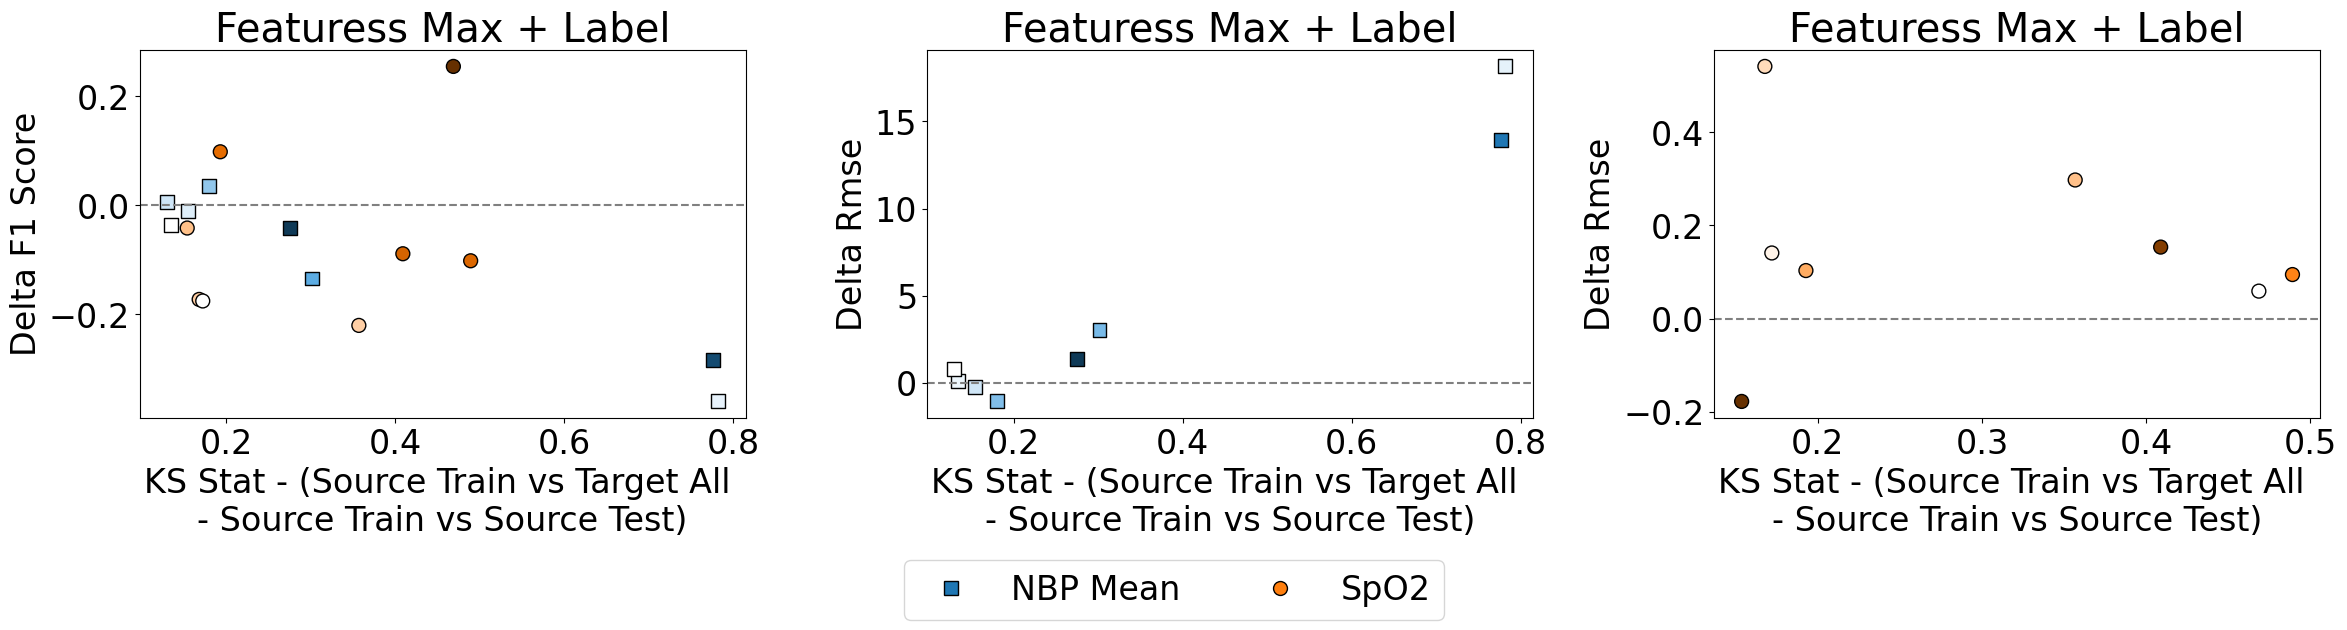

In [23]:
merged_results_and_distances = load_distribution_shift_performance_overall("ks_2samp")
merged_results_and_distances.to_csv("./results/merged_results_and_distances_overall_ks_2samp.csv", index=False)
visualize_source_train_vs_target_all_relationships(merged_results_and_distances)

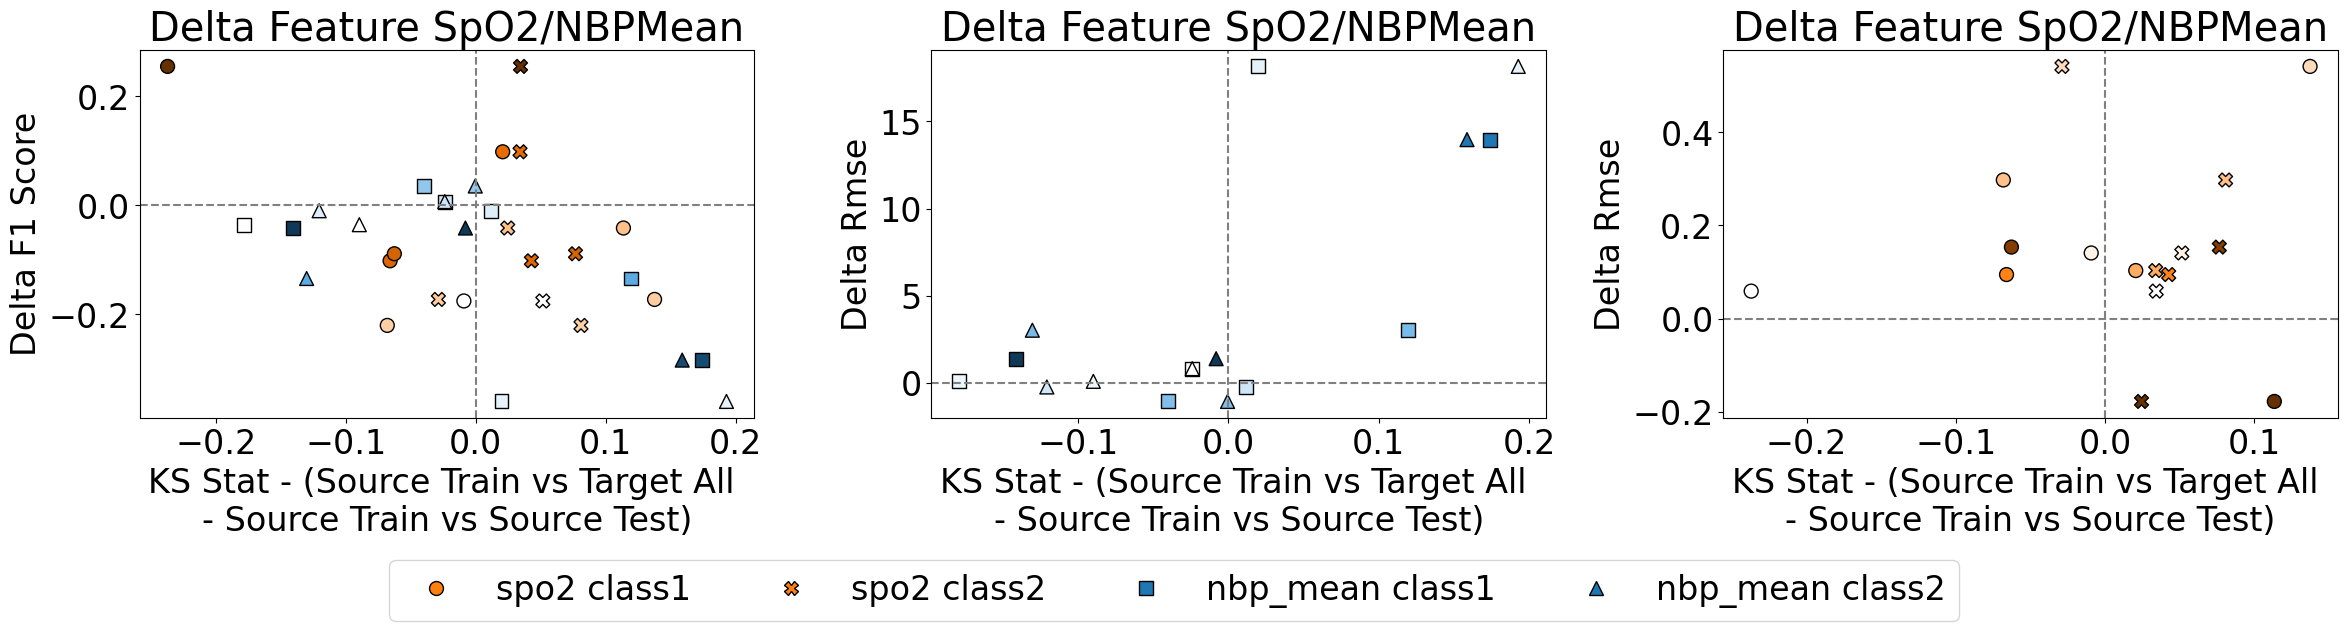

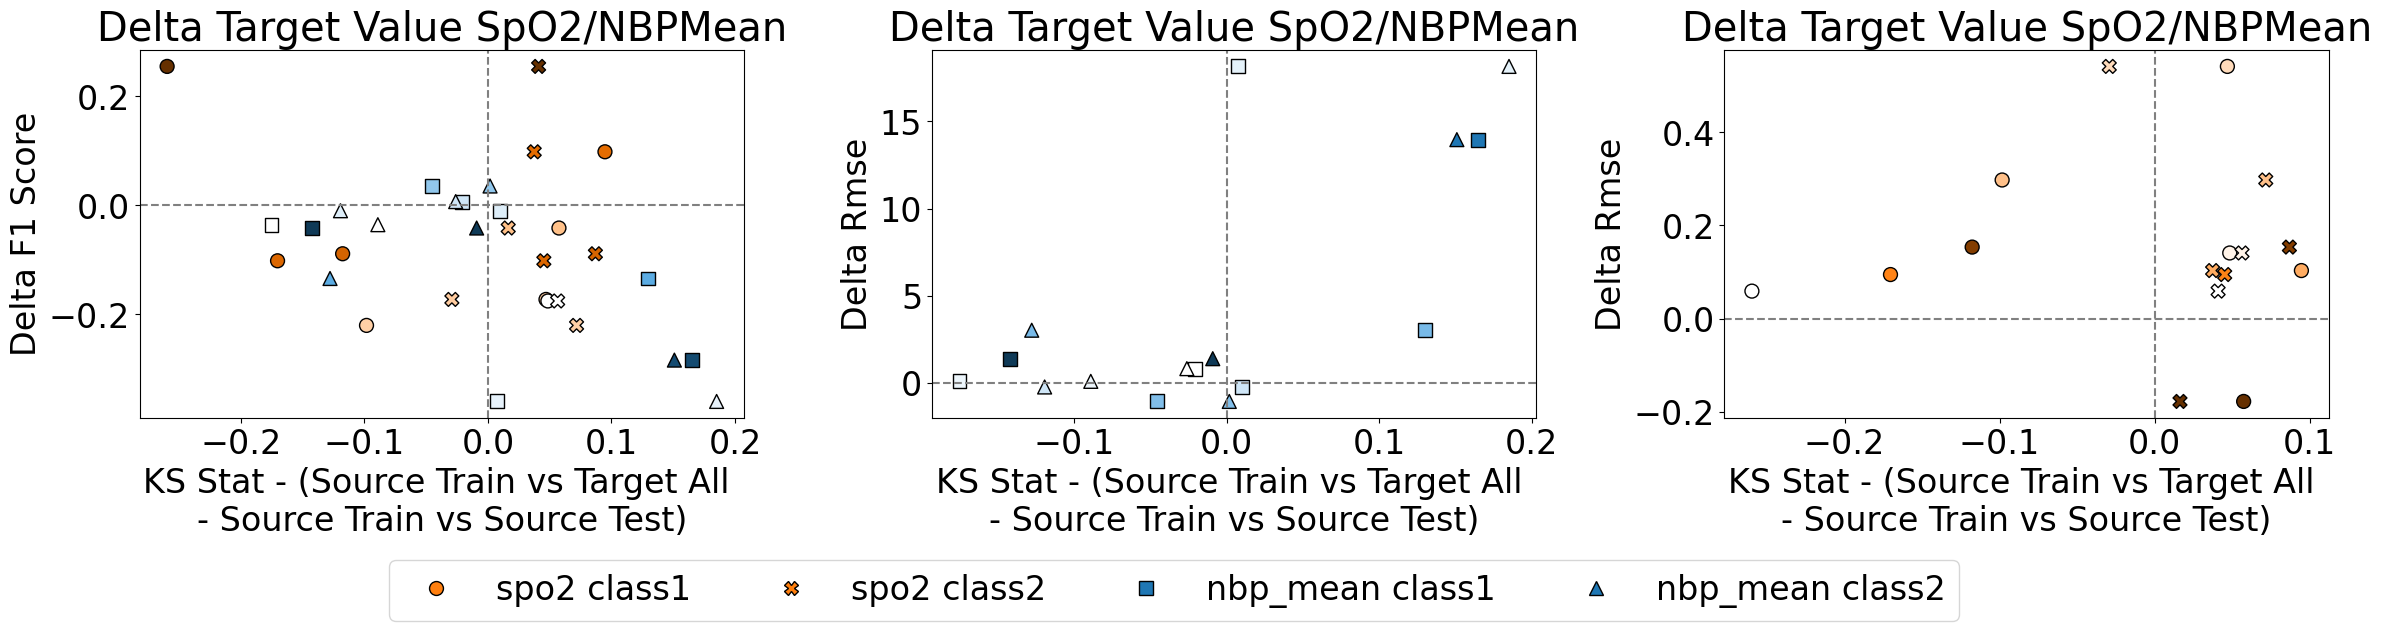

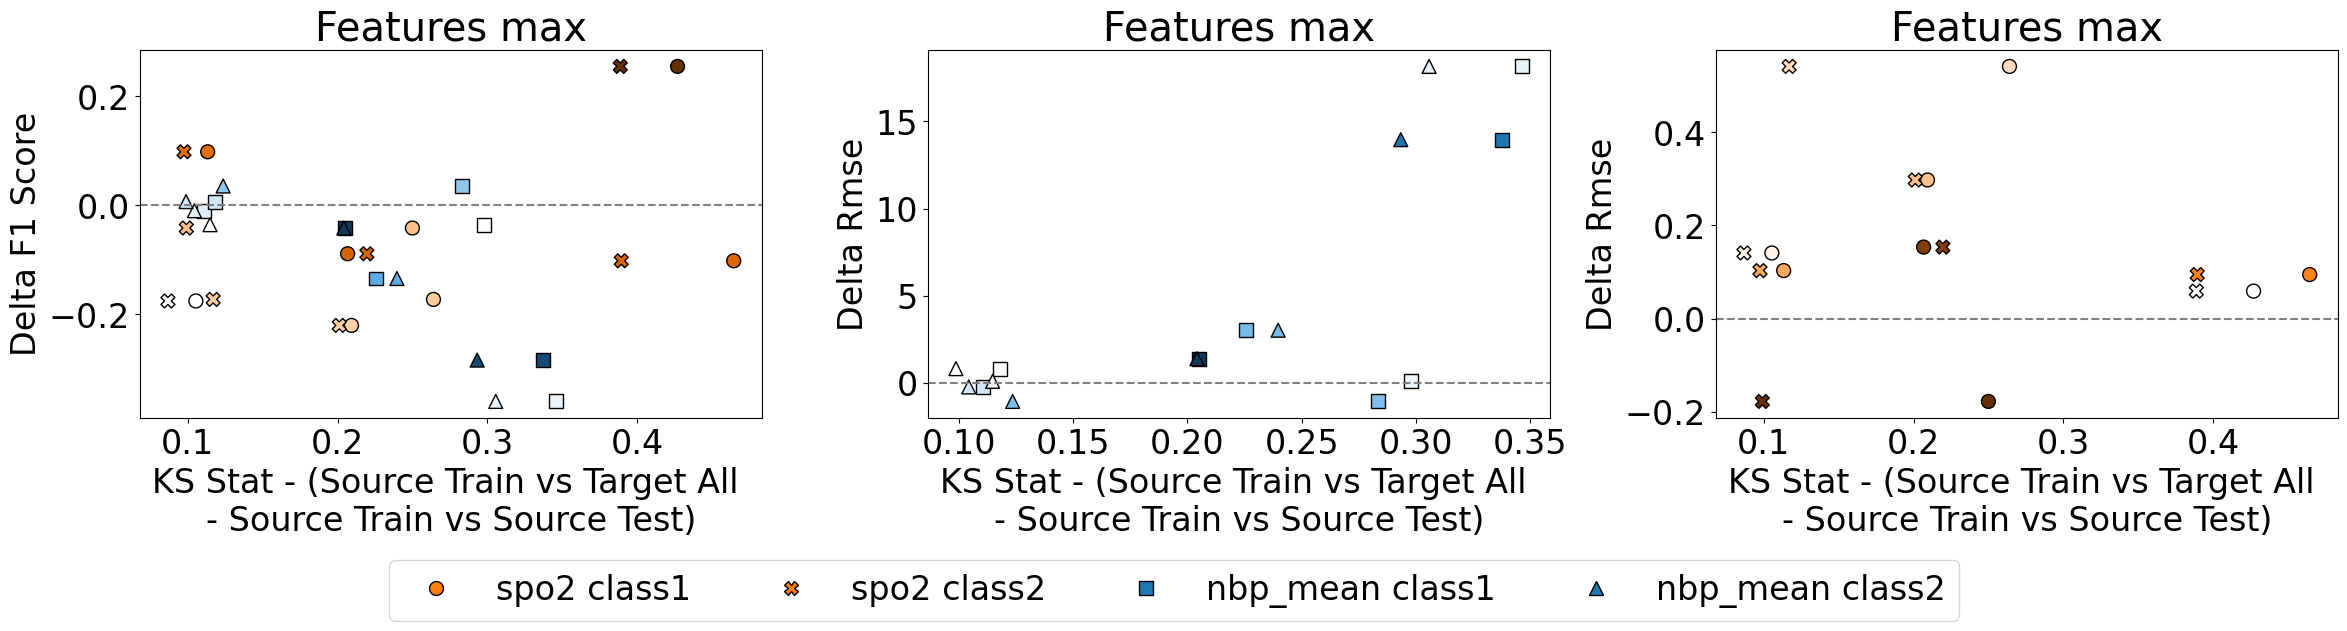

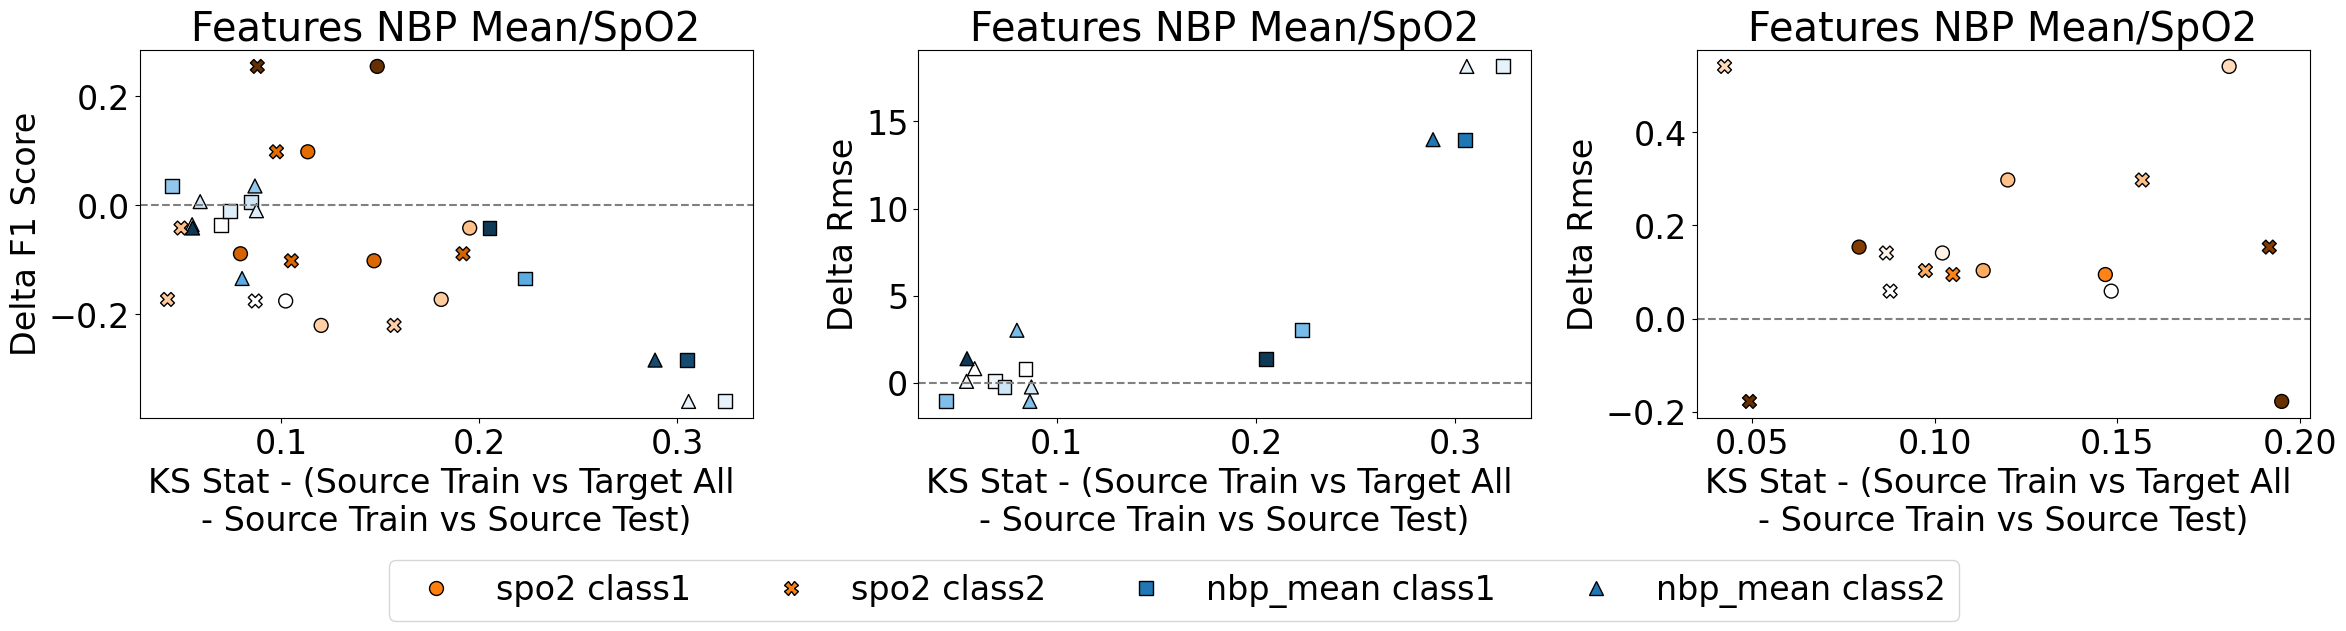

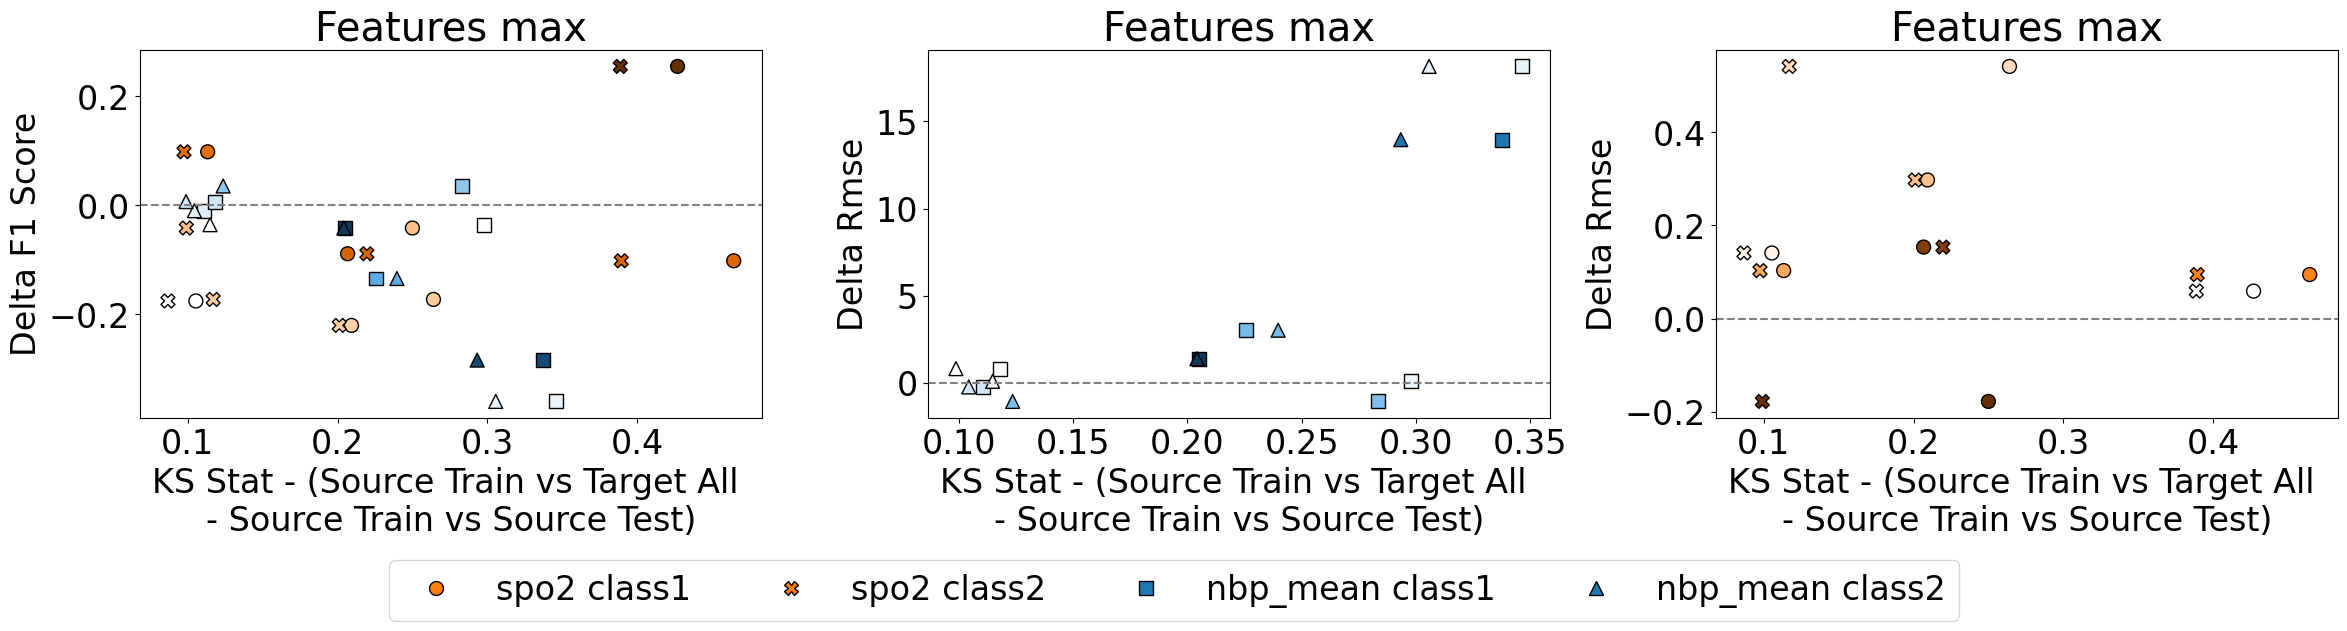

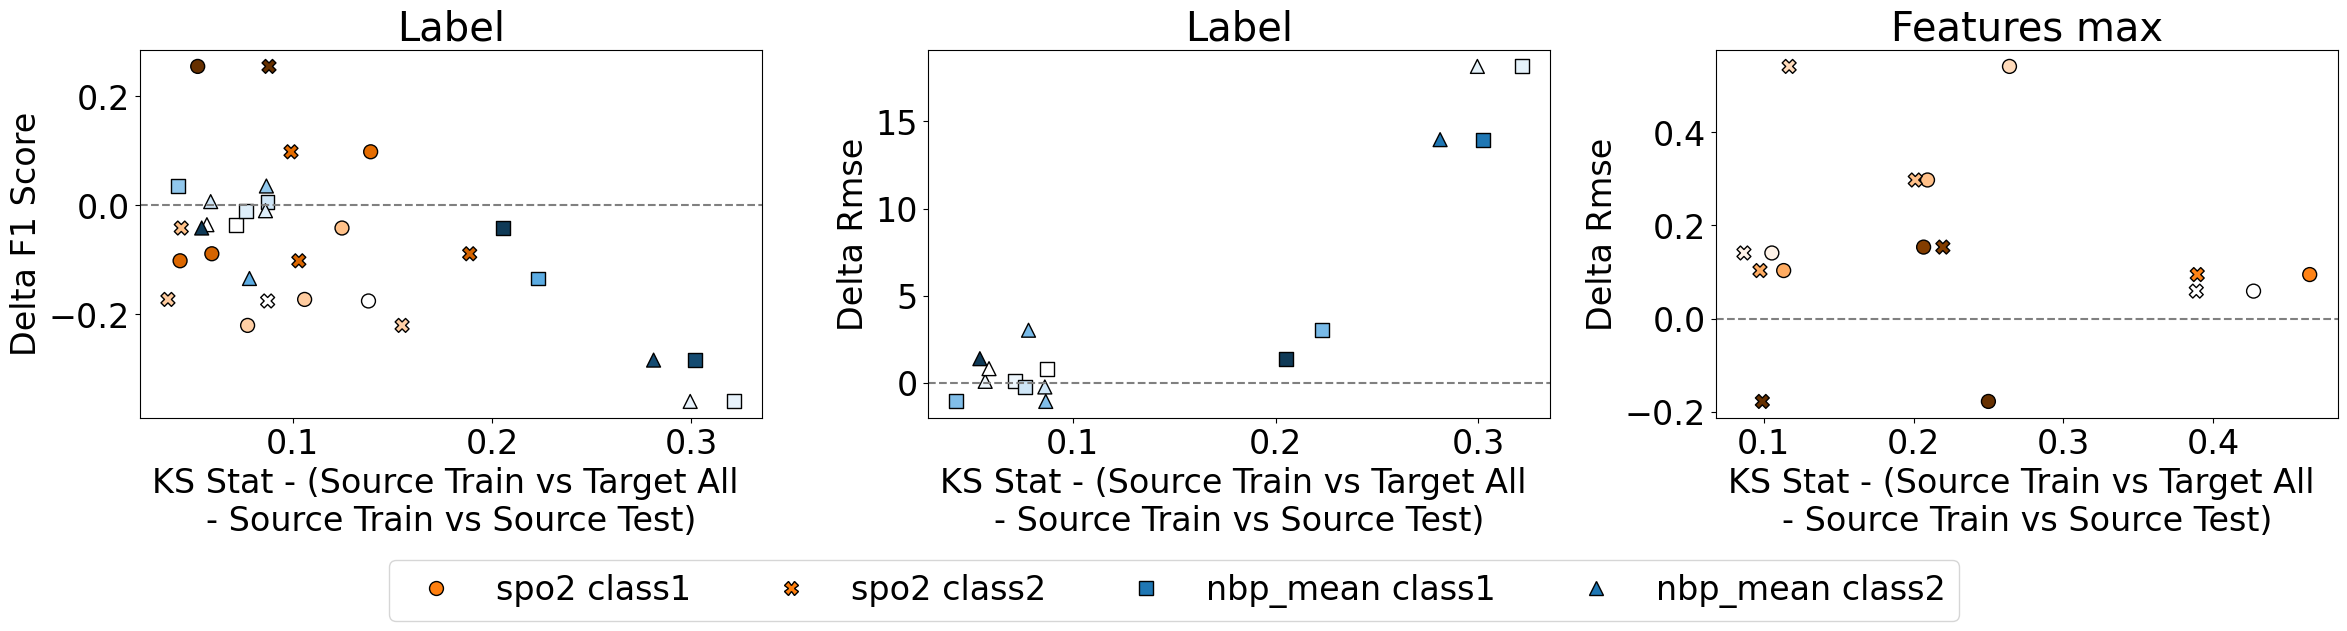

In [24]:
merged_results_and_distances = load_distribution_shift_performance_classwise("ks_2samp")
merged_results_and_distances.to_csv("./results/merged_results_and_distances_classwise_ks_2samp.csv", index=False)
visualize_source_train_vs_target_all_relationships_classwise(merged_results_and_distances)


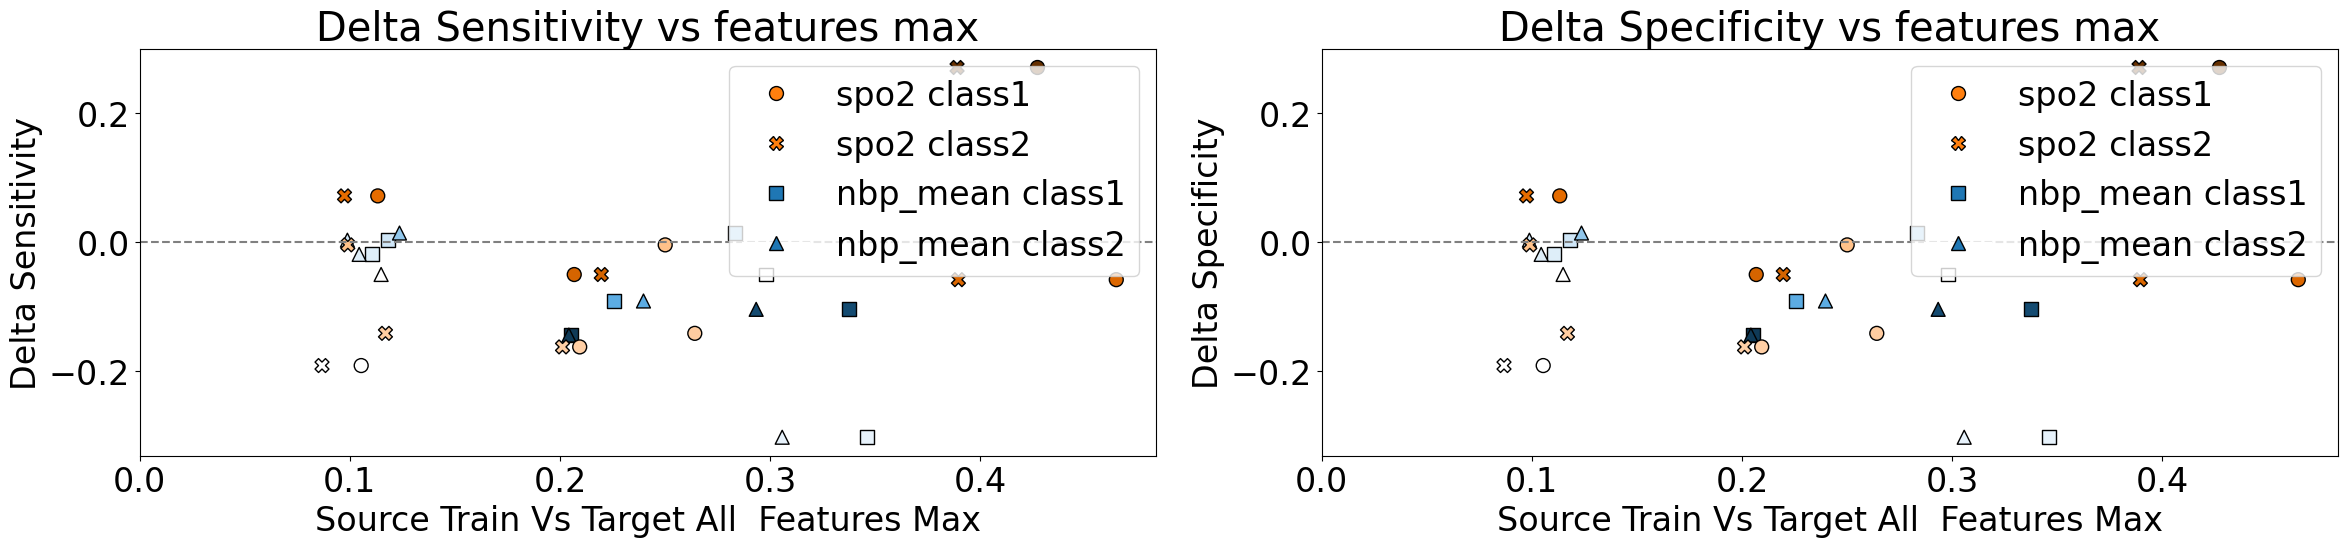

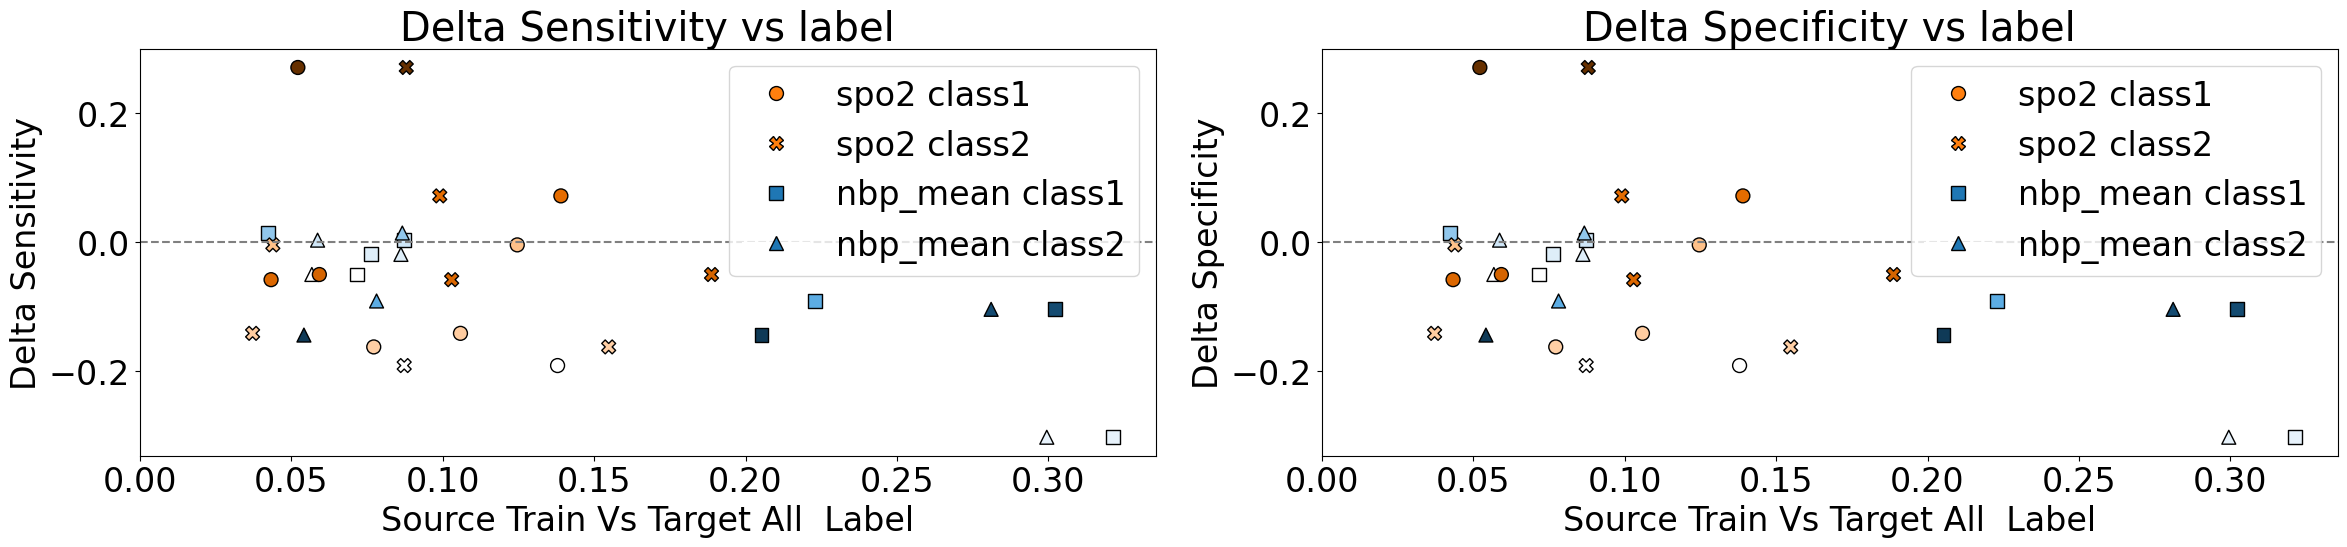

In [25]:
visualize_source_train_vs_target_all_relationships_classwise_sensitivity_specificity(merged_results_and_distances)

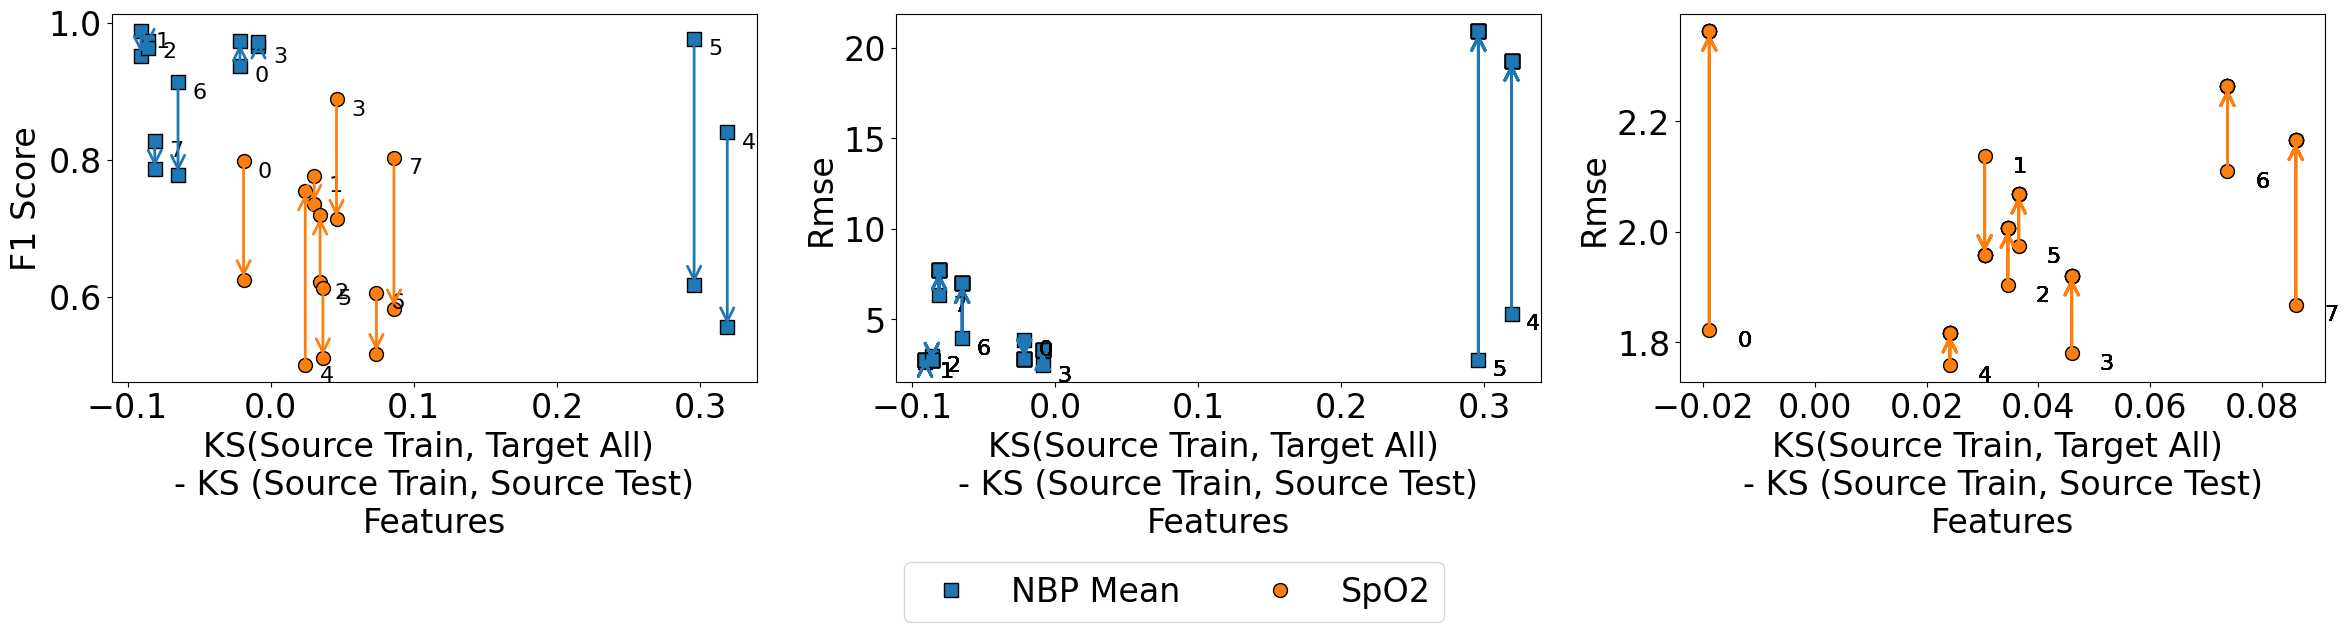

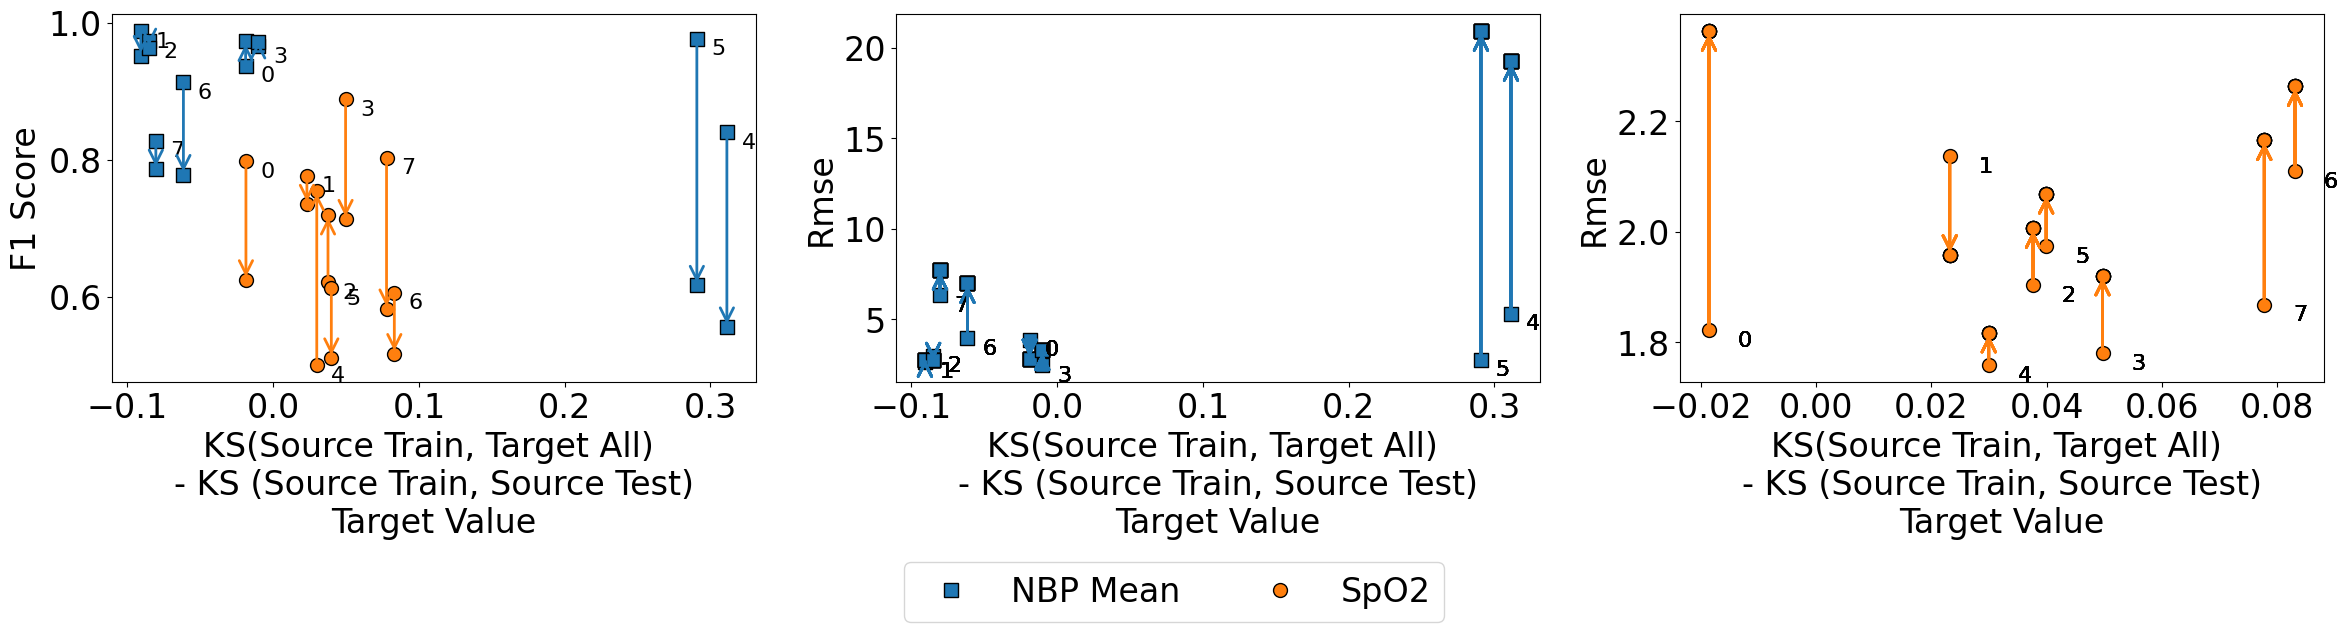

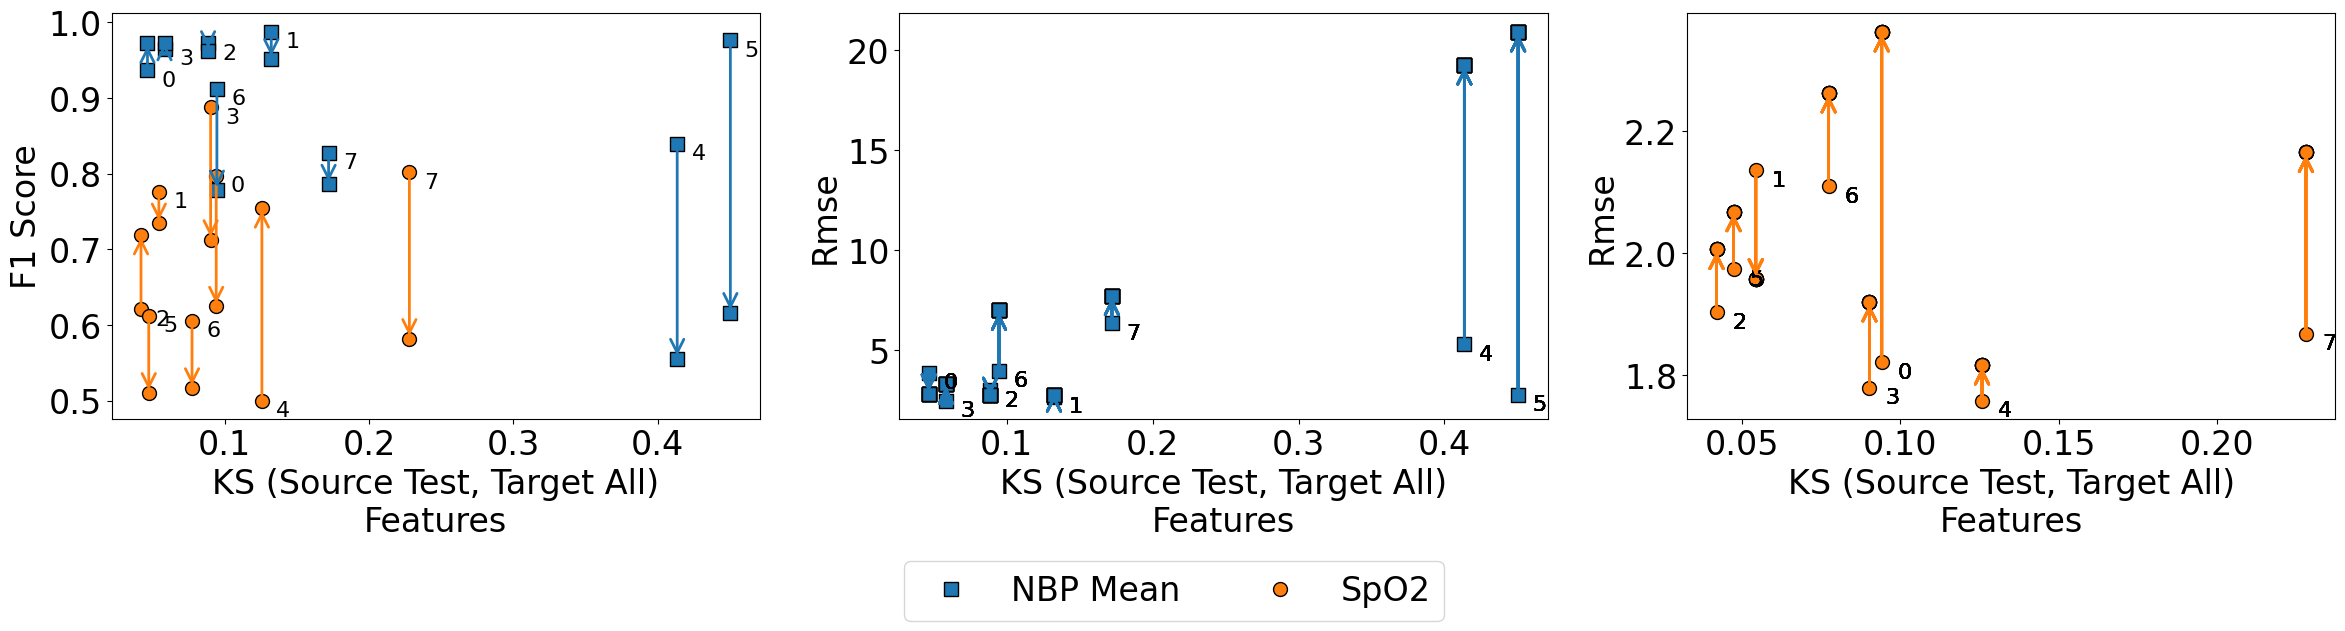

In [26]:
merged_results_and_distances = load_distribution_shift_performance_overall("ks_2samp")
merged_results_and_distances.to_csv("./results/merged_results_and_distances_overall_ks_2samp.csv", index=False)
visualize_source_train_vs_target_all_relationships_absolute_performance(merged_results_and_distances)

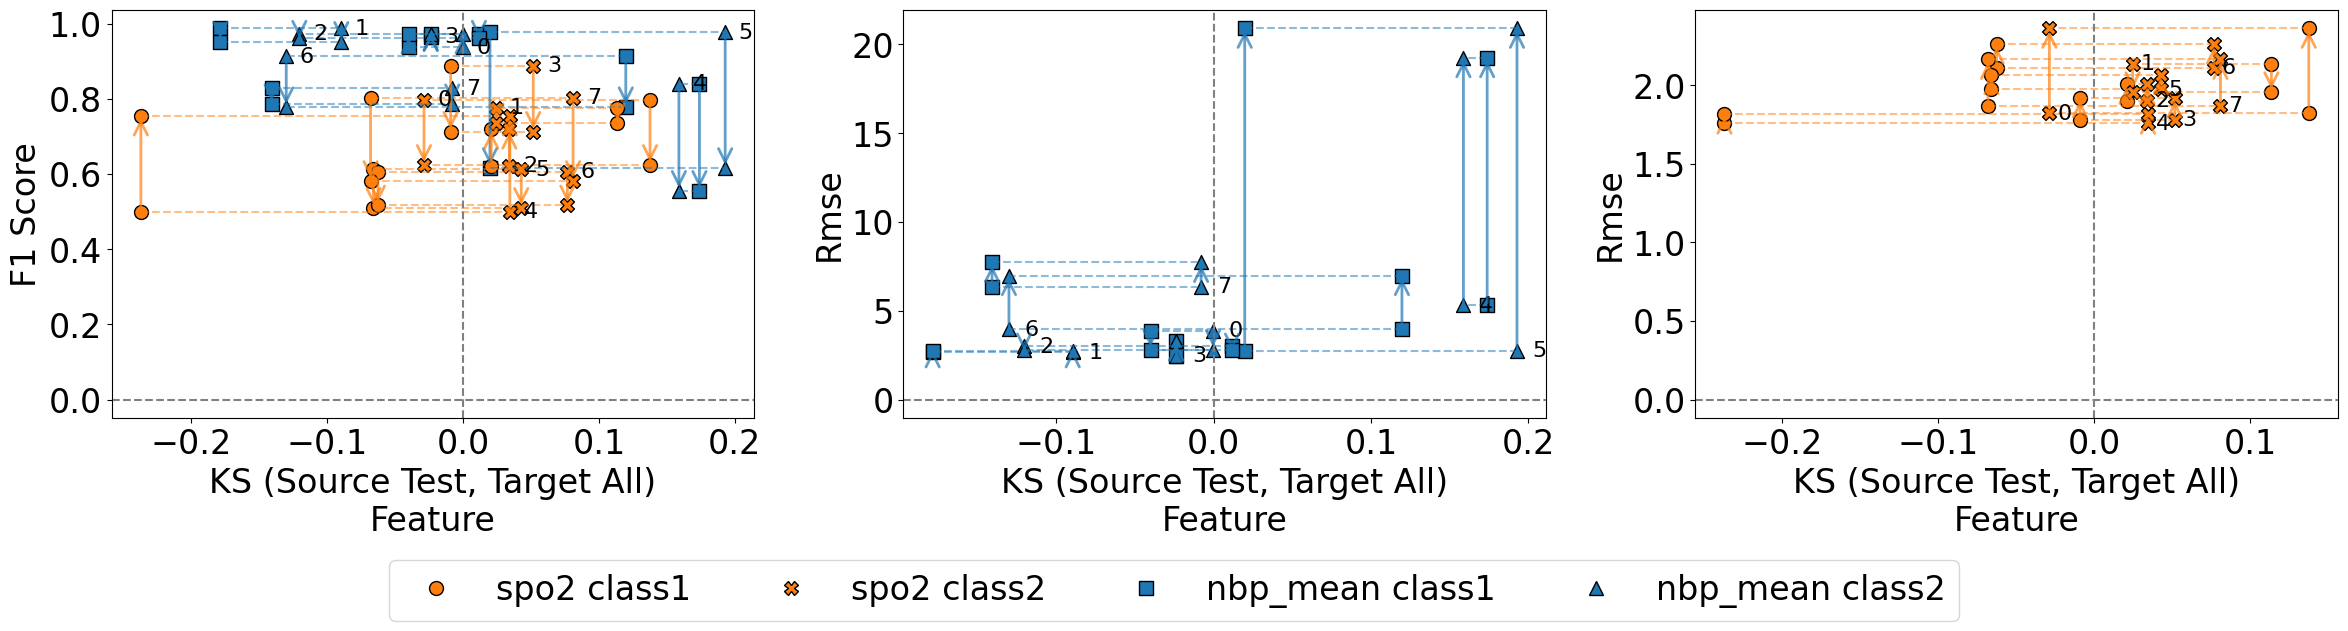

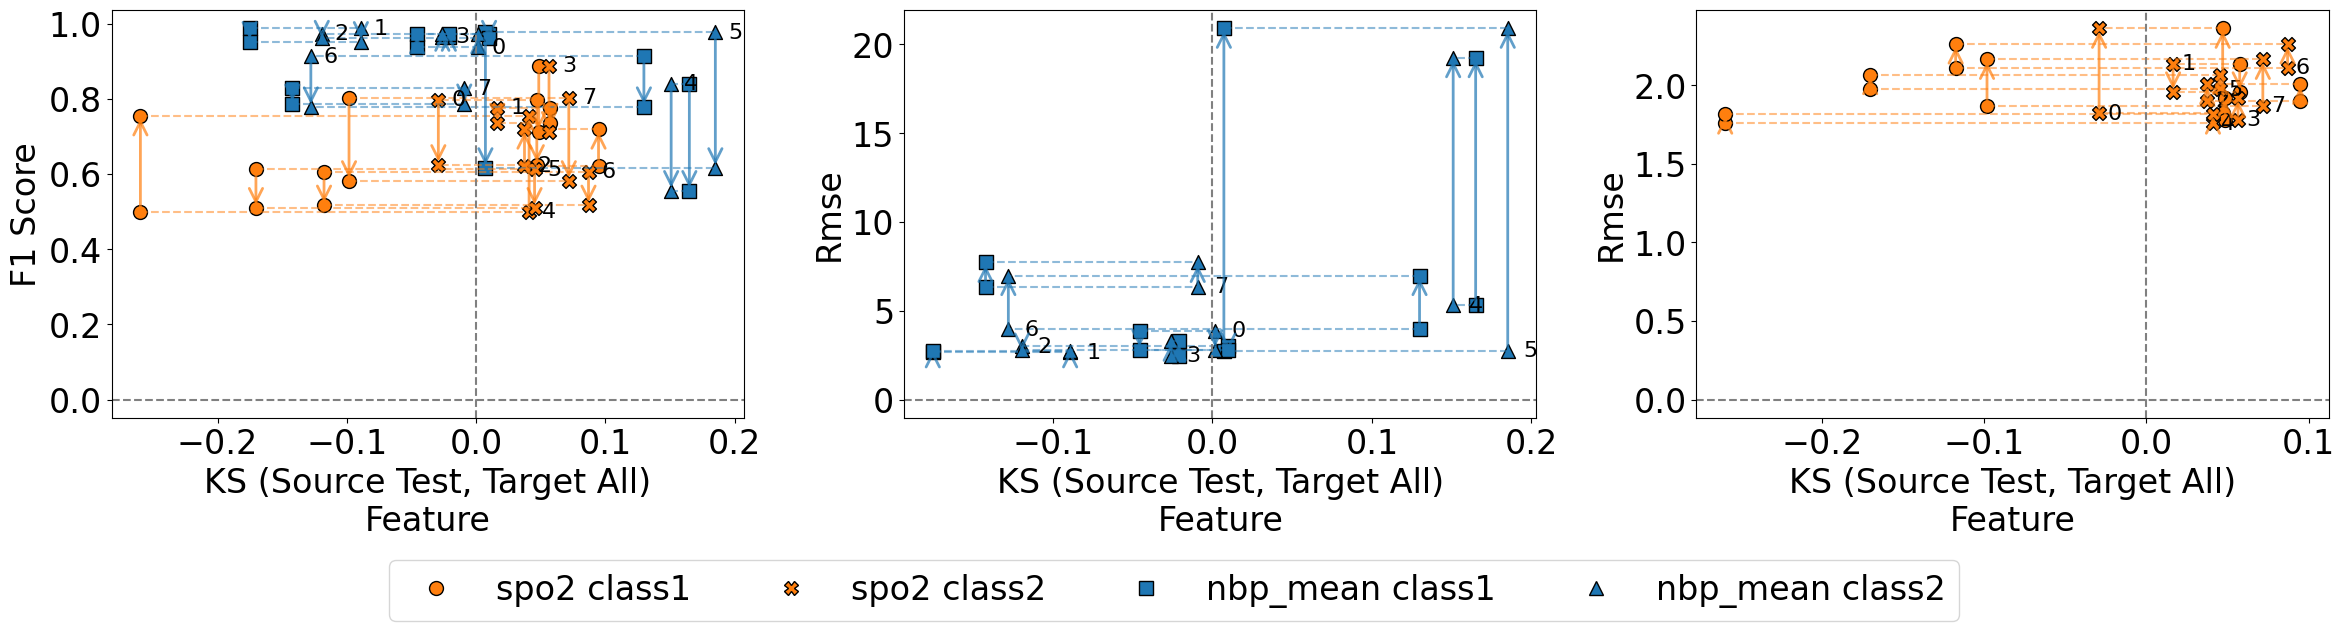

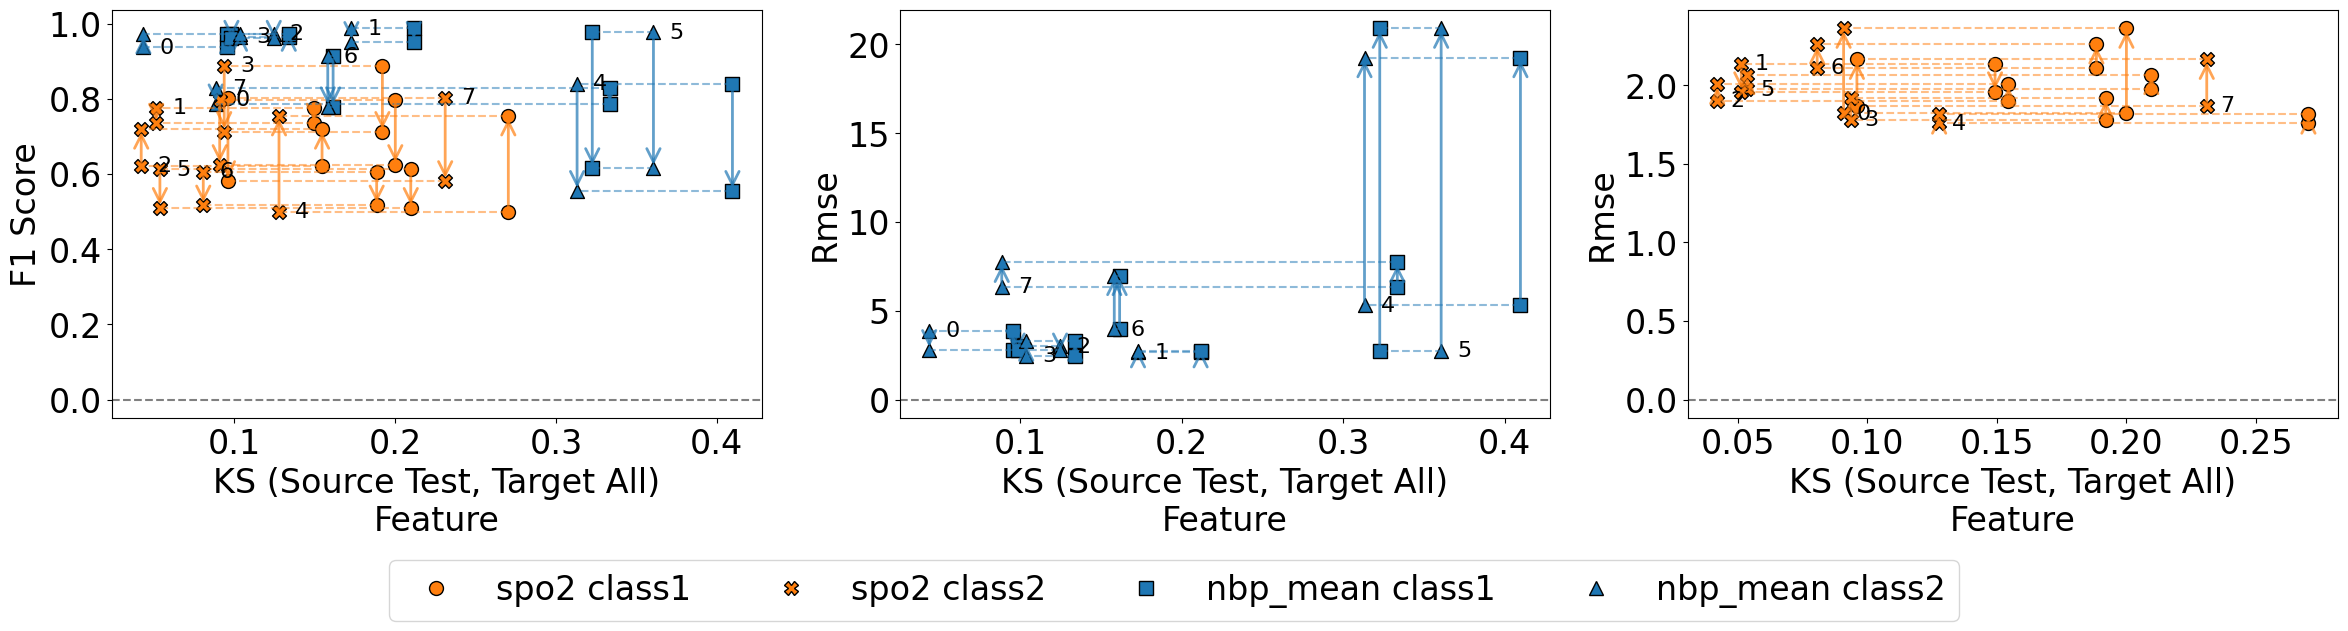

In [27]:
merged_results_and_distances = load_distribution_shift_performance_classwise("ks_2samp")
merged_results_and_distances.to_csv("./results/merged_results_and_distances_classwise_ks_2samp.csv", index=False)
visualize_source_train_vs_target_all_relationships_classwise_absolute_performance(merged_results_and_distances)

## KL Divergence

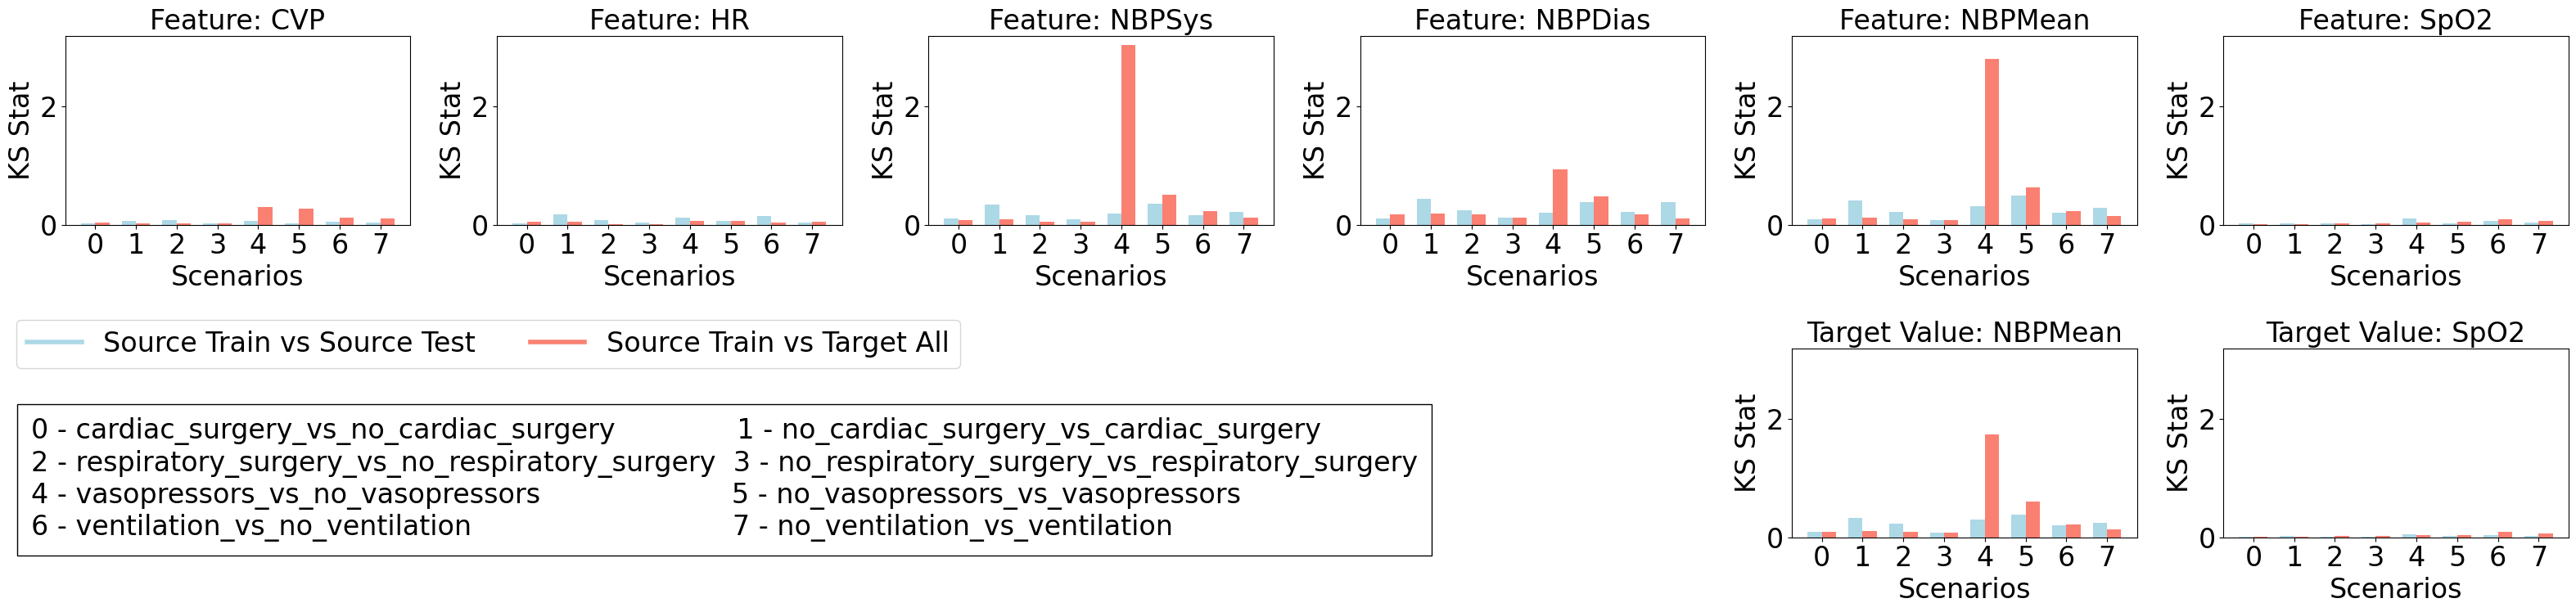

In [28]:
all_distances_by_scenario = visualize_distribution_shifts_overall("kl_divergence")

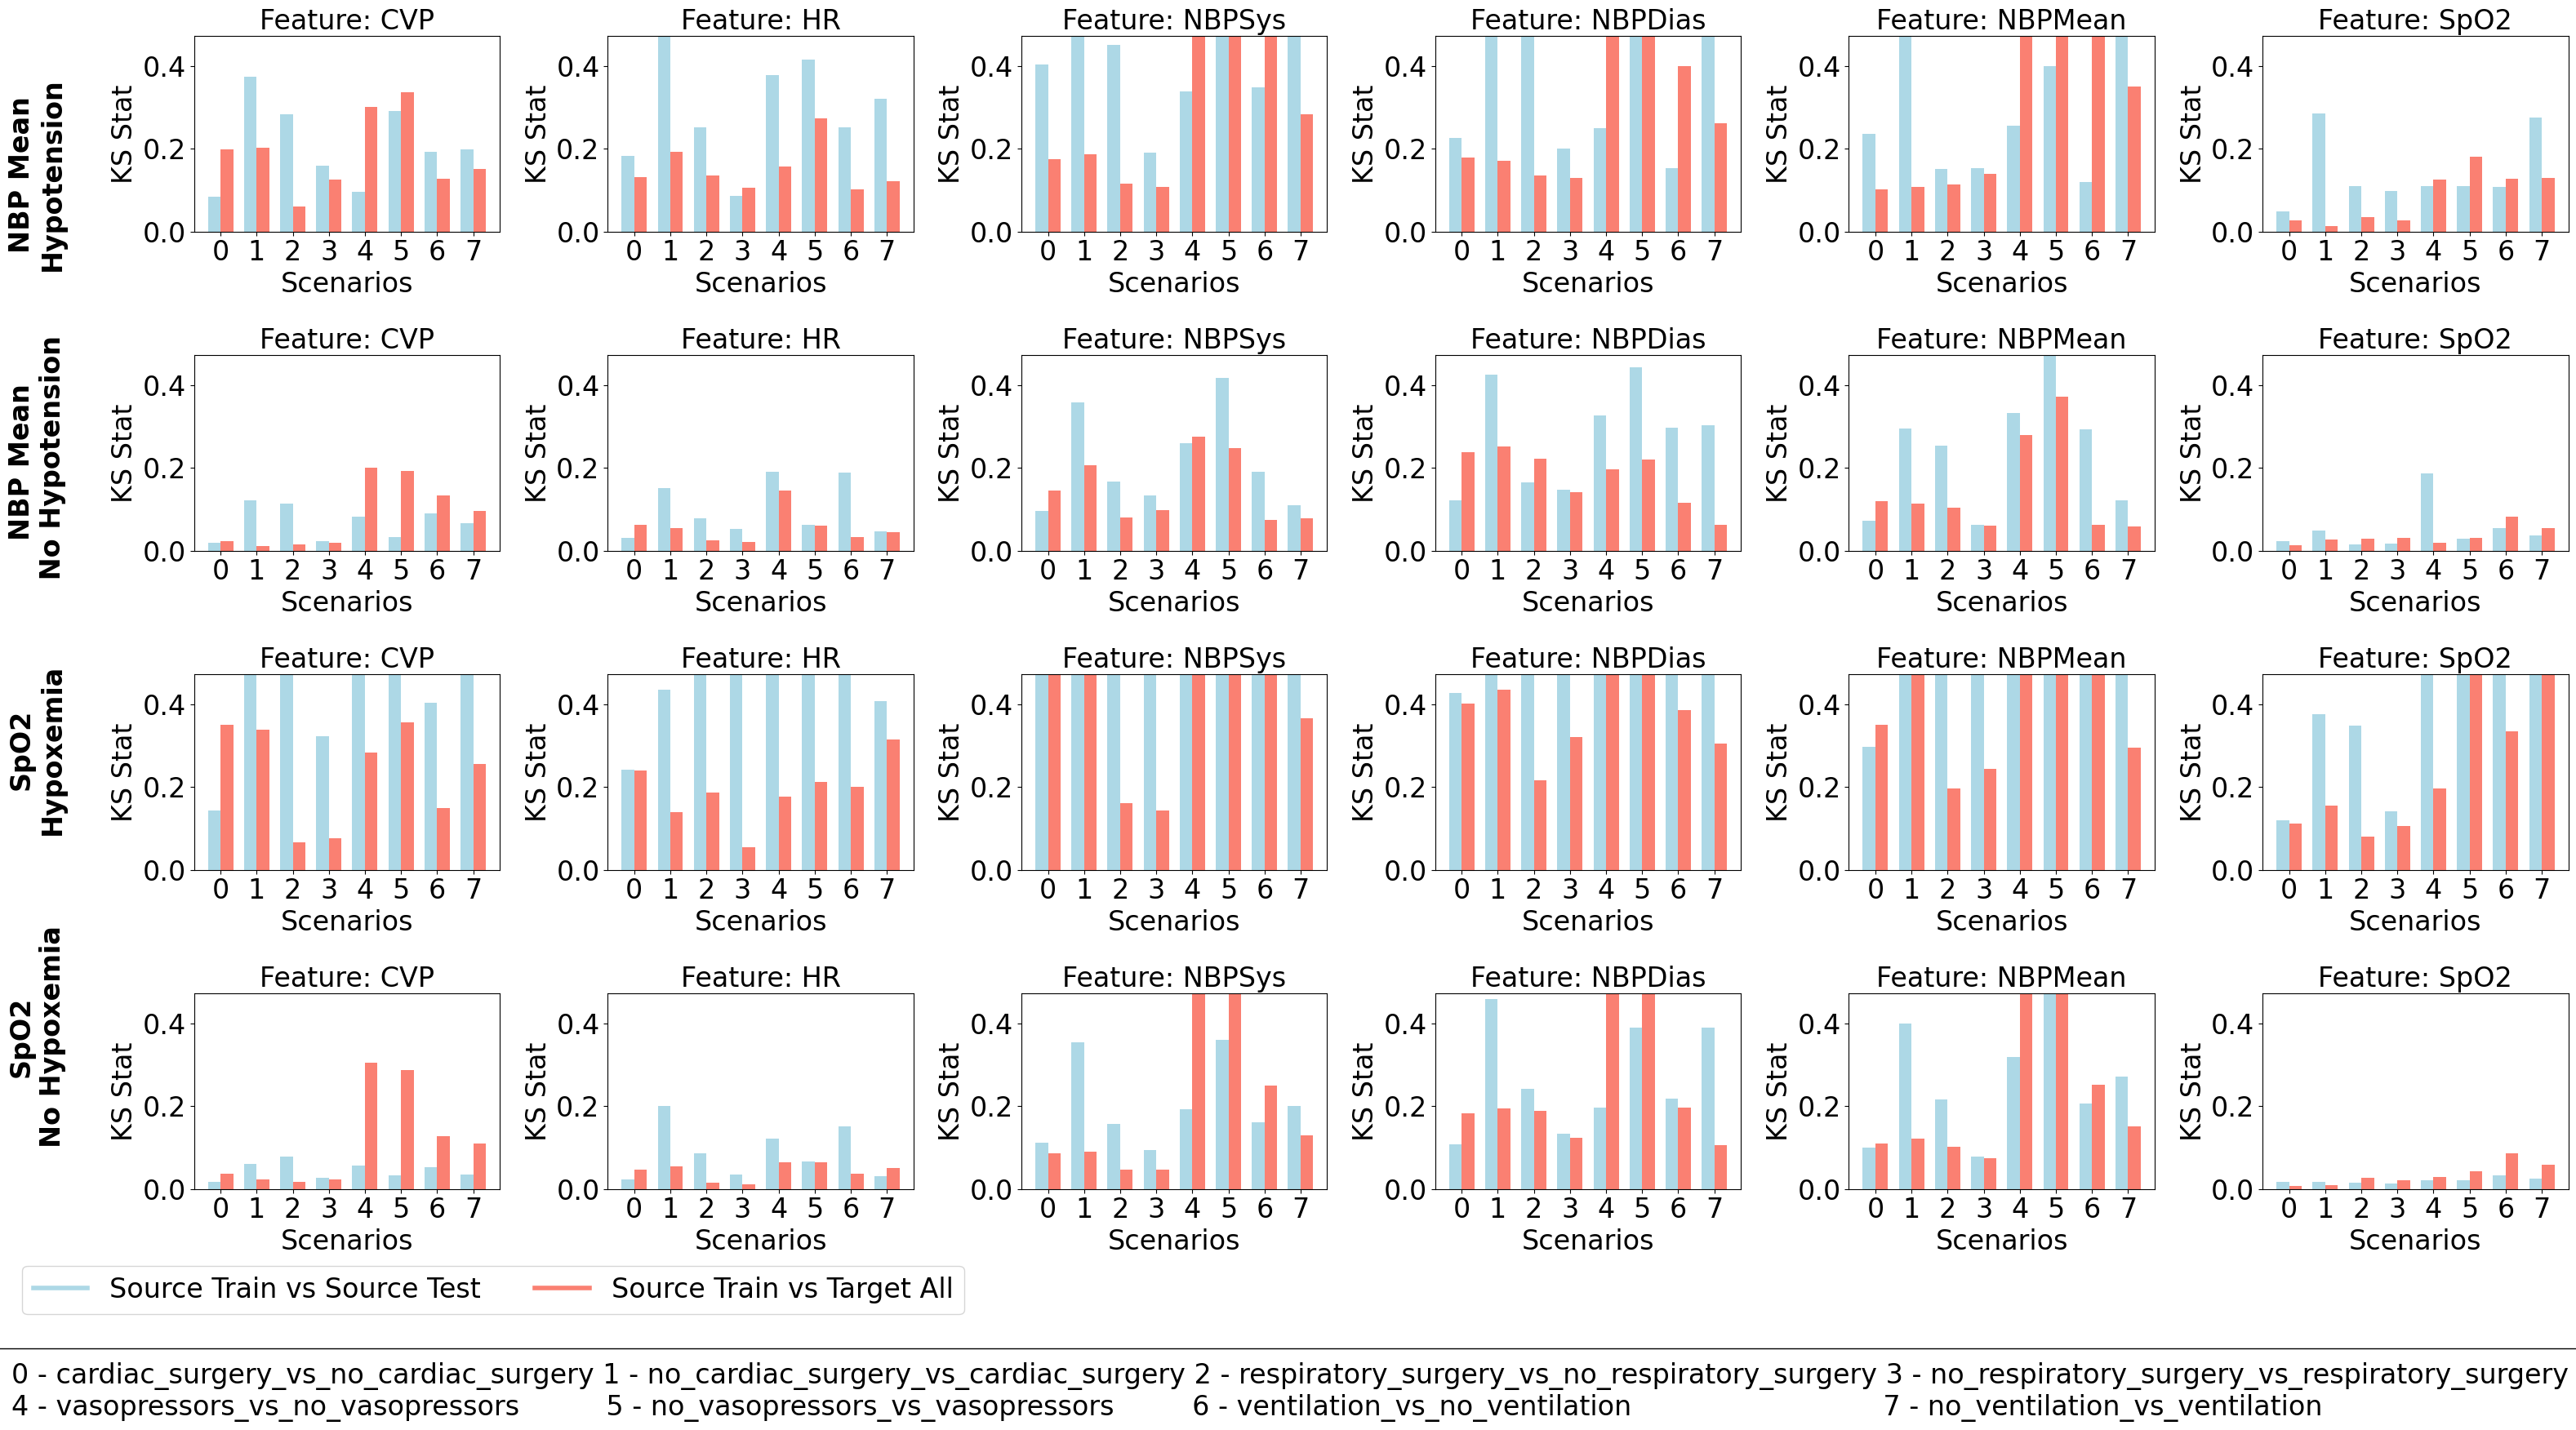

In [29]:
all_distances_by_scenario_classwise = visualize_distribution_shifts_classwise("kl_divergence")

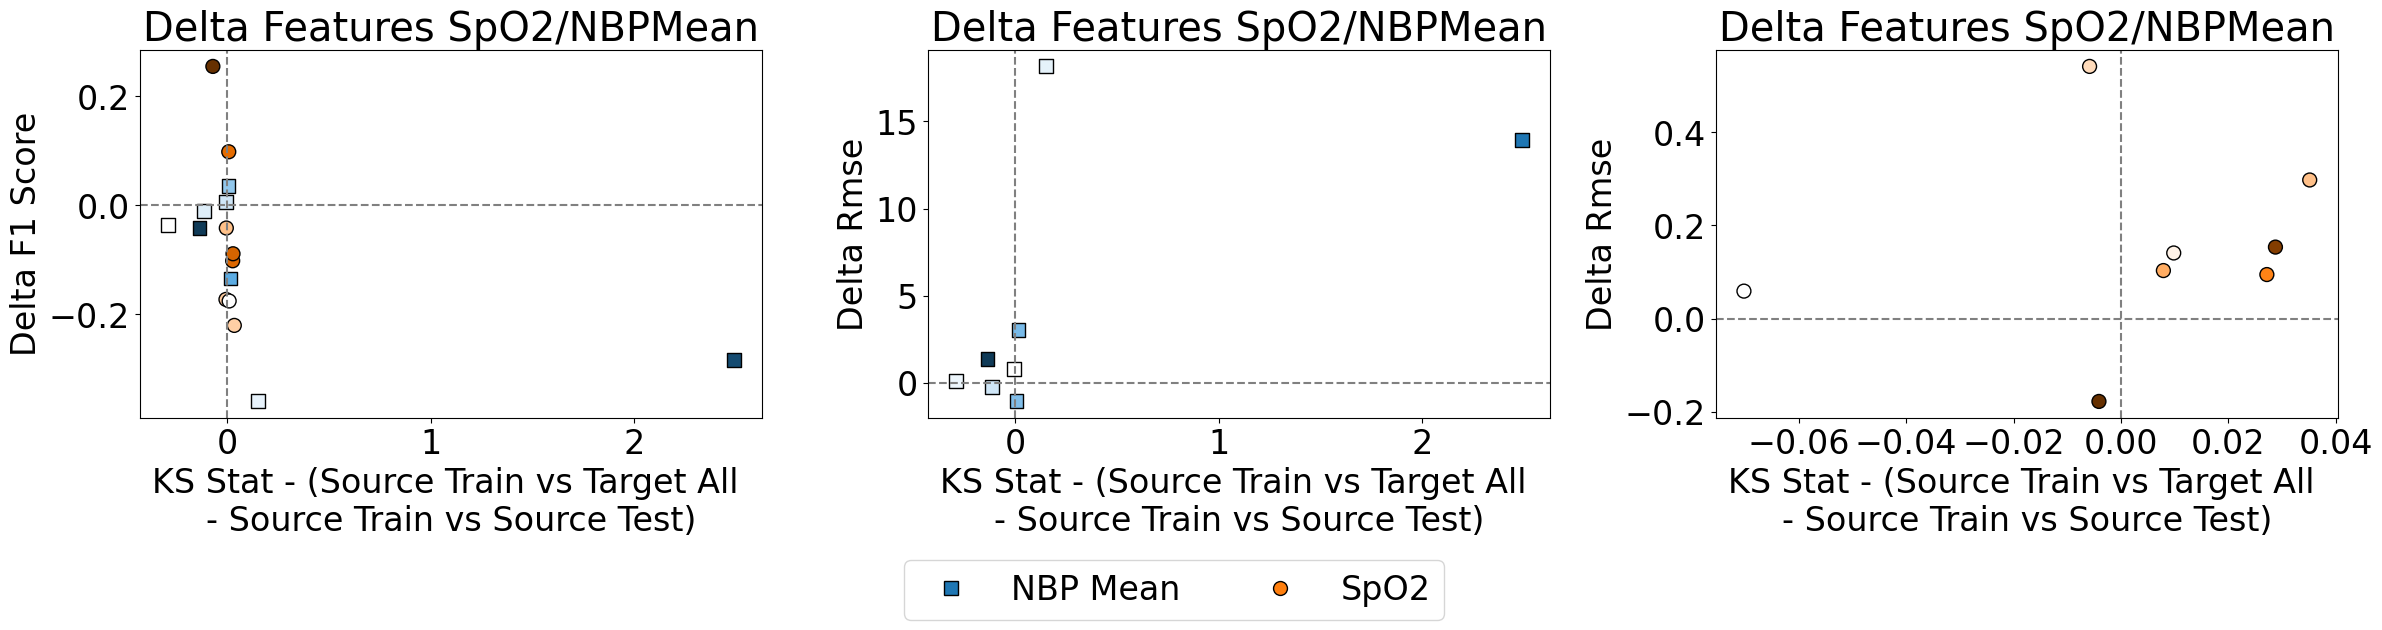

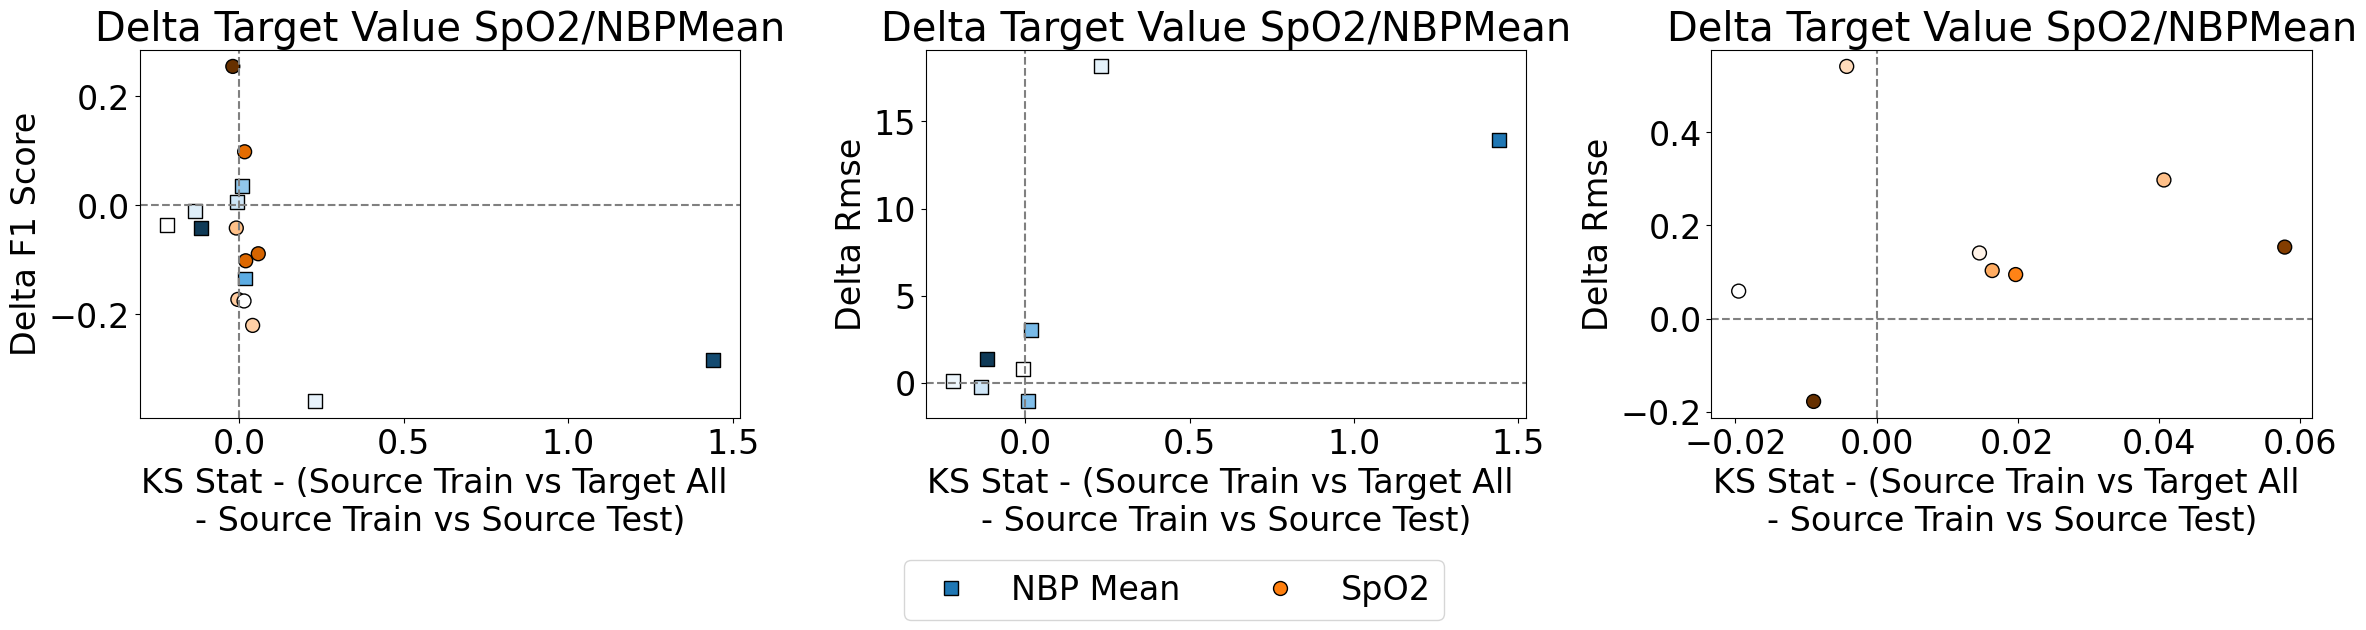

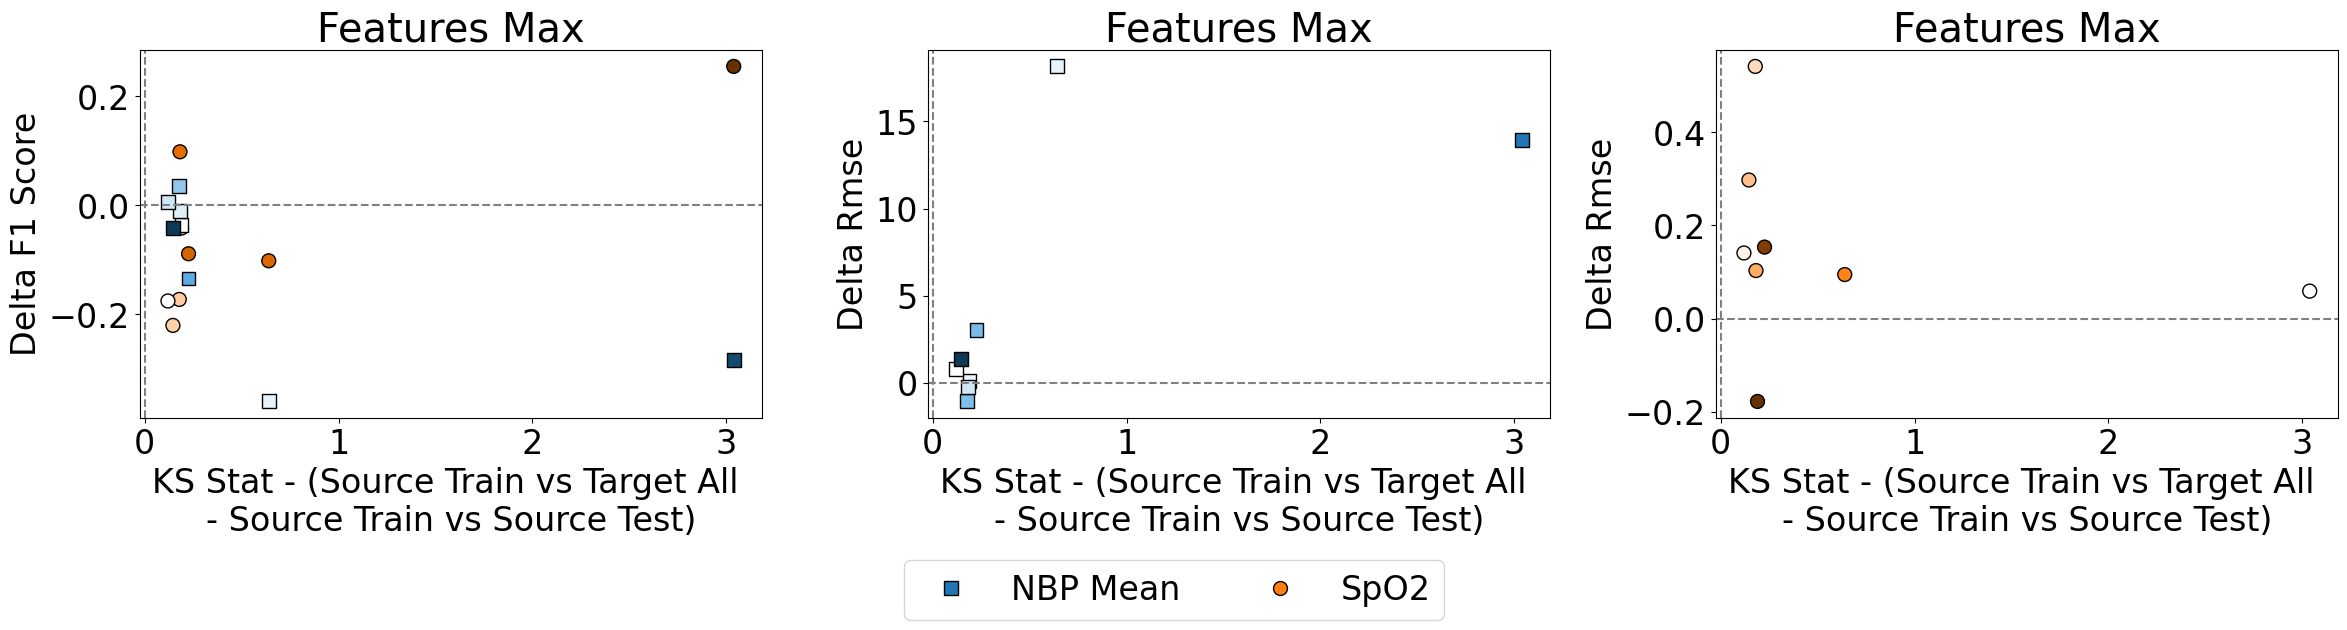

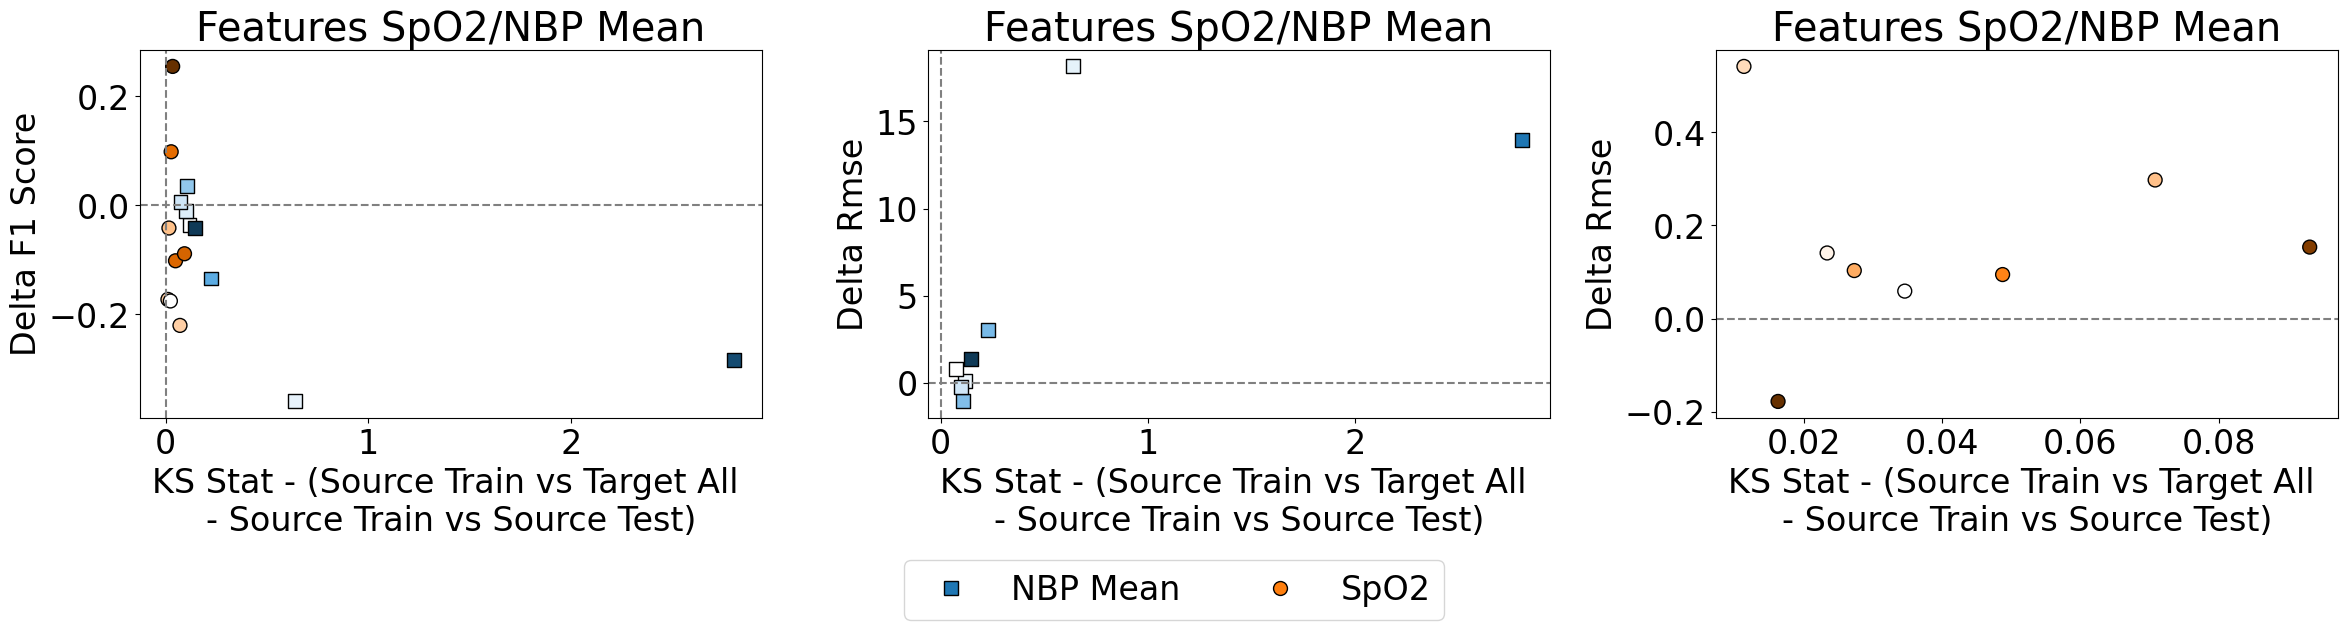

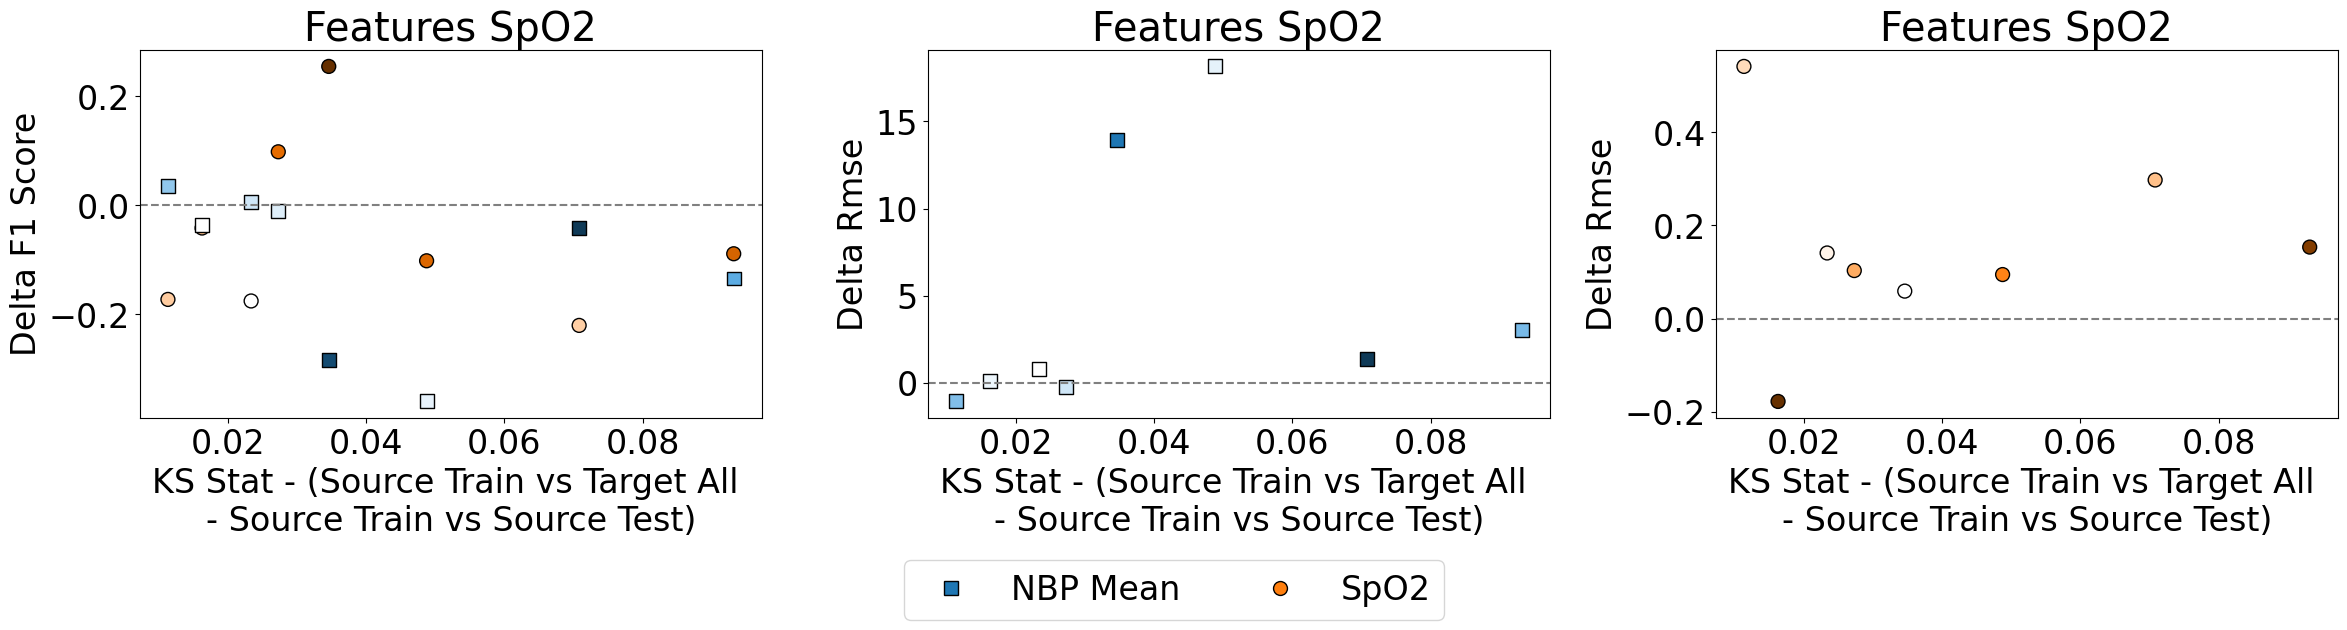

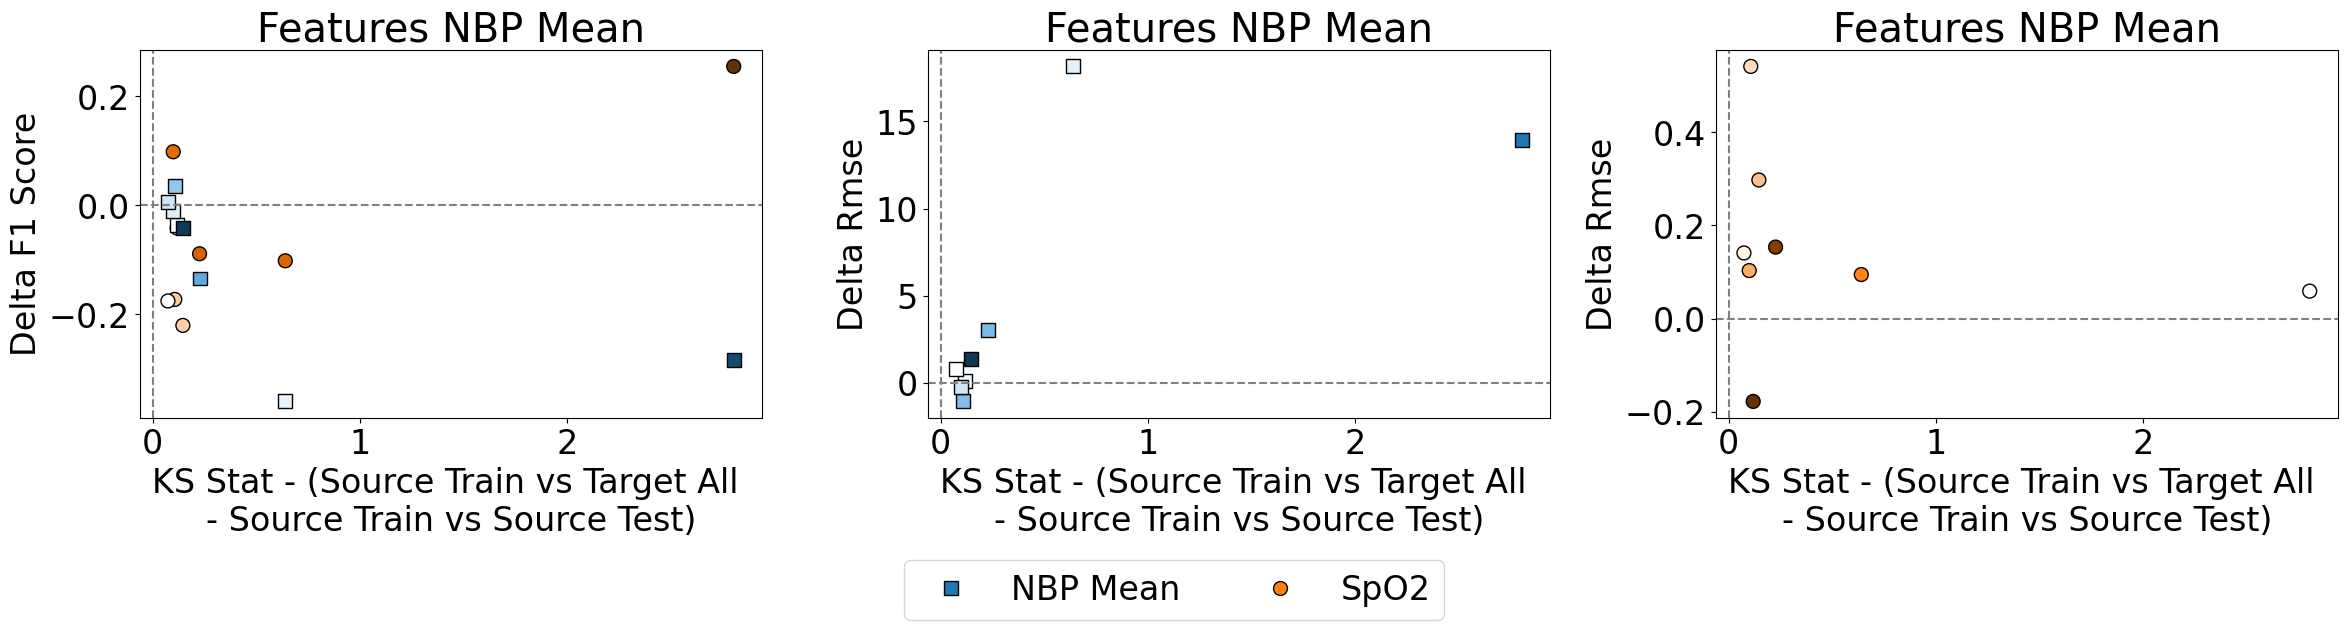

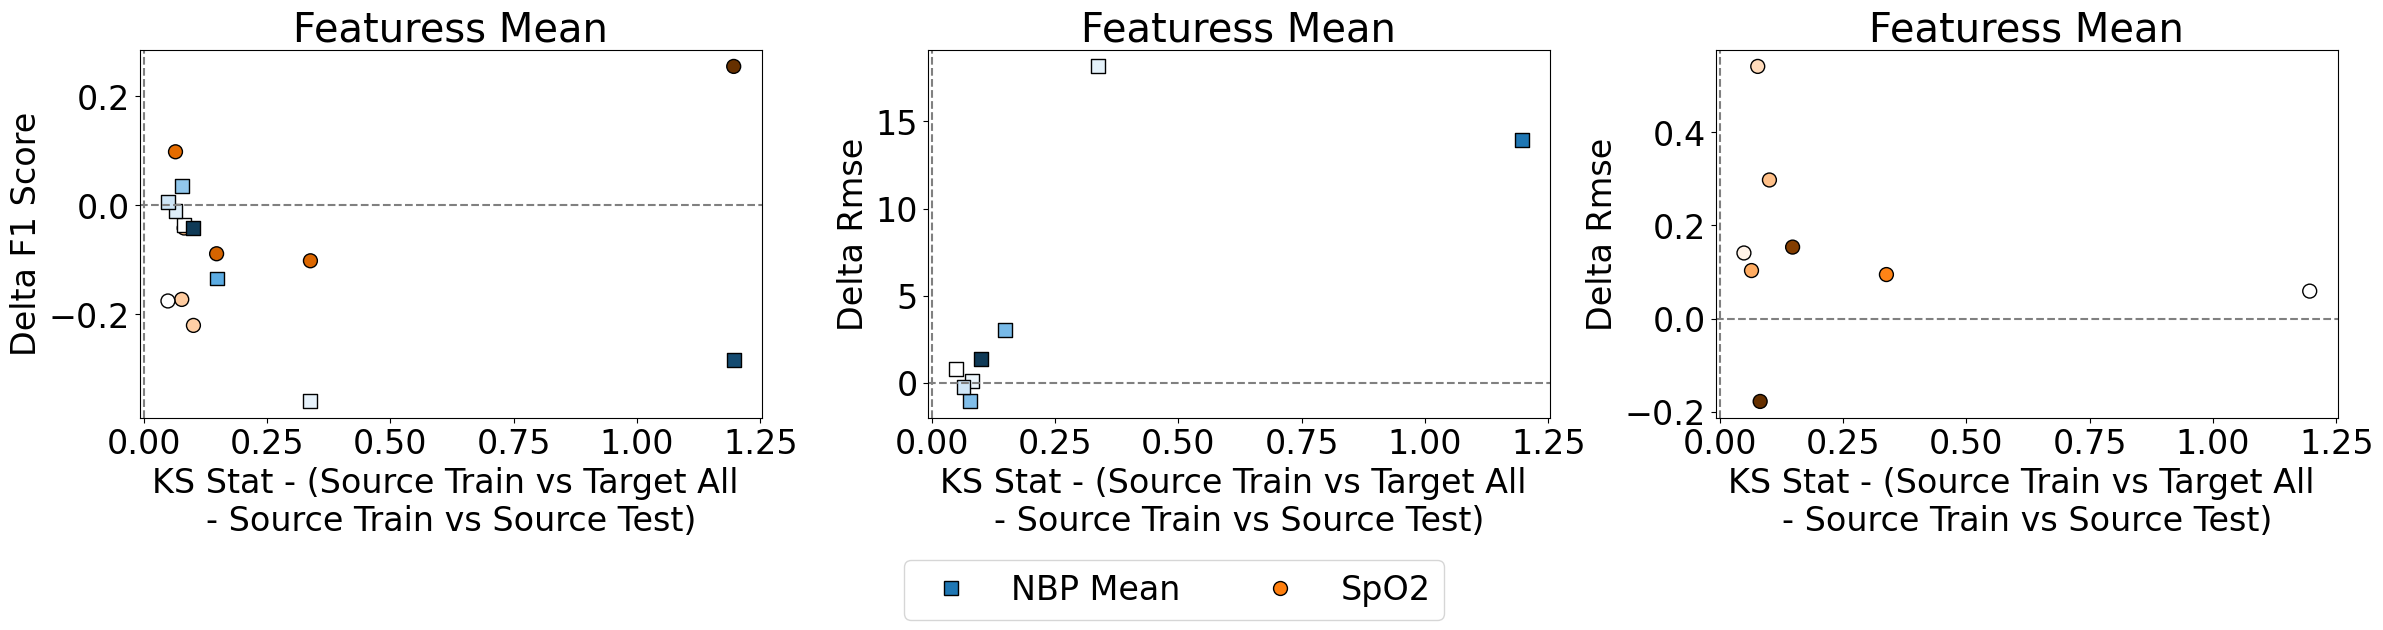

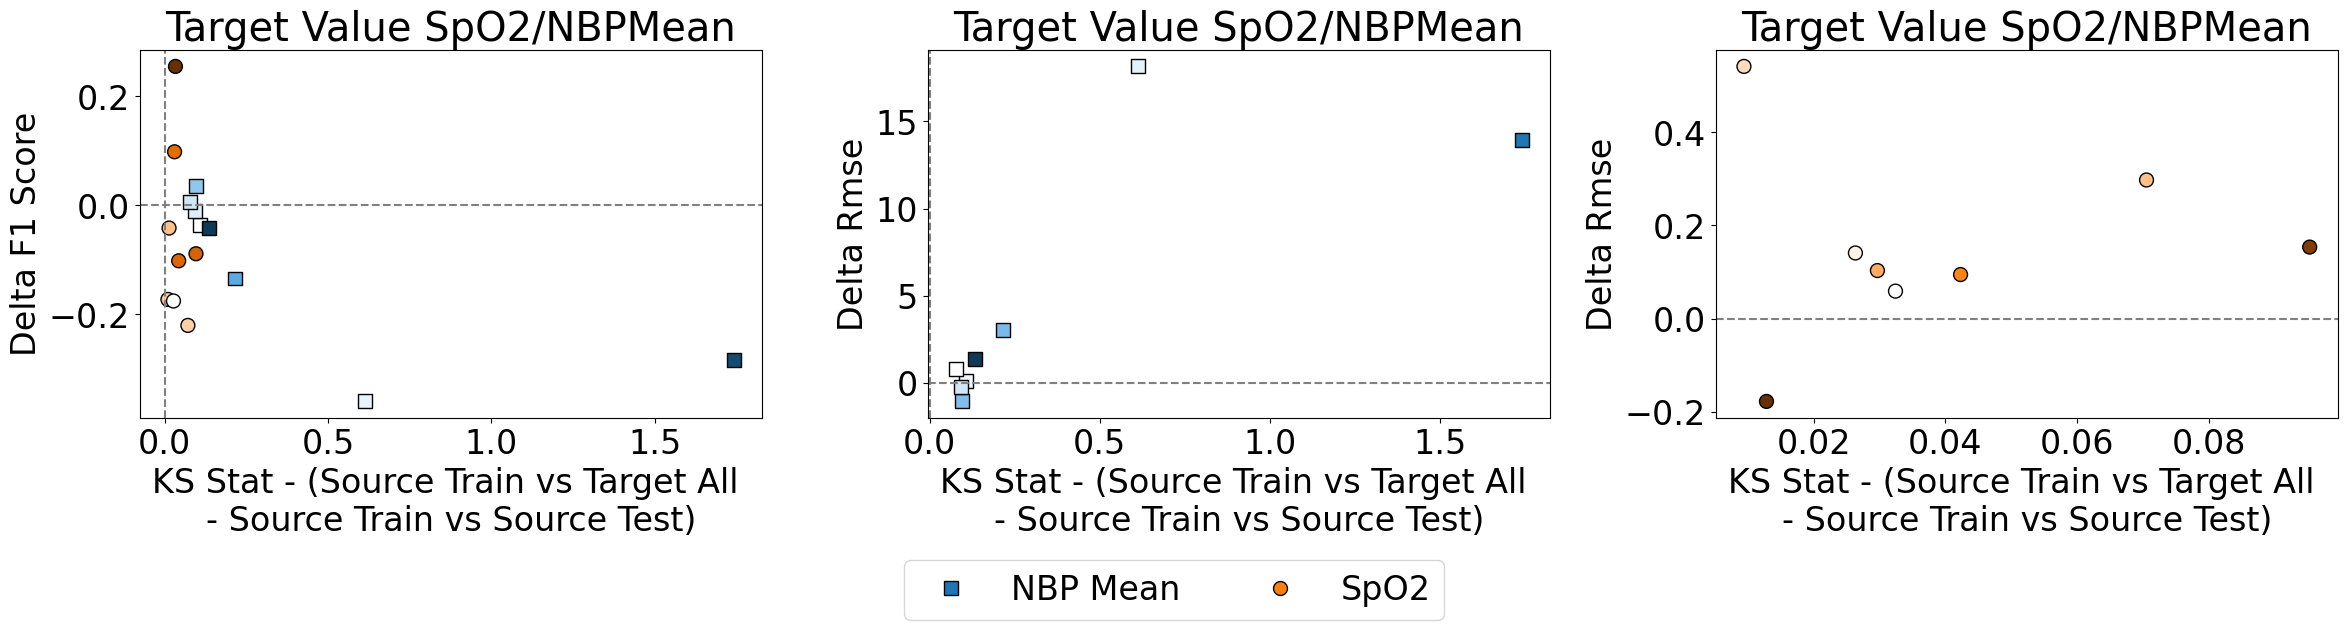

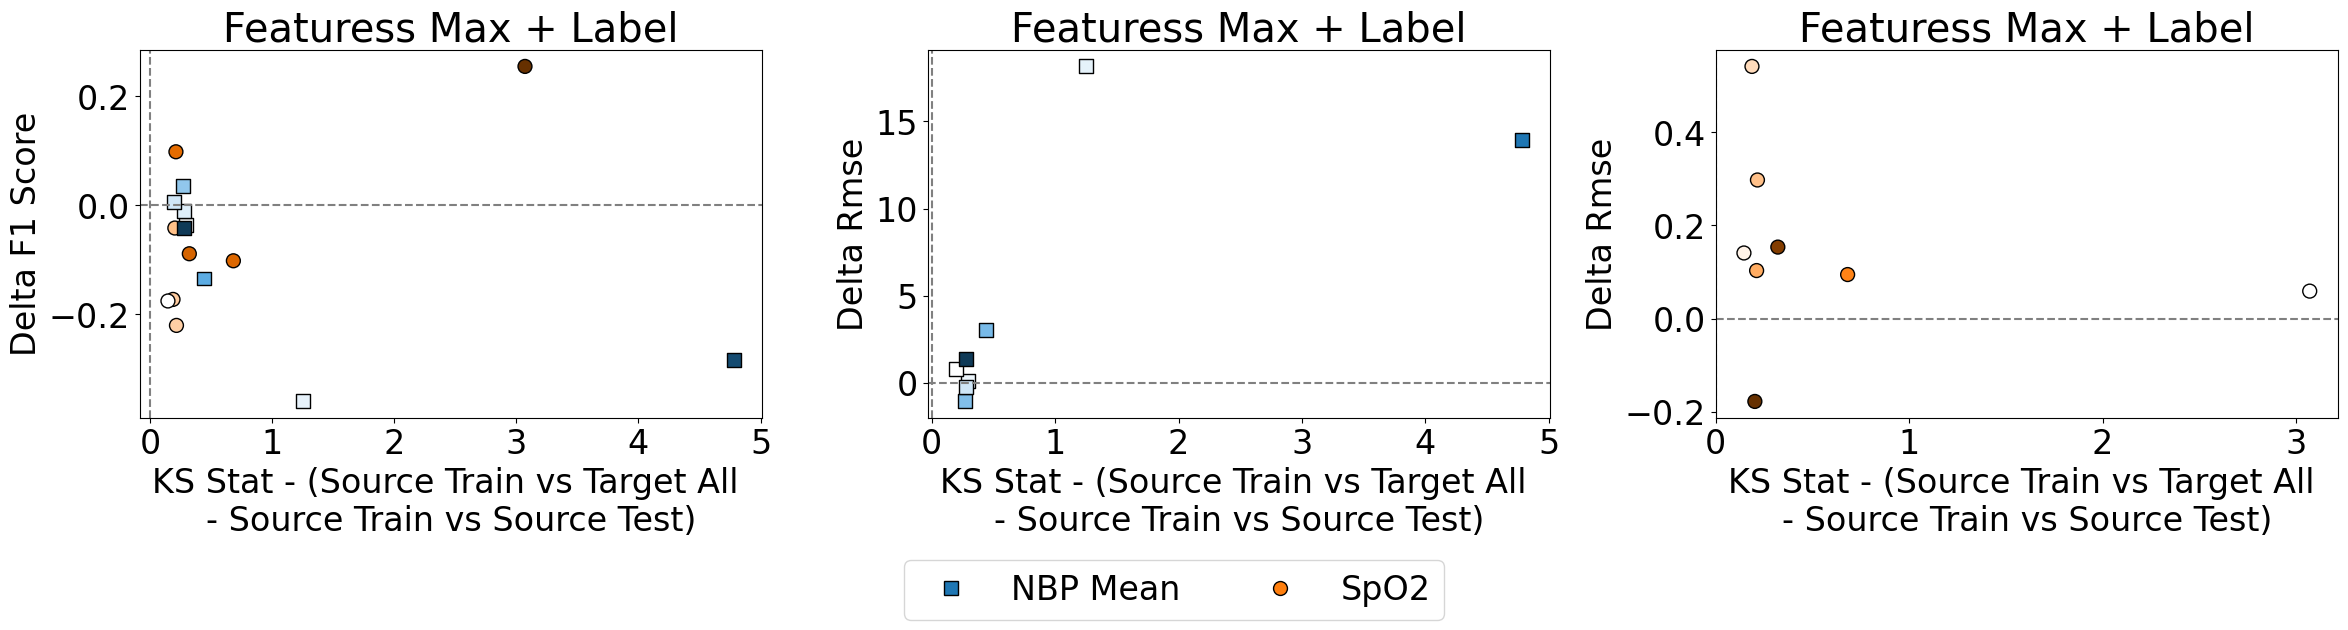

In [30]:
merged_results_and_distances = load_distribution_shift_performance_overall("kl_divergence")
merged_results_and_distances.to_csv("./results/merged_results_and_distances_overall_kl_divergence.csv", index=False)
visualize_source_train_vs_target_all_relationships(merged_results_and_distances)

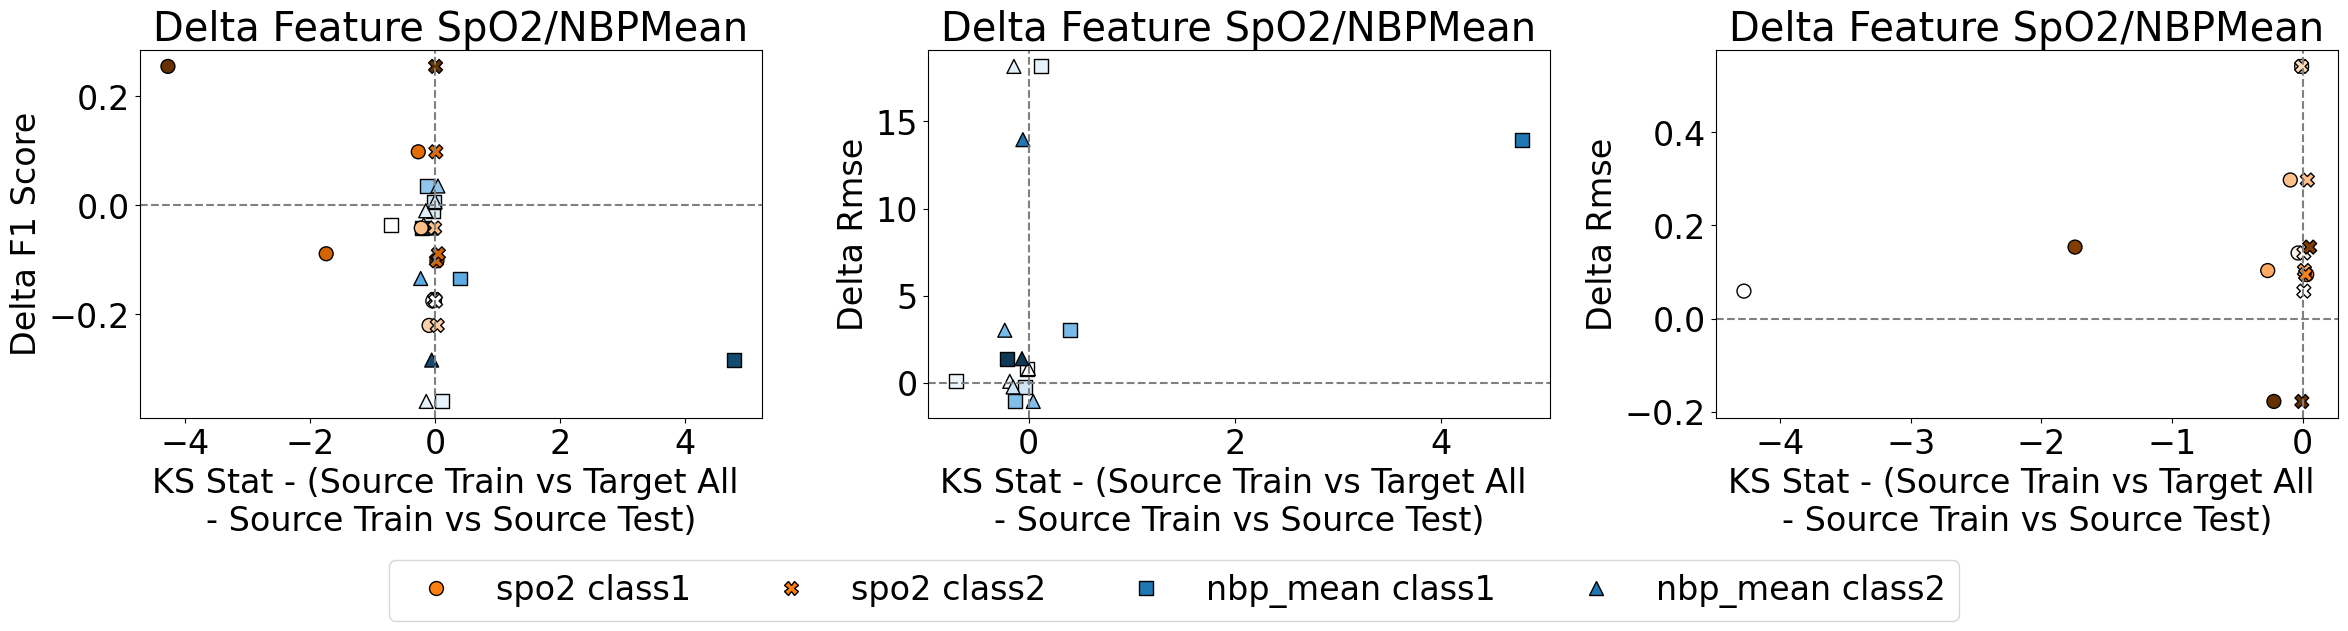

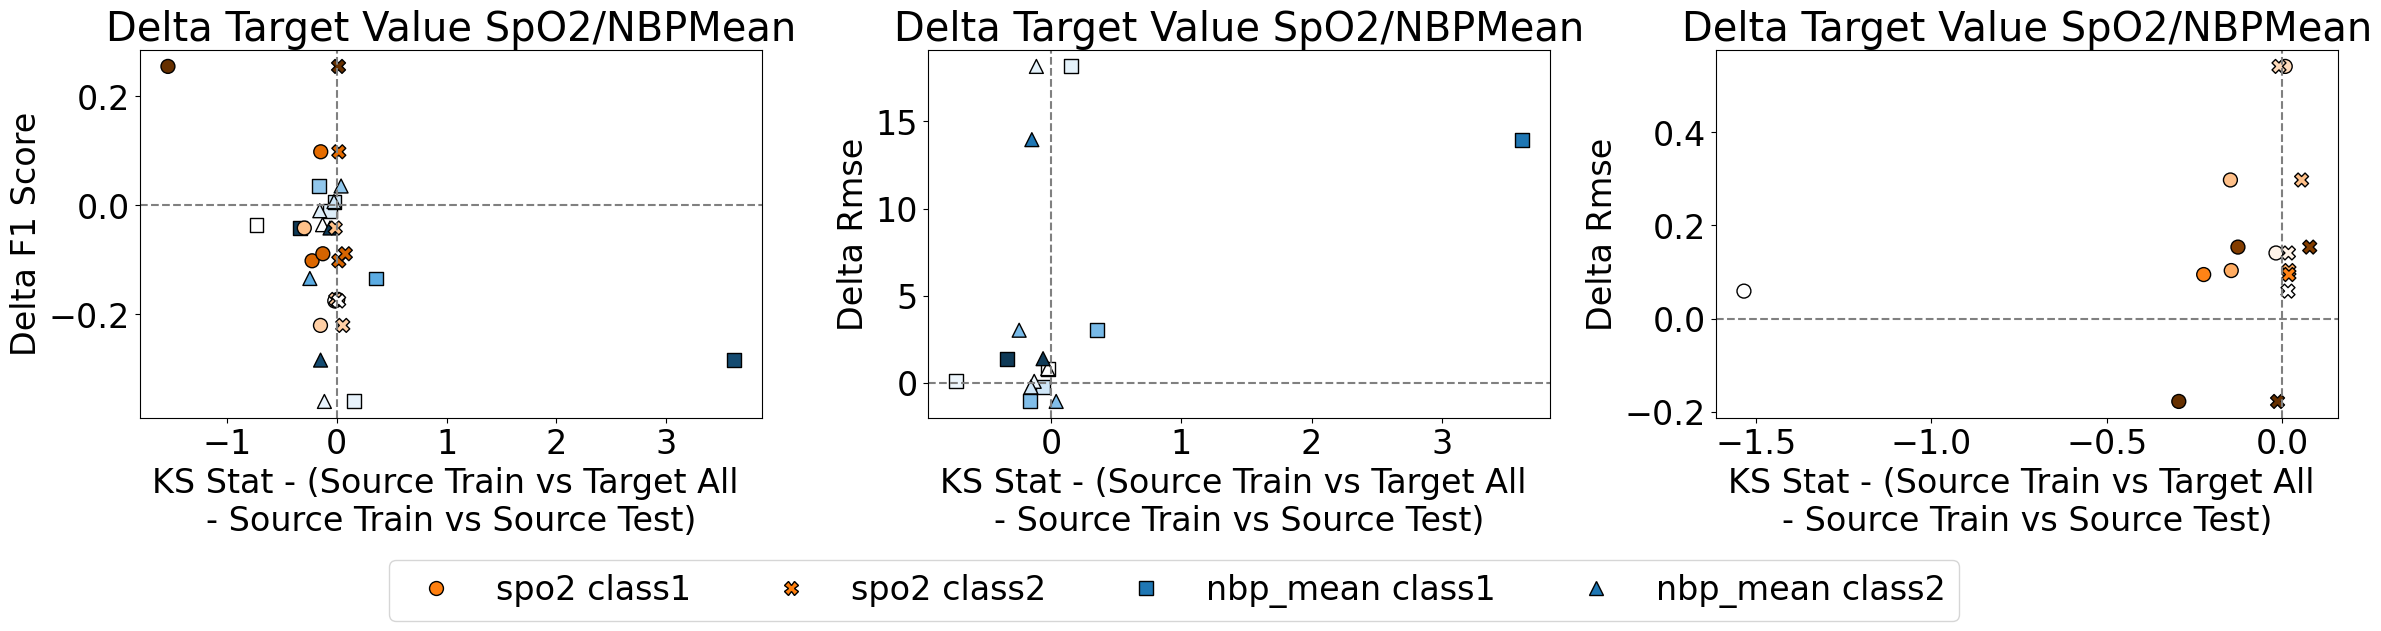

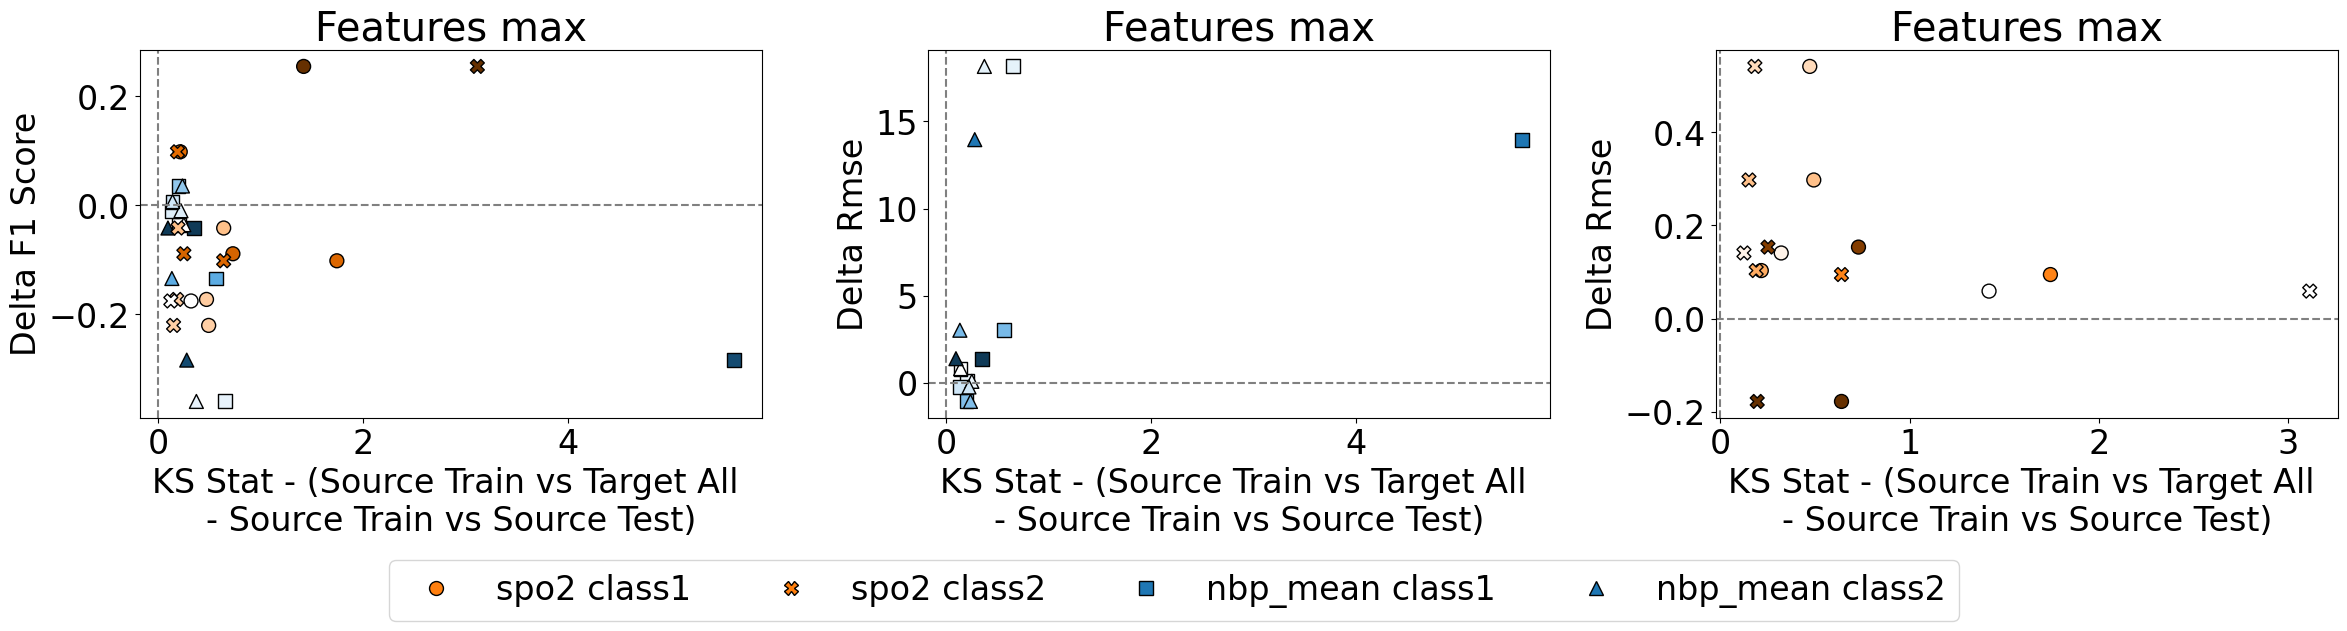

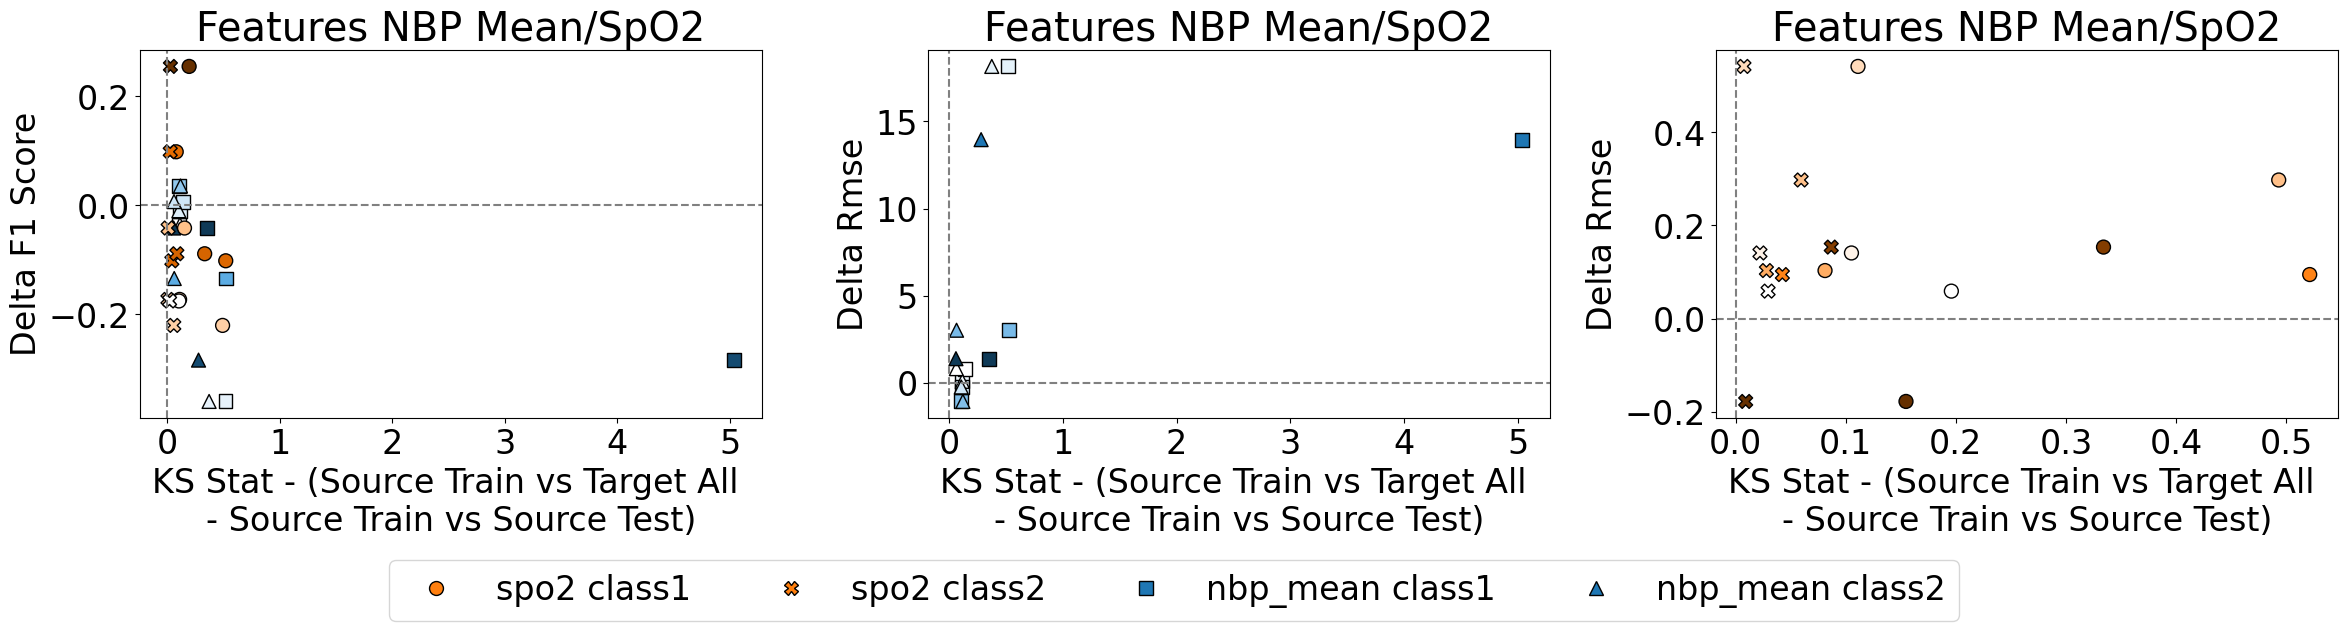

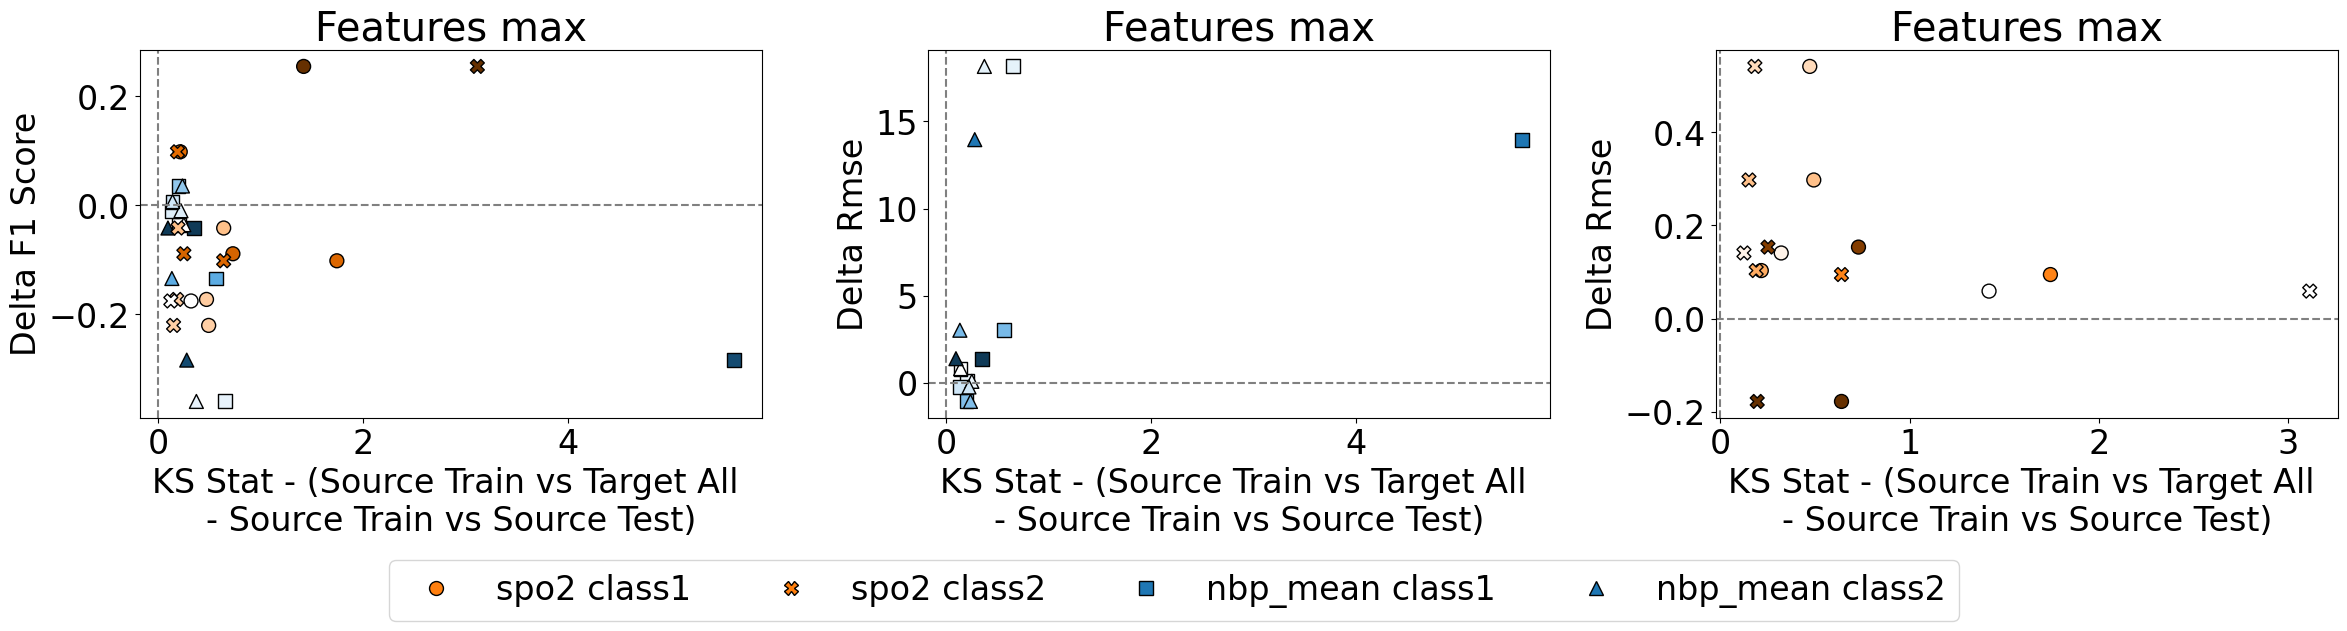

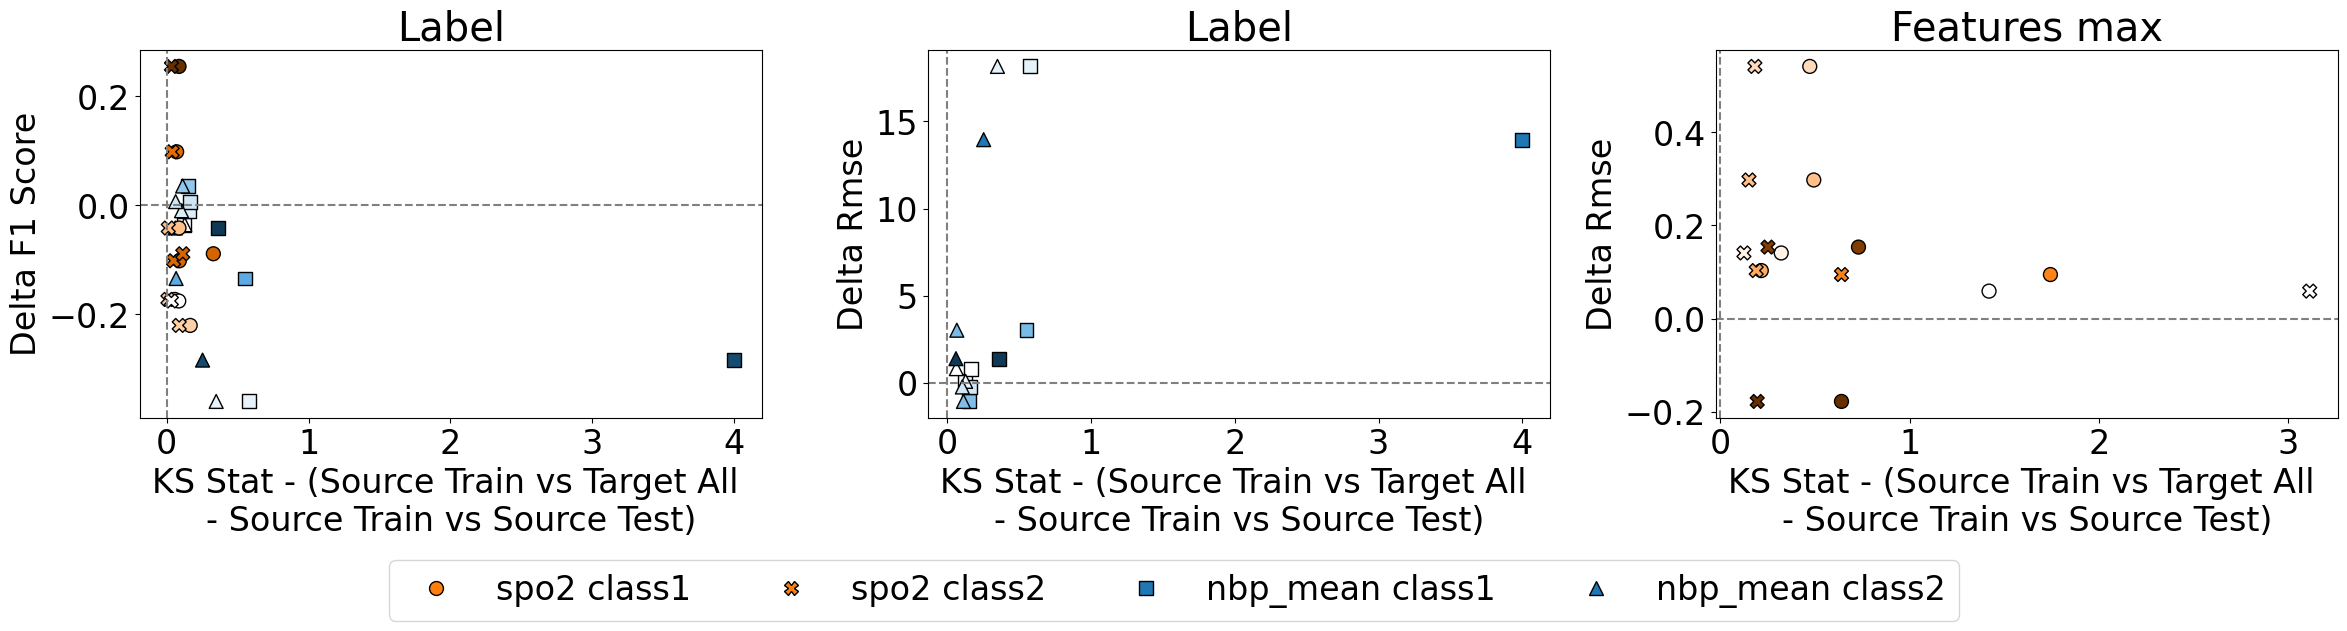

In [31]:
merged_results_and_distances = load_distribution_shift_performance_classwise("kl_divergence")
merged_results_and_distances.to_csv("./results/merged_results_and_distances_classwise_kl_divergence.csv", index=False)
visualize_source_train_vs_target_all_relationships_classwise(merged_results_and_distances)

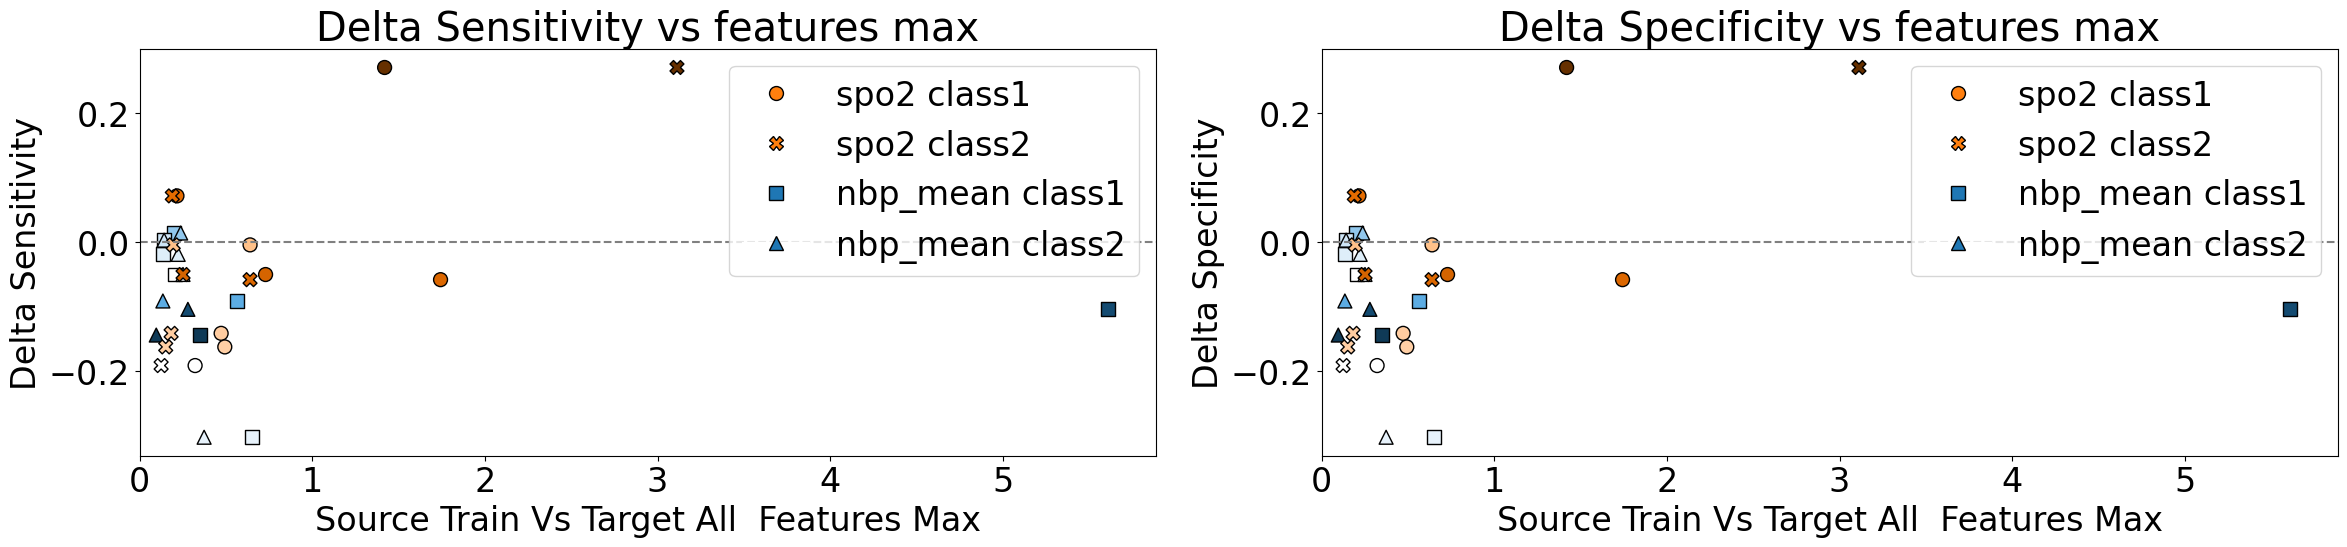

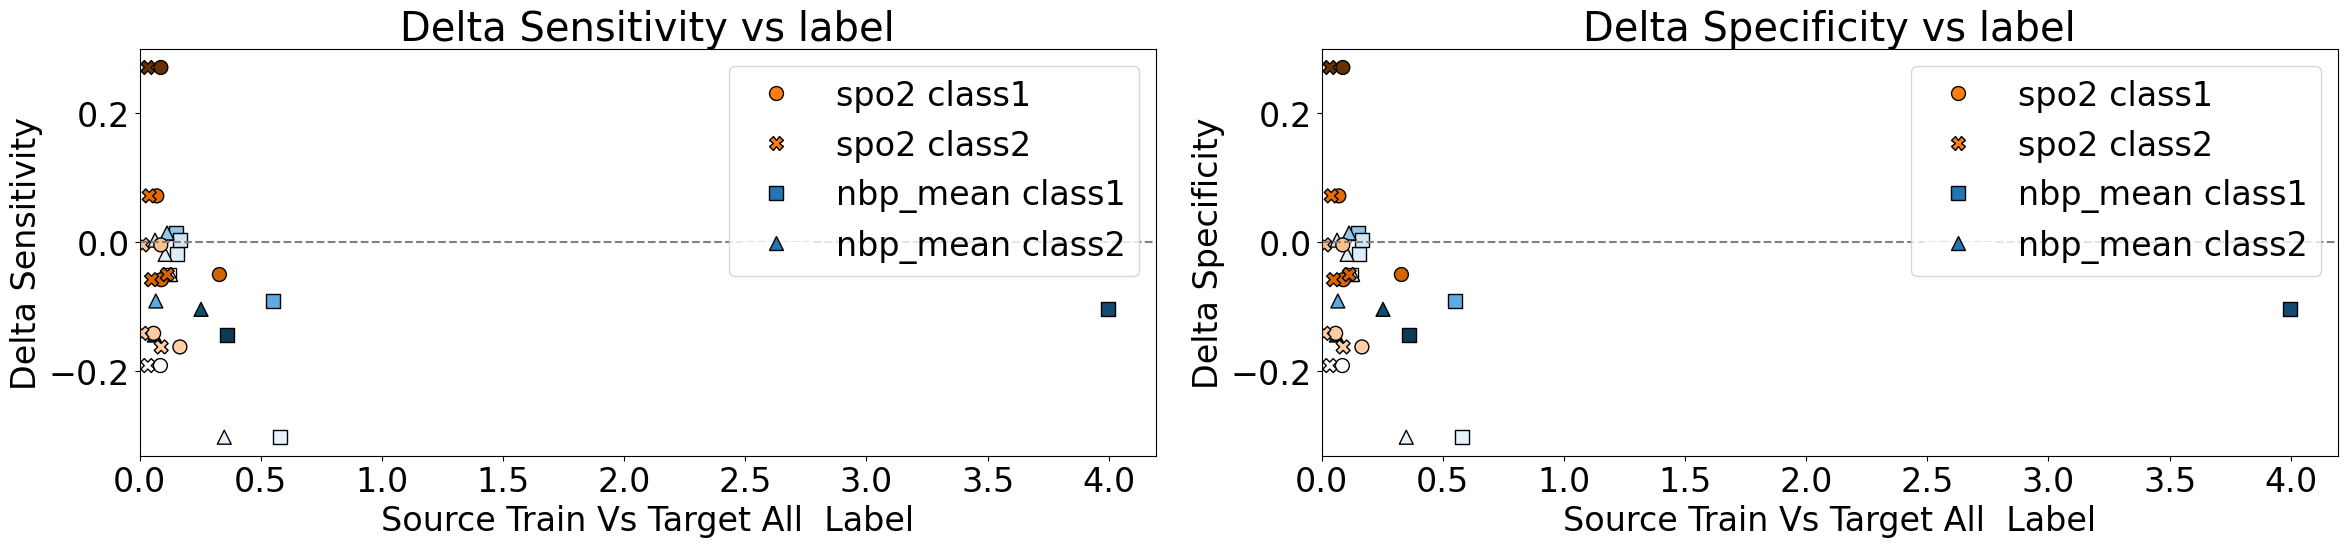

In [32]:
visualize_source_train_vs_target_all_relationships_classwise_sensitivity_specificity(merged_results_and_distances)

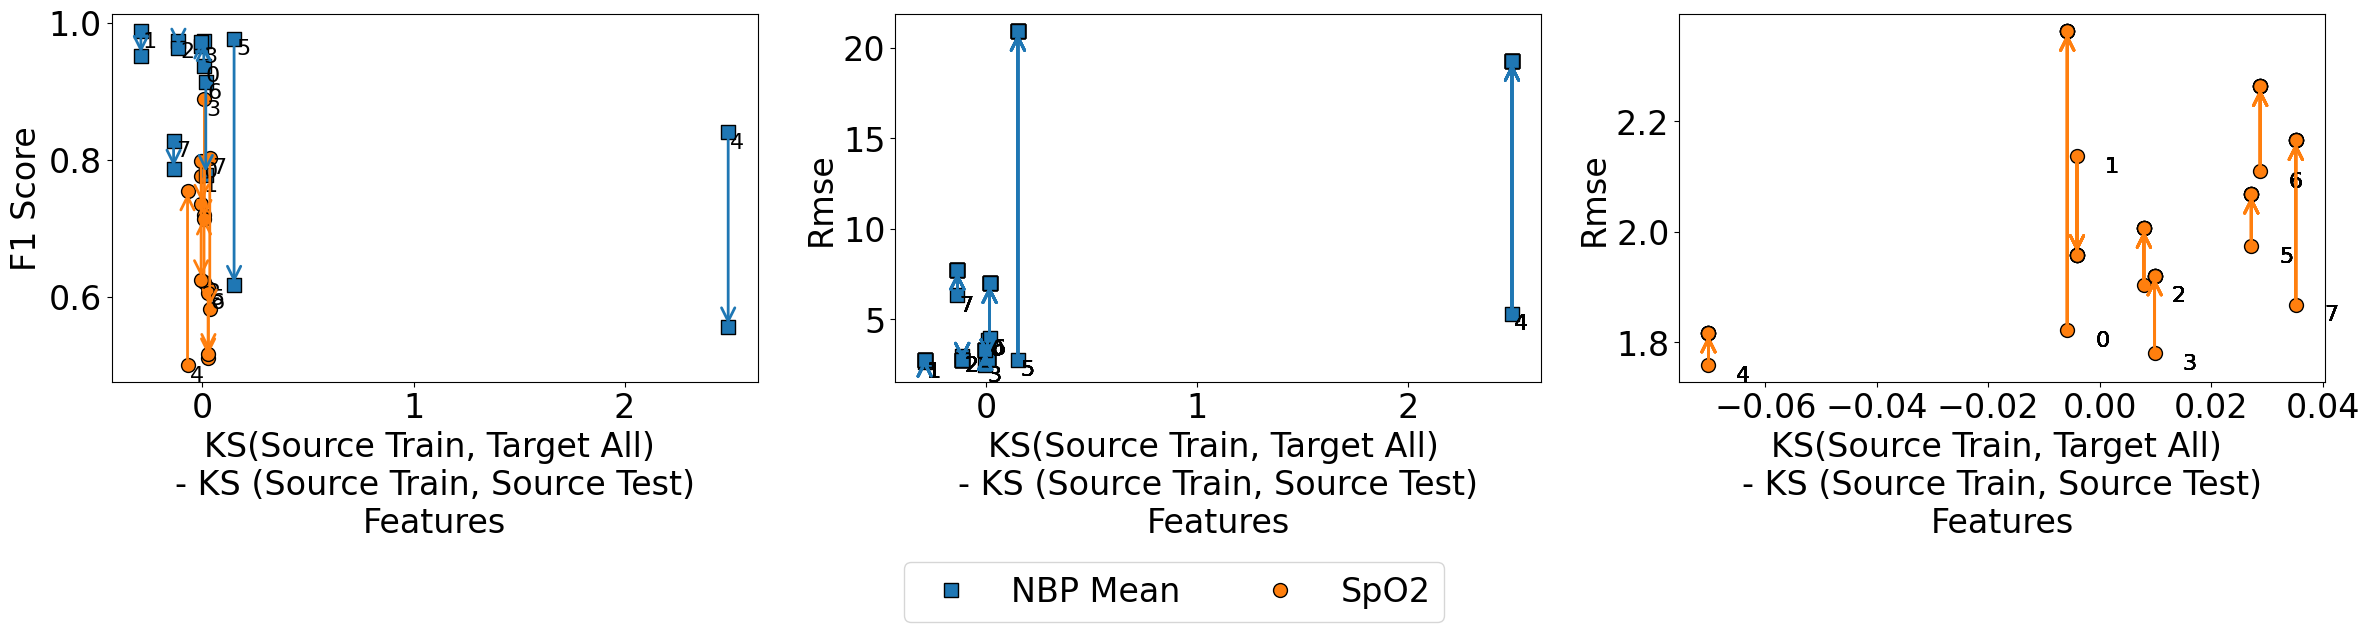

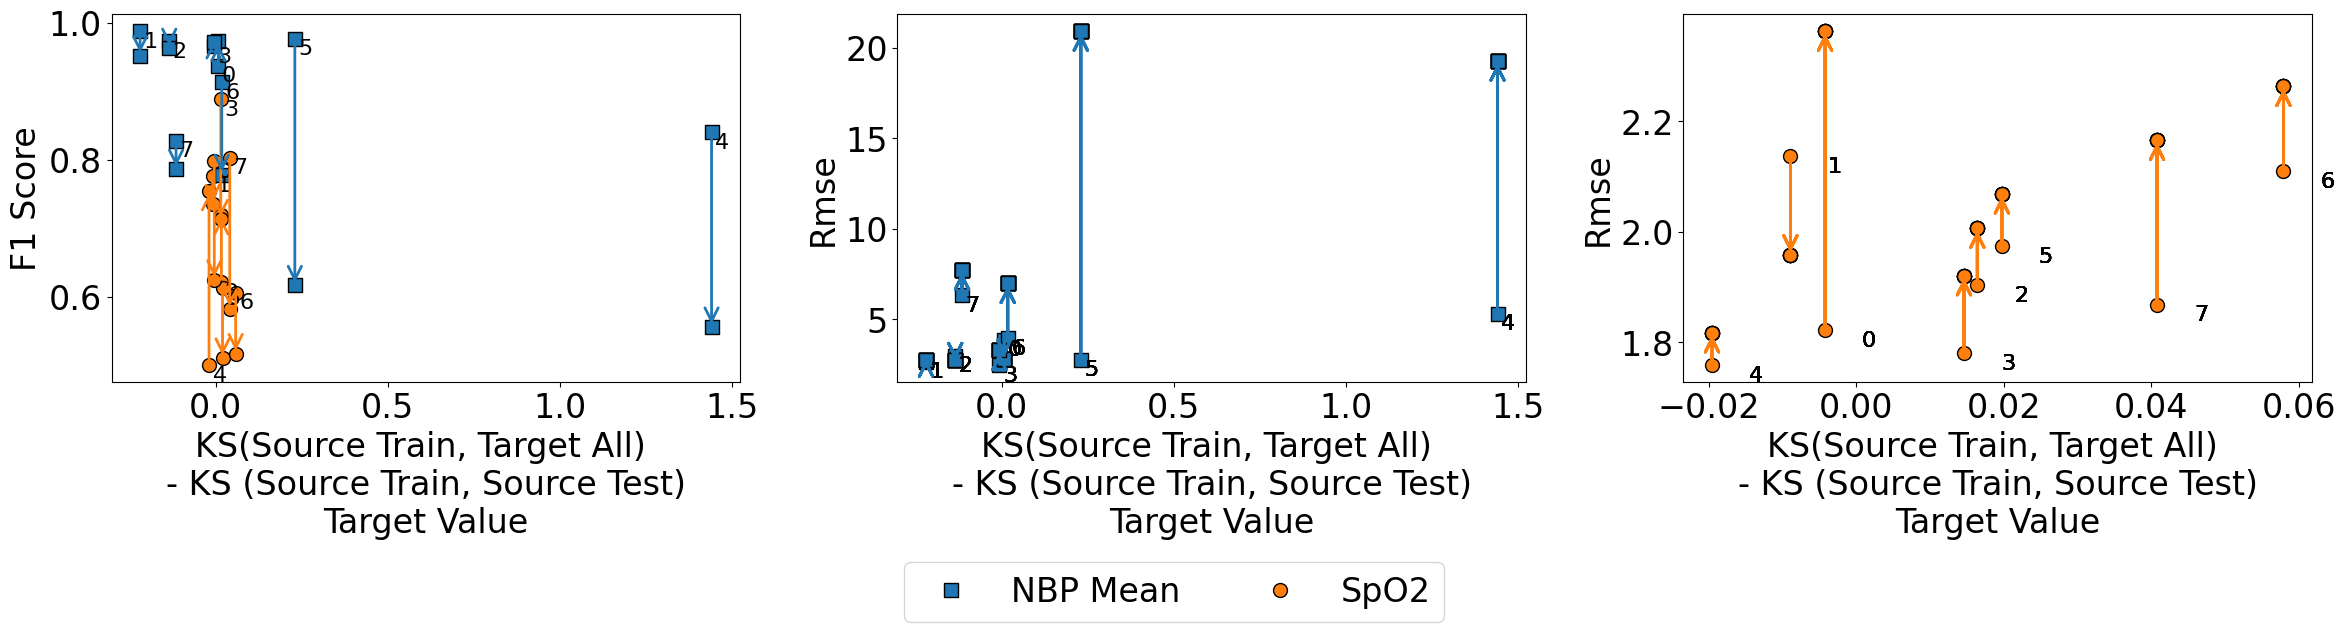

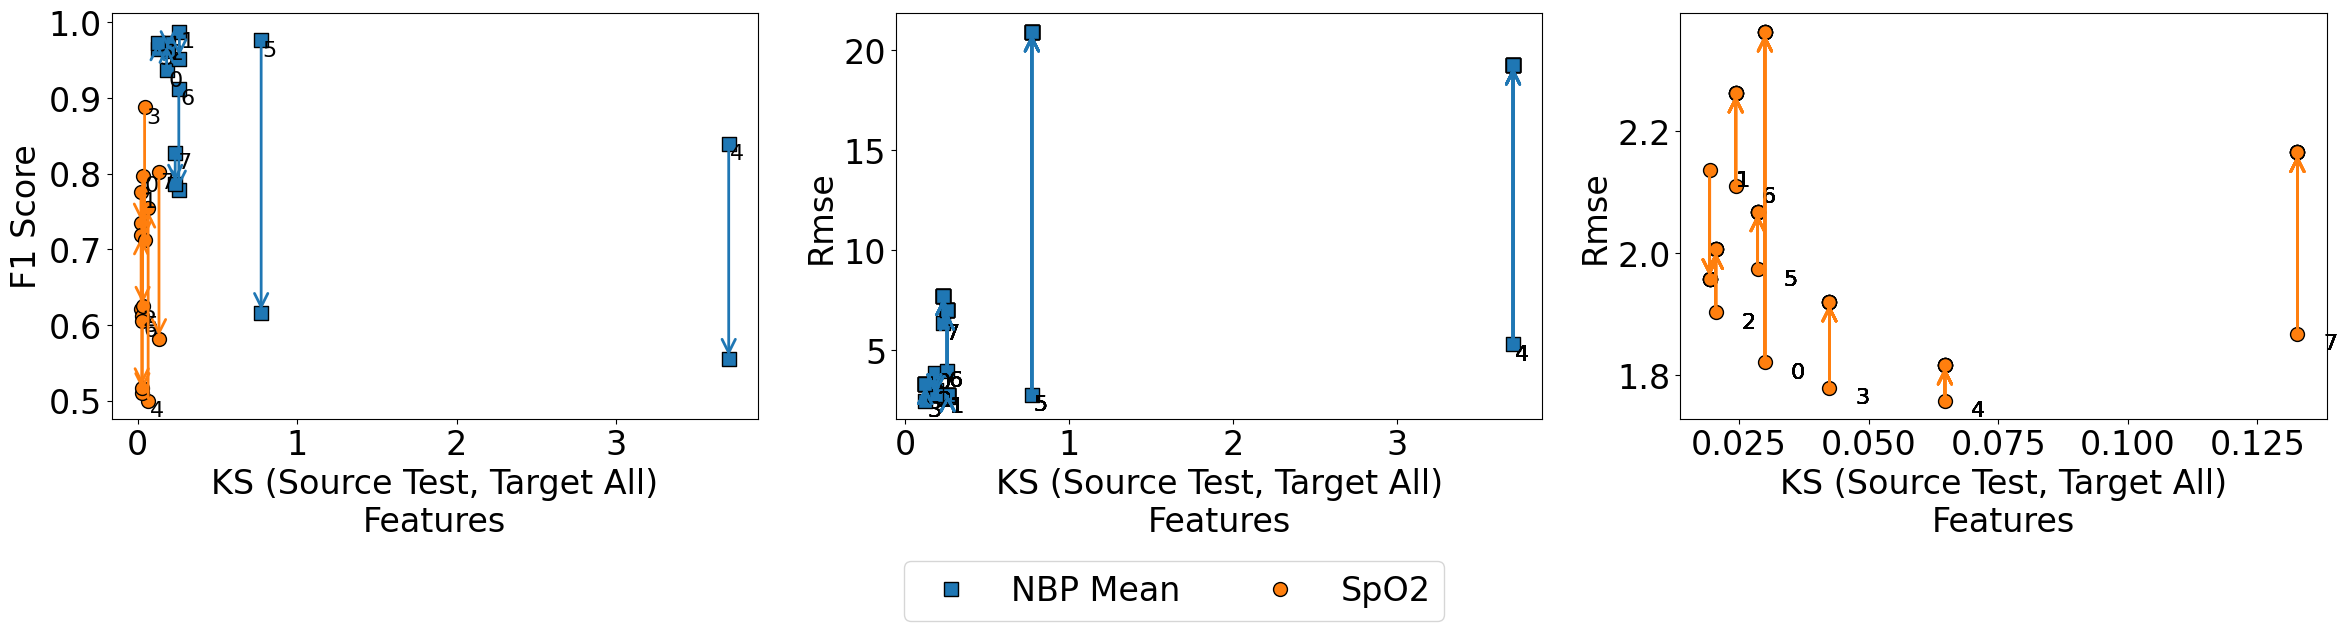

In [33]:
merged_results_and_distances = load_distribution_shift_performance_overall("kl_divergence")
visualize_source_train_vs_target_all_relationships_absolute_performance(merged_results_and_distances)

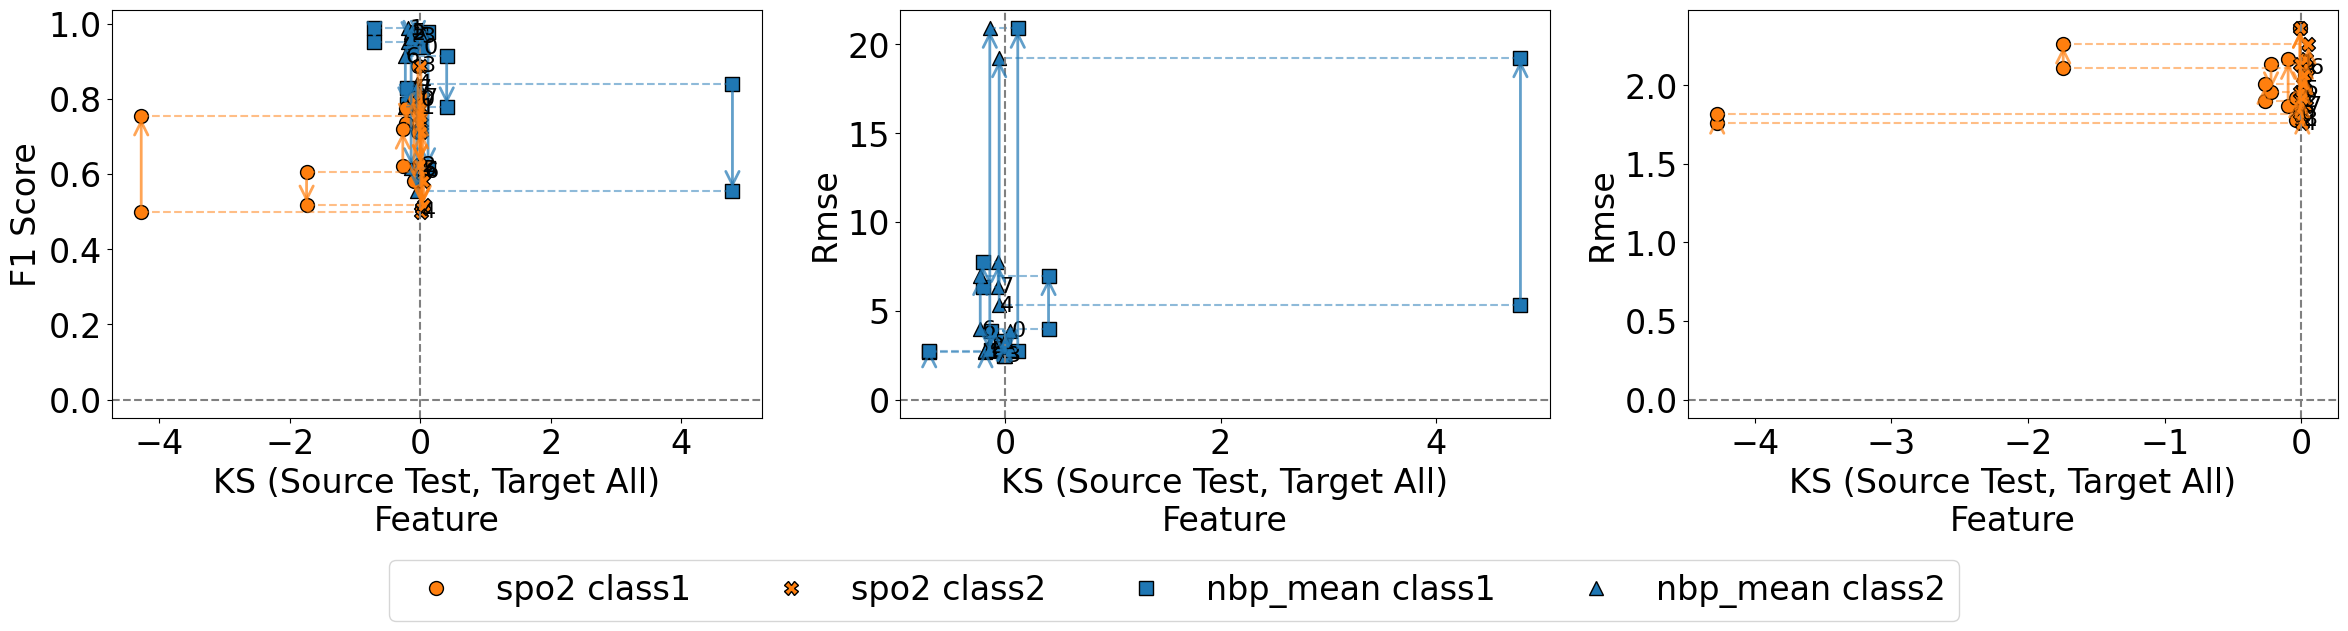

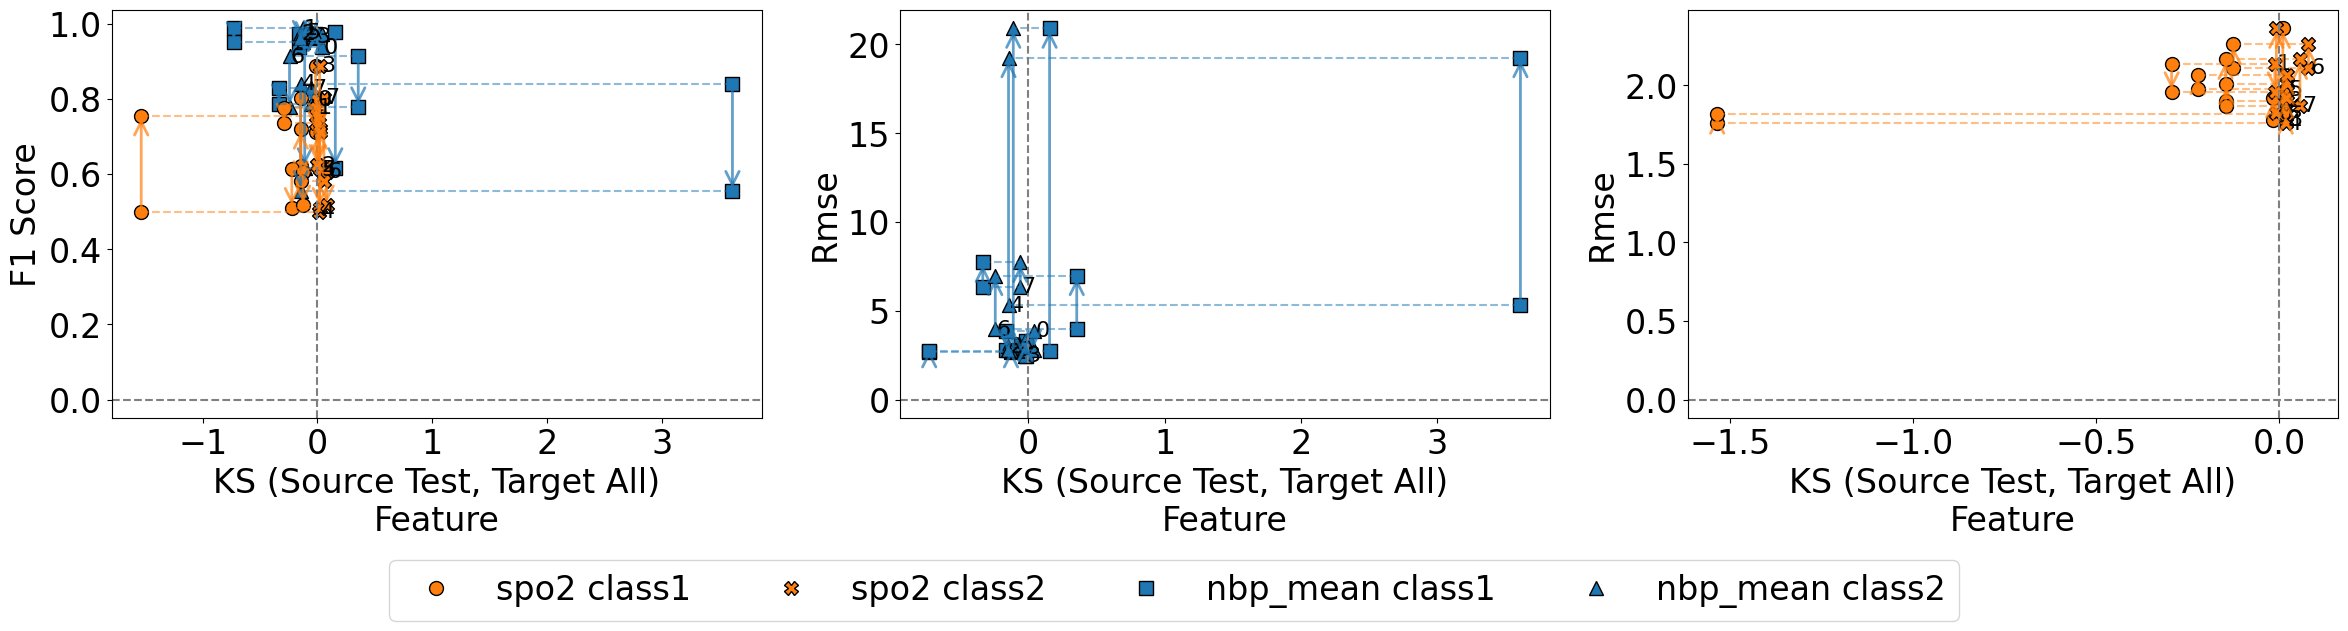

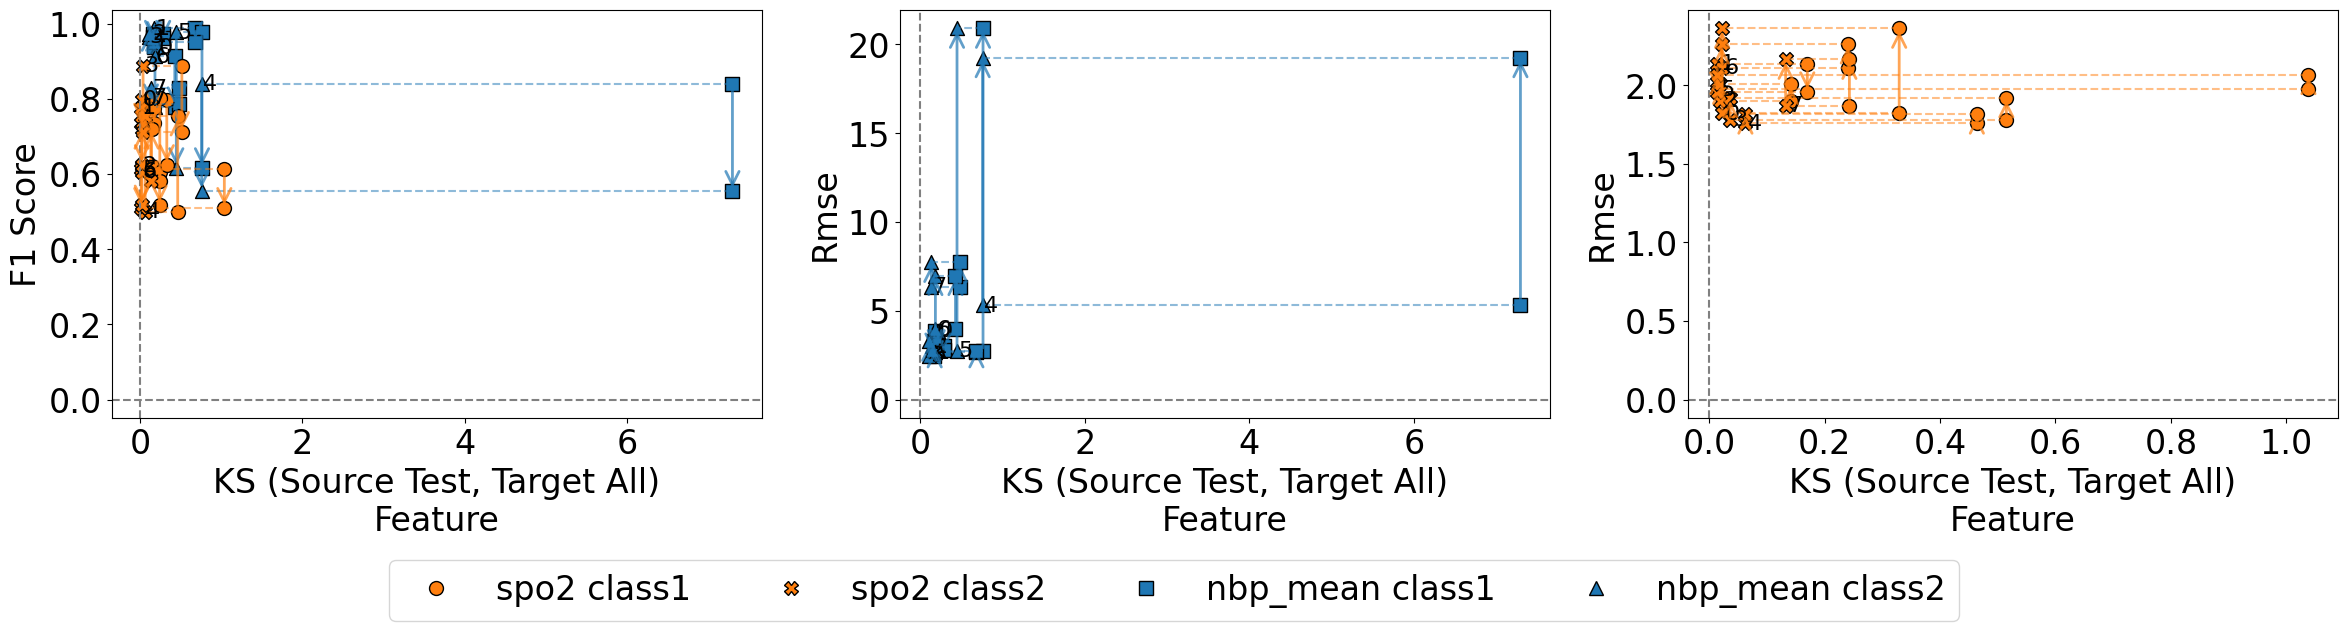

In [34]:
merged_results_and_distances = load_distribution_shift_performance_classwise("kl_divergence")
visualize_source_train_vs_target_all_relationships_classwise_absolute_performance(merged_results_and_distances)